In [1]:
import os
import glob
import numpy as np
import xarray as xr
import dask
from scipy.ndimage import rotate
from scipy.integrate import cumtrapz

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
matplotlib.rcParams.update({'font.size':15})
import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/global/cscratch1/sd/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)
    
from tools.e5tools import *;from tools.generalTools import *;from tools.BLtools import *
from orographicConvectionTheory.orographicConvectionTheory import *
from orographicPrecipitation.observationsAndERA5.mountainUtils import *; from tools.generalTools import *; from tools.BLtools import *
km_per_degreelat = 6370*np.pi/180
mnths=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']


import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

xr.set_options(display_style='text') 

In [2]:
from dask.distributed import Client
client=Client()

In [3]:
def plot_pr_t_q(ax,axm,axT,z,pr,t,q,P0=6.,lns='-',legend=False):
    if legend:
        labelpr = "GPM pr"
        labelprqe = r"$P_0 + (q_L'/\tau_q - T_L'/\tau_T)$"
        labelT = r"$T_L'$"
        labelq = r"$q_L'$"
    else:
        labelpr=None;labelprqe=None;labelT=None;labelq=None
    pT_ov_g = 8e3 #mass of troposphere in kg/m2
    Lc=2.5e6
    cp=1004.
    
    crossslope_avg(pr).plot(ax=ax,color='blue',linestyle=lns,label=labelpr)
    
    crossslope_avg(z).plot(ax=axm,color='k')

    TL = crossslope_avg(t).sel(level=slice(700.,900.)).mean('level')
    TLprime = (TL-TL.sel(x=slice(TL.x[0],TL.x[0]+200)).mean('x'))
    qL = Lc/cp*crossslope_avg(q).sel(level=slice(700.,900.)).mean('level')
    qLprime = (qL-qL.sel(x=slice(qL.x[0],qL.x[0]+200)).mean('x'))
    TLprime.plot(ax=axT,color='r',linestyle=lns,linewidth=0.5,label=labelT)
    qLprime.plot(ax=axT,color='g',linestyle=lns,linewidth=0.5,label=labelq)
    
    #qLprime=0.
    tauT = 7.5*3600; tauq = 27.5*3600
    #tauT/=2.;tauq/=2.
    p_qe = P0+pT_ov_g * (-TLprime/tauT + qLprime/tauq)*cp/ Lc * 86400
    p_qe.plot(ax=ax,color='c',linestyle=lns,label=labelprqe)
    
    ax.set_ylabel('mm/day')
    axm.set_ylabel('m')
    axT.set_ylabel('K')

In [4]:
def linear_precip_theory_N(xx,hx,U,N,qfact=1,tauT=3,tauq=11,P0=4.,Td_effect=1,m_effect=1):
    pT_ov_g = 8e3 #mass of troposphere in kg/m2
    
    z=np.arange(0,10000,100)
    k=k_vector(len(xx),xx[1]-xx[0])
    
    tauT*=3600
    tauq*=3600
    
    Lq=compute_Lq(5,U,tauq)
    
    _,dq0dz,_ = lapse_rates()
    N0=0.01
    if Td_effect:
        ds0dz = cp*300/g*N**2
    else:
        ds0dz = cp*300/g*N0**2
    chi = pT_ov_g * (ds0dz/tauT - qfact*dq0dz/tauq)/ Lc * 86400
    
    if not m_effect:
        N=N0
    
    zbot=1000
    ztop=3000    
    z_slice = z[np.where((z>=zbot) & (z<=ztop))]
    Pprimehat = 1j*k/(1j*k + 1/Lq) * chi * np.fft.fft(hx) * np.exp( m_exponent(k[:,None],N,U)  *  z_slice[None,:]).mean(axis=1) 
    
    P = P0 + np.real(np.fft.ifft(Pprimehat))
    P = np.maximum(0.,P)
    return P

import sys; import os
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)
from tools.generalTools import qsat,humidsat

def HwCw(temp_surface,ps,gamma,gamma_m):
    """Compute water vapor scale height and coefficient Cw assuming a moist adiabatic atmosphere
     - temp_surface = surface temperature (np.array)
     - ps = surface pressure (np.array)
     - gamma = environment lapse rate
    """
    L=2.5e6
    Hw = 461.*temp_surface**2/(L*gamma)
    Cw = humidsat(temp_surface,ps/100)[0]*100/287./temp_surface*gamma_m/gamma
    return Hw,Cw
def smith_theory(xx,hx,u,gamma,gamma_m,ts=300.,tau=2000,P0=4.):
    ps=100000.
    Hw,Cw = HwCw(ts,ps,gamma,gamma_m)
    if gamma < gamma_m:
        N=np.sqrt(9.81/ts*(gamma_m-gamma))
        print("using moist stability, N=%.3f"%N)
    else:
        N=np.sqrt(9.81/ts*(9.81/1000-gamma))
        print("using dry stability, N=%.3f"%N)
    print("Hw=%i,Cw=%.3f"%(Hw,Cw))

    tau_c=tau
    tau_f=tau
    
    k=k_vector(len(xx),xx[1]-xx[0])
    
    P=np.maximum(P0+86400*np.real(np.fft.ifft(Cw*np.fft.fft(hx)*1j*u*k/(1-Hw*m_exponent(k,N,u))/(1+1j*u*k*tau_c)/(1+1j*u*k*tau_f))),0.)
    return xx,hx,P


In [5]:
def compute_primes(region,varname,month=-1):
    if 'level' in region.vars_rot[varname].dims:
        varL = crossslope_avg(region.vars_rot[varname]).sel(level=slice(700.,900.)).mean('level')
    else:
        varL = crossslope_avg(region.vars_rot[varname])
    varLprime = (varL-varL.sel(x=slice(varL.x[0],varL.x[0]+200)).mean('x'))
    if month<0:
        return varLprime.sel(x=slice(-200,-50)).mean('x')
    else:
        return varLprime.sel(time=(varLprime['time.month']==month),x=slice(-200,-50)).mean('x')
def get_binned(a,b,bins,std=False):
    bins=bins[(bins>float(a.min()))&(bins<float(a.max()))]
    bin_centers=(bins[1:]+bins[:-1])/2
    digitized = np.digitize(np.array(a), bins)
    bin_means = np.array([np.array(b)[digitized == i].mean() for i in range(1, len(bins))])
    if std:
        bin_std = np.array([np.array(b)[digitized == i].std() for i in range(1, len(bins))])
        return bin_centers,bin_means,bin_std
    else:
        return bin_centers,bin_means
def sel_month(ds,m):
    return ds.sel(time=(ds['time.month']==m))

In [6]:
# Monthly data loading

orogm=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81
landmask=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM.isel(time=0)

In [7]:
#with dask.config.set(**{'array.slicing.split_large_chunks': False}):
#    gpm_pr=xr.open_mfdataset("/global/cfs/projectdirs/m3310/qnicolas/GPM-IMERG/*.nc").precipitation.rename({'lat':'latitude','lon':'longitude'})
#    gpm_pr.coords['longitude'] = gpm_pr.coords['longitude'] % 360
#    gpm_pr = gpm_pr.sortby(gpm_pr.longitude)
#    gpm_pr = gpm_pr.reindex(latitude=list(reversed(gpm_pr.latitude)))
#    gpm_pr = gpm_pr.sel(time=slice("2001-01-01","2018-12-31"))
#gpm_pr.to_netcdf('/global/cscratch1/sd/qnicolas/temp/GPM-IMERG.monthly.2001-2018.nc')    
gpm_pr = xr.open_dataarray('/global/cscratch1/sd/qnicolas/temp/GPM-IMERG.monthly.2001-2018.nc')    
#gpm_pr_seasmean = gpm_pr.groupby("time.month").mean("time")
#gpm_pr_seasmean.to_netcdf("/global/cscratch1/sd/qnicolas/temp/GPM-IMERG-seasonalmean-200101-201812.nc")

In [8]:
gpm_pr_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/GPM-IMERG-seasonalmean-200101-201812.nc")
climcapst_climatology = xr.open_zarr("/global/cscratch1/sd/qnicolas/CLIMCAPS_V2/monthly/L3_CLIMCAPS_QCC.air_temp.monthly.zarr").air_temp.groupby('time.month').mean(['time','orbit_pass'])

In [9]:
climcapst_climatology_night = xr.open_zarr("/global/cscratch1/sd/qnicolas/CLIMCAPS_V2/monthly/L3_CLIMCAPS_QCC.air_temp.monthly.zarr").air_temp.isel(orbit_pass=1).groupby('time.month').mean(['time'])
climcapst_climatology_aft = xr.open_zarr("/global/cscratch1/sd/qnicolas/CLIMCAPS_V2/monthly/L3_CLIMCAPS_QCC.air_temp.monthly.zarr").air_temp.isel(orbit_pass=0).groupby('time.month').mean(['time'])


In [10]:
#era5pr_seasmean   = 1000*e5_climatology('128_228_tp', years=range(2001,2019)); era5pr_seasmean  .to_netcdf("/global/cscratch1/sd/qnicolas/temp/e5.climatology.128_228_tp.2001-2018.nc")
#era5100u_seasmean =      e5_climatology("*_100u",     years=range(2001,2019)); era5100u_seasmean.to_netcdf("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_246_100u.2001-2018.nc")
#era5100v_seasmean =      e5_climatology("*_100v",     years=range(2001,2019)); era5100v_seasmean.to_netcdf("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_247_100v.2001-2018.nc")
era5pr_seasmean  =xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.128_228_tp.2001-2018.nc")
era5100u_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_246_100u.2001-2018.nc")
era5100v_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_247_100v.2001-2018.nc")

In [11]:
#era5pr_monthly   = 1000*e5_monthly_timeseries('128_228_tp', years=range(2001,2019)); era5pr_monthly  .to_netcdf("/global/cscratch1/sd/qnicolas/temp/e5.monthly.128_228_tp.2001-2018.nc")
#era5100u_monthly =      e5_monthly_timeseries("*_100u",     years=range(2001,2019)); era5100u_monthly.to_netcdf("/global/cscratch1/sd/qnicolas/temp/e5.monthly.228_246_100u.2001-2018.nc")
#era5100v_monthly =      e5_monthly_timeseries("*_100v",     years=range(2001,2019)); era5100v_monthly.to_netcdf("/global/cscratch1/sd/qnicolas/temp/e5.monthly.228_247_100v.2001-2018.nc")
era5pr_monthly  =xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.monthly.128_228_tp.2001-2018.nc")
era5100u_monthly=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.monthly.228_246_100u.2001-2018.nc")
era5100v_monthly=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.monthly.228_247_100v.2001-2018.nc")

# Vietnam

## Data loading

### Monthly

In [10]:
box = [102,115,10,19.5]
angle = 240
precipitating_month = 10
mountaintop=800. # abscissa of mountain top within rotated frame

box_tilted = [107  ,  19  , 110.5, 14   ,2  ]
box_ref_rce = [112, 114, 17, 19]            # Small, integer boxes to better assess mtn wave
box_ref_closeupstream = [108, 109, 15, 17]  # Small, integer boxes to better assess mtn wave

Vietnam = MountainRange('vietnam',box,"Annamite range (Vietnam)",angle,precipitating_month,mountaintop)
Vietnam.set_boxes(box_ref_rce,box_ref_closeupstream,box_tilted)

Vietnam.set_2dvar('GPM_PR',gpm_pr_seasmean)
Vietnam.set_2dvar('E5_PR',era5pr_seasmean)
Vietnam.set_2dvar('VAR_100U',era5100u_seasmean)
Vietnam.set_2dvar('VAR_100V',era5100v_seasmean)
Vietnam.set_2dvar('Z',orogm)
Vietnam.set_uperp()

Vietnam.set_3dvar('T',"128_130_t")
Vietnam.set_3dvar('U',"128_131_u")
Vietnam.set_3dvar('V',"128_132_v")
Vietnam.set_3dvar('W',"128_135_w")
Vietnam.set_3dvar('Q',"128_133_q")
Vietnam.set_uperp3d()

Vietnam.set_4dvar('T4D',"128_130_t")
Vietnam.set_4dvar('Q4D',"128_133_q")
Vietnam.set_othervar('GPM_PR_3D',sel_box_month(gpm_pr,Vietnam.box,0))

Vietnam.set_othervar('E5_PR_3D',sel_box_month(era5pr_monthly,Vietnam.box,0))

Vietnam.set_othervar('CLIMCAPS_T',sel_box_month(climcapst_climatology,Vietnam.box,Vietnam.pr_month).assign_coords(level=climcapst_climatology.air_pres/100).swap_dims({'air_pres':'level'}))

7.019977569580078


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### Daily

In [11]:
era5t_vietnam_octdaily = xr.concat((xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.pl.128_130_t.ll025sc.%i10.vietnam.zarr"%year) for year in range(2001,2016)),dim='time').T
era5q_vietnam_octdaily = xr.concat((xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.pl.128_133_q.ll025sc.%i10.vietnam.zarr"%year) for year in range(2001,2016)),dim='time').Q
era5w_vietnam_octdaily = xr.concat((xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.pl.128_135_w.ll025sc.%i10.vietnam.zarr"%year) for year in range(2001,2016)),dim='time').W
era5100u_vietnam_octdaily = xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.sfc.228_246_100u.ll025sc.2001-2015.10.vietnam.zarr").VAR_100U
era5100v_vietnam_octdaily = xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.sfc.228_247_100v.ll025sc.2001-2015.10.vietnam.zarr").VAR_100V
trmmpr_vietnam_octdaily = xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/trmm.2001-2013.10.vietnam.zarr").pr*24*3600
gpmpr_vietnam_octdaily = xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/gpm_imerg_v06.2001-2015.10.vietnam.zarr").precipitationCal.transpose('time','latitude','longitude')
climcapst_vietnam_octdaily = xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/L3_CLIMCAPS_QCC.air_temp.2002-2015.10.vietnam.zarr").air_temp
climcapst_vietnam_octdaily = climcapst_vietnam_octdaily.assign_coords(level=climcapst_vietnam_octdaily.air_pres/100).swap_dims({'air_pres':'level'})


In [12]:
precipmask = tilted_rect(gpmpr_vietnam_octdaily,*Vietnam.box_tilted)*landmask.interp_like(gpmpr_vietnam_octdaily)

In [13]:
## PRECIP THRESHOLD
pr_timeseries = spatial_mean(gpmpr_vietnam_octdaily,mask=precipmask).load()

## UPSLOPE THRESHOLD

upslopeflow_3d = rotate_var(crossslopeflow(era5100u_vietnam_octdaily,era5100v_vietnam_octdaily,Vietnam.angle),Vietnam.angle,Vietnam.x_mountaintop,two_dim=False)
#upslopeflow_timeseries = crossslope_avg(upslopeflow_3d).sel(x=slice(-400,-200)).mean('x').resample(time='1d').mean()
upslopeflow_timeseries = upslopeflow_3d.sel(x=slice(-800,-200),y=slice(250,350)).mean(['x','y']).resample(time='1d').mean()
upslopeflow_timeseries = upslopeflow_timeseries.where(upslopeflow_timeseries['time.month']==10,drop=True).load()


In [21]:
allvars=[era5t_vietnam_octdaily,era5q_vietnam_octdaily,era5w_vietnam_octdaily,era5100u_vietnam_octdaily,era5100v_vietnam_octdaily,gpmpr_vietnam_octdaily,climcapst_vietnam_octdaily]
varnames = ['T','Q','W','VAR_100U','VAR_100V','GPM_PR','CLIMCAPS_T']

In [22]:
## UPSLOPE THRESHOLD

for var,varname in zip(allvars,varnames):
    pctile=50
    Vietnam.set_othervar(varname+'_PR%i'%pctile,var.sel(time = timesel(var.time,extreme_days(pr_timeseries,pctile))).mean('time').load())
    Vietnam.set_othervar(varname+'_U%i'%pctile,var.sel(time = timesel(var.time,extreme_days(upslopeflow_timeseries,pctile))).mean('time').load())
    pctile=90
    Vietnam.set_othervar(varname+'_U%i'%pctile,var.sel(time = timesel(var.time,extreme_days(upslopeflow_timeseries,pctile))).mean('time').load())

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


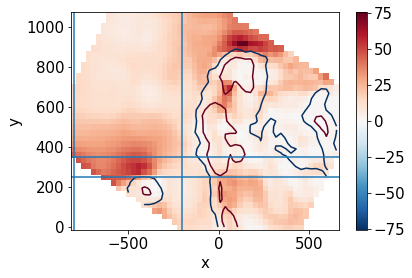

In [47]:
upslopeflow_3d[10].plot()
Vietnam.vars_rot['Z'].plot.contour(levels=[100,500])
plt.axhline(250)
plt.axhline(350)
plt.axvline(-800)
plt.axvline(-200)

## Monthly means

### Maps

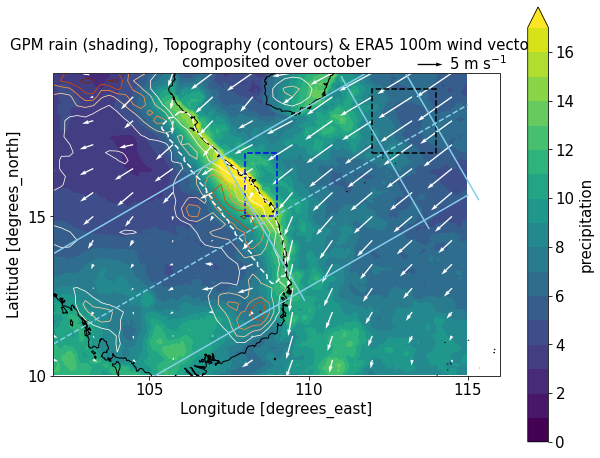

In [17]:
fig,ax = plt.subplots(1,1,figsize=(10,8),subplot_kw={"projection":ccrs.PlateCarree()})
topography_pr_wind_plot(ax,Vietnam.box,Vietnam.vars['Z'],Vietnam.vars['GPM_PR'],Vietnam.vars['VAR_100U'],Vietnam.vars['VAR_100V'],np.arange(0,18,1))

#Boxes
for smallbox,clr in ((Vietnam.box_upstream,'k'),(Vietnam.box_above,'b')):
    ax.add_patch(mpatches.Rectangle(xy=[smallbox[0], smallbox[2]], width=smallbox[1]-smallbox[0], height=smallbox[3]-smallbox[2],
                                       edgecolor=clr,
                                       fill = False,
                                       lw=1.5,
                                       linestyle='--',
                                       transform=ccrs.PlateCarree())
                    )
precipmask.plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['w'])

alpha = np.tan(np.pi/2-np.pi*Vietnam.angle/180)
x0,x1=box[0],box[1]; xm=(x0+x1)/2
y0,y1=box[2],box[3]; ym=(y0+y1)/2
fx = np.array([ym + alpha*(x0-xm),ym + alpha*(x1-xm)])
ax.plot([x0,x1],fx,color='skyblue',linestyle='--')
ax.plot([x0,x1],fx-(y1-y0)/4/np.cos(alpha),color='skyblue',linestyle='-')
ax.plot([x0,x1],fx+(y1-y0)/4/np.cos(alpha),color='skyblue',linestyle='-')

dx = alpha*(y1-y0)/4
xu1 = xm + 700/111 * np.cos(np.arctan(alpha))
xu2 = xm + 500/111 * np.cos(np.arctan(alpha))
for xa in xm,xu1,xu2:
    ax.plot([xa-dx,xa+dx],[ym + alpha*(xa-xm)+dx/alpha,ym + alpha*(xa-xm)-dx/alpha],color='skyblue',linestyle='-')


ax.set_title("GPM rain (shading), Topography (contours) & ERA5 100m wind vectors\ncomposited over october",fontsize=15);None

Text(0.5, 1.0, 'Perturbation q climatology (nondim)')

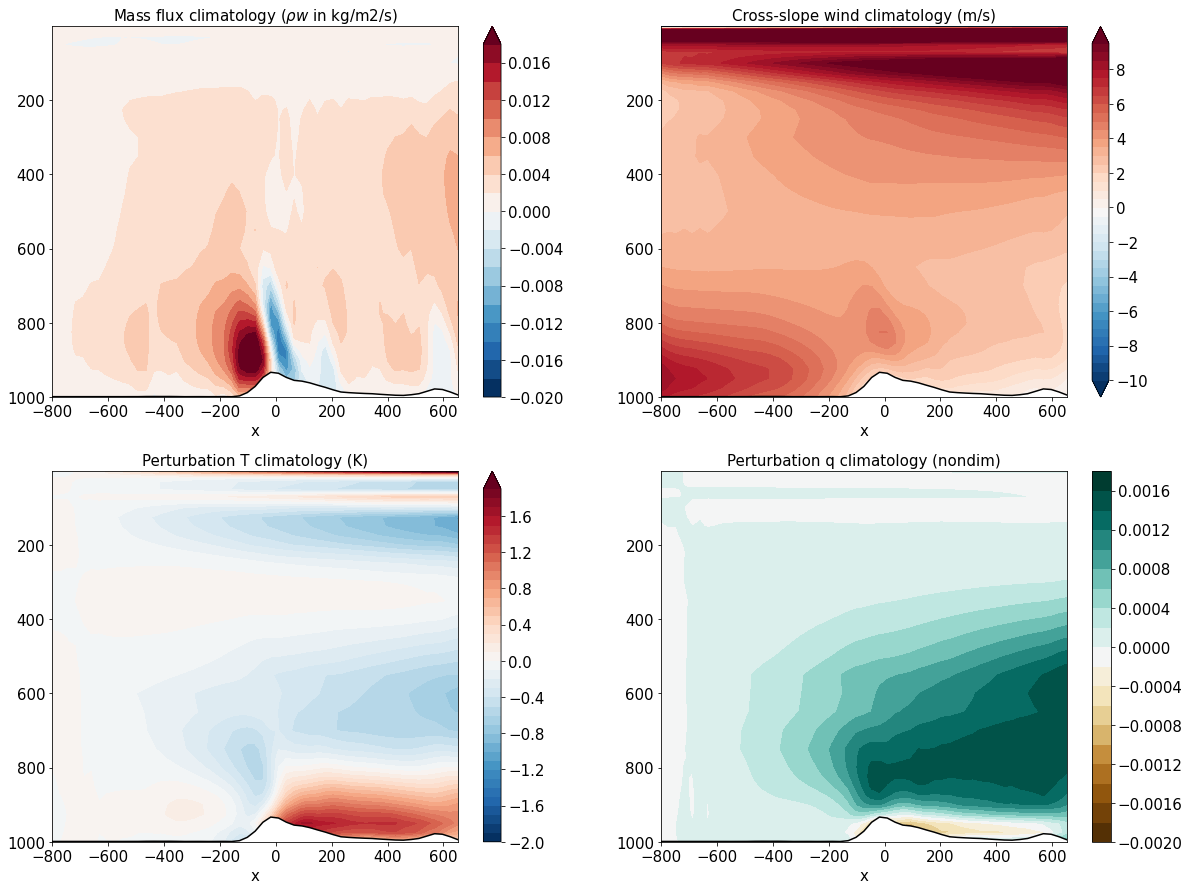

In [18]:
fig,ax = plt.subplots(2,2,figsize=(20,15))
ax=ax.reshape(-1)
plot_xz(ax[0],Vietnam,'W',levels=np.arange(-0.02,0.02,0.002),fact=-1/9.81)
plot_xz(ax[1],Vietnam,'U_PERP',levels=np.arange(-10,10,0.5))
plot_xz(ax[2],Vietnam,'T',pert=True,levels=np.arange(-2,2,0.1))
plot_xz(ax[3],Vietnam,'Q',pert=True,levels=np.arange(-0.002,0.002,0.0002),cmap=plt.cm.BrBG)

ax[0].set_title(r'Mass flux climatology ($\rho w$ in kg/m2/s)',fontsize=15)
ax[1].set_title(r'Cross-slope wind climatology (m/s)',fontsize=15)
ax[2].set_title(r'Perturbation T climatology (K)',fontsize=15)
ax[3].set_title(r'Perturbation q climatology (nondim)',fontsize=15)

### Nonlinear theory

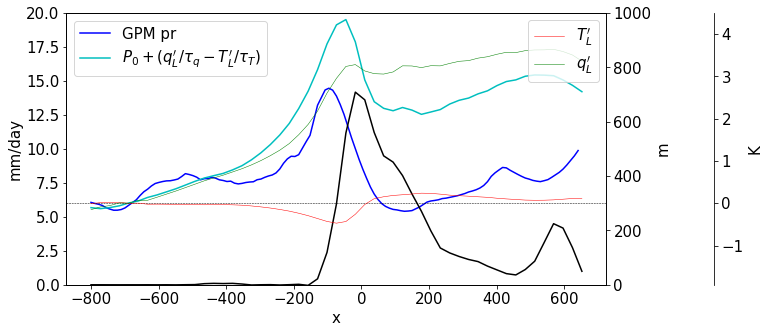

In [15]:
fig,ax = plt.subplots(1,1,figsize=(12,5))
fig.subplots_adjust(right=0.75)
axm=ax.twinx()
axT=ax.twinx()
axT.spines['right'].set_position(("axes", 1.2))

plot_pr_t_q(ax,axm,axT,Vietnam.vars_rot['Z'],Vietnam.vars_rot['GPM_PR'],Vietnam.vars_rot['T'],Vietnam.vars_rot['Q'],lns='-',legend=True)

ax.axhline(6.,color='k',linewidth=0.5,linestyle='--')

ax.set_ylim(0,20)
axm.set_ylim(0,1000)
axT.set_ylim(-4.5*6/(20-6),4.5)
ax.legend(loc=2)
axT.legend(loc=1)

In [108]:
TLprimes = compute_primes(Vietnam,'T4D')
qLprimes = compute_primes(Vietnam,'Q4D')
nonlin_pr_allmonths = P0+pT_ov_g * (-TLprimes/tauT + qLprimes/tauq)*cp/ Lc * 86400
gpm_pr_allmonths    = crossslope_avg(Vietnam.vars_rot['GPM_PR_3D'].sel(x=slice(-200,-50)).mean('x'))
e5_pr_allmonths     = crossslope_avg(Vietnam.vars_rot['E5_PR_3D'].sel(x=slice(-200,-50)).mean('x'))


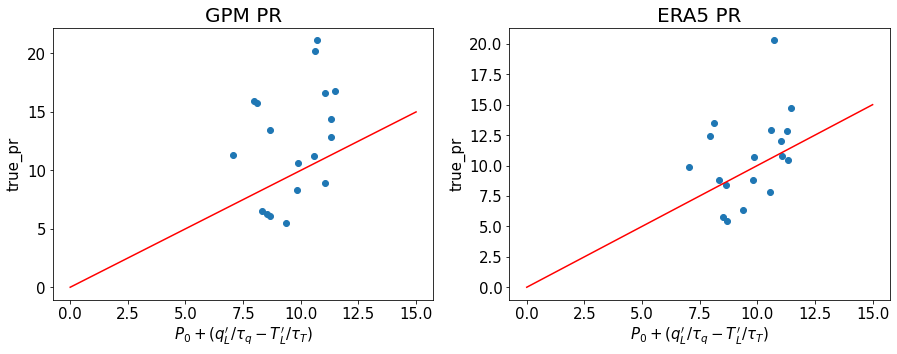

In [109]:
matplotlib.rcParams.update({'font.size':15})
_,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].scatter(sel_month(nonlin_pr_allmonths,10),sel_month(gpm_pr_allmonths,10))
ax[1].scatter(sel_month(nonlin_pr_allmonths,10),sel_month(e5_pr_allmonths,10))

ax[0].set_title('GPM PR' ,fontsize=20)
ax[1].set_title('ERA5 PR',fontsize=20)
for a in ax:
    a.set_ylabel('true_pr')
    a.set_xlabel(r"$P_0 + (q_L'/\tau_q - T_L'/\tau_T)$")
    a.plot([0,15],[0,15],color='r')

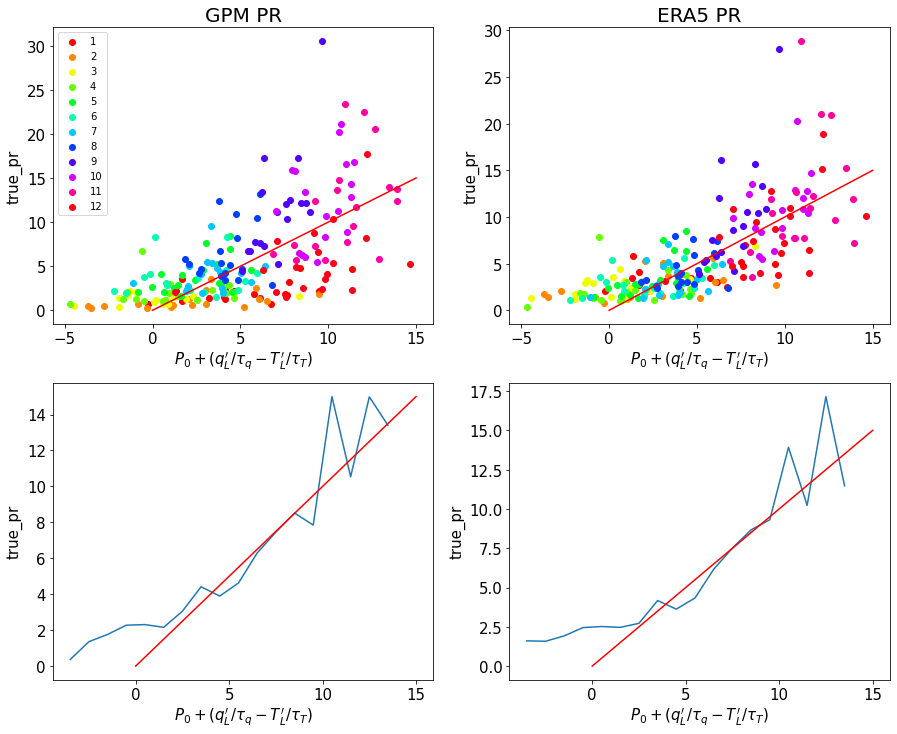

In [110]:
_,ax = plt.subplots(2,2,figsize=(15,12))
colors=plt.cm.hsv(np.linspace(0,1,12))
for m in range(12):
    ax[0,0].scatter(sel_month(nonlin_pr_allmonths,m+1),sel_month(gpm_pr_allmonths,m+1),color=colors[m],label=m+1)
    ax[0,1].scatter(sel_month(nonlin_pr_allmonths,m+1),sel_month(e5_pr_allmonths ,m+1),color=colors[m],label=m+1)

ax[1,0].plot(*get_binned(nonlin_pr_allmonths,gpm_pr_allmonths,np.arange(-5,15,1)))
ax[1,1].plot(*get_binned(nonlin_pr_allmonths,e5_pr_allmonths,np.arange(-5,15,1)))

ax[0,0].set_title('GPM PR' ,fontsize=20)
ax[0,1].set_title('ERA5 PR',fontsize=20)
for a in ax.reshape(-1):
    a.set_ylabel('true_pr')
    a.set_xlabel(r"$P_0 + (q_L'/\tau_q - T_L'/\tau_T)$")
    a.plot([0,15],[0,15],color='r')
ax[0,0].legend(loc=2,fontsize=10)

In [111]:
TLprimes = compute_primes(Vietnam,'T4D')
qLprimes = compute_primes(Vietnam,'Q4D')
nonlin_pr_allmonths = pT_ov_g * (-TLprimes/tauT + qLprimes/tauq)*cp/ Lc * 86400
gpm_pr_allmonths    = compute_primes(Vietnam,'GPM_PR_3D')
e5_pr_allmonths     = compute_primes(Vietnam,'E5_PR_3D' )


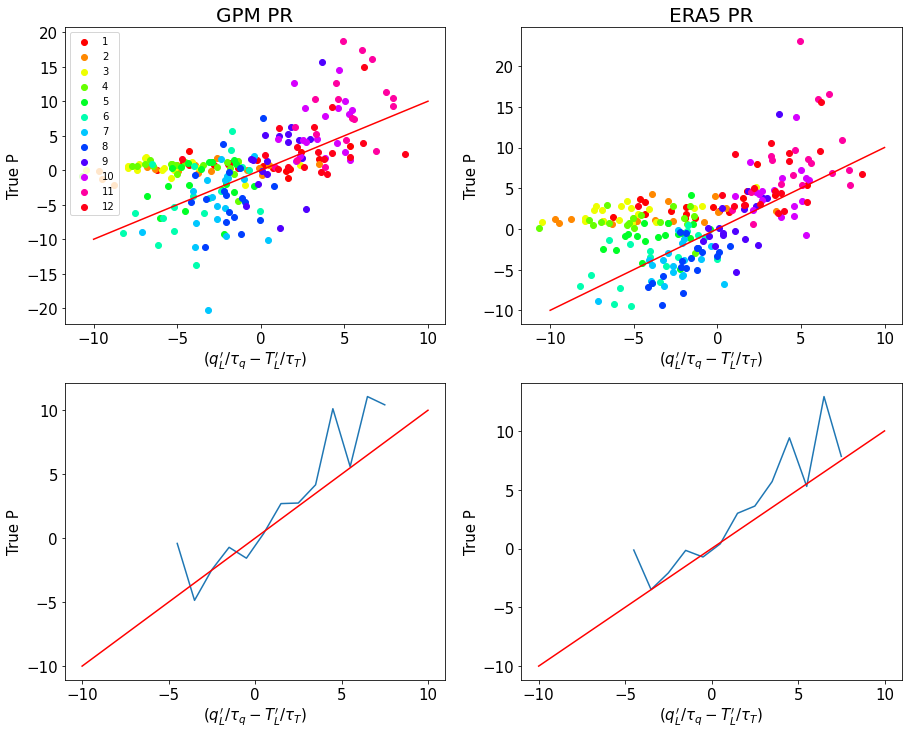

In [113]:
_,ax = plt.subplots(2,2,figsize=(15,12))
colors=plt.cm.hsv(np.linspace(0,1,12))
for m in range(12):
    ax[0,0].scatter(sel_month(nonlin_pr_allmonths,m+1),sel_month(gpm_pr_allmonths,m+1),color=colors[m],label=m+1)
    ax[0,1].scatter(sel_month(nonlin_pr_allmonths,m+1),sel_month(e5_pr_allmonths ,m+1),color=colors[m],label=m+1)

ax[1,0].plot(*get_binned(nonlin_pr_allmonths,gpm_pr_allmonths,np.arange(-5,15,1)))
ax[1,1].plot(*get_binned(nonlin_pr_allmonths,e5_pr_allmonths,np.arange(-5,15,1)))

ax[0,0].set_title('GPM PR' ,fontsize=20)
ax[0,1].set_title('ERA5 PR',fontsize=20)
for a in ax.reshape(-1):
    a.set_ylabel('True P')
    a.set_xlabel(r"$(q_L'/\tau_q - T_L'/\tau_T)$")
    a.plot([-10,10],[-10,10],color='r')
ax[0,0].legend(loc=2,fontsize=10)

In [99]:
era5t_vietnam_octdailymean = sel_month(era5t_vietnam_octdaily.resample(time="1D").mean('time').load(),10)
era5q_vietnam_octdailymean = sel_month(era5q_vietnam_octdaily.resample(time="1D").mean('time').load(),10)

In [102]:
Vietnam.set_othervar("T4D_DAILY",era5t_vietnam_octdailymean)
Vietnam.set_othervar("Q4D_DAILY",era5q_vietnam_octdailymean)
Vietnam.set_othervar("GPM_PR_DAILY",gpmpr_vietnam_octdaily)

In [104]:
TLprimes_d = compute_primes(Vietnam,'T4D_DAILY')
qLprimes_d = compute_primes(Vietnam,'Q4D_DAILY')
nonlin_pr_d = pT_ov_g * (-TLprimes_d/tauT + qLprimes_d/tauq)*cp/ Lc * 86400
gpm_pr_d    = compute_primes(Vietnam,'GPM_PR_DAILY')

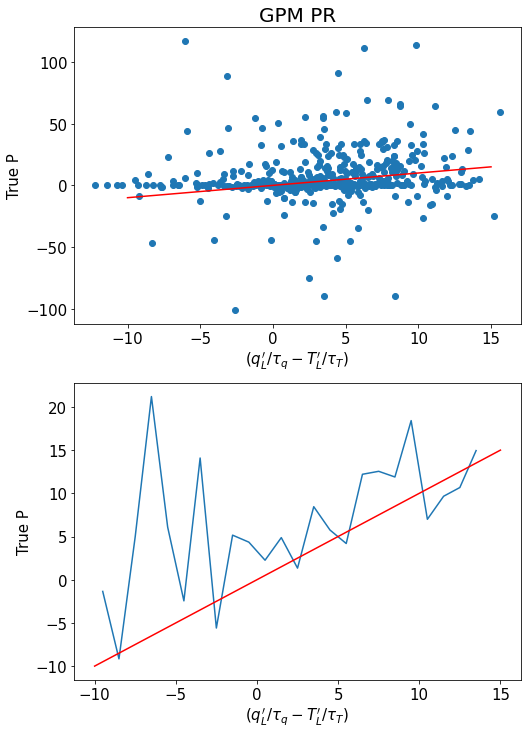

In [107]:
_,ax = plt.subplots(2,1,figsize=(8,12))
ax[0].scatter(nonlin_pr_d,gpm_pr_d)
ax[1].plot(*get_binned(nonlin_pr_d,gpm_pr_d,np.arange(-10,15,1)))

ax[0].set_title('GPM PR' ,fontsize=20)
for a in ax:
    a.set_ylabel('True P')
    a.set_xlabel(r"$(q_L'/\tau_q - T_L'/\tau_T)$")
    a.plot([-10,15],[-10,15],color='r')

### Upwind soundings

In [25]:
Tmean = Vietnam.vars_rot['T4D']
Tprimemean=(Tmean-Tmean.sel(x=slice(Tmean.x[0],Tmean.x[0]+200)).mean('x')).mean('y')
Tprimemean_abv = Tprimemean.sel(x=slice(-100,-0),time=(Tprimemean['time.month']==10)).mean('x')

In [26]:
Tera5_above = sel_box_month(Vietnam.vars['T'],Vietnam.box_above,0).mean(['latitude','longitude'])
Tera5_uupstream = sel_box_month(Vietnam.vars['T'],Vietnam.box_upstream,0).mean(['latitude','longitude'])
Tprimemean_2 = Tera5_above-Tera5_uupstream


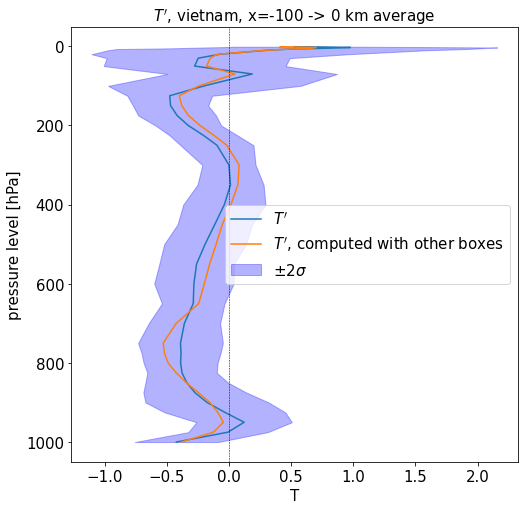

In [27]:
plt.figure(figsize=(8,8))
Tprimemean_abv.mean('time').plot(y='level',yincrease=False,label=(r"$T'$"))
plt.fill_betweenx(Tprimemean_abv.level,Tprimemean_abv.mean('time')-2*Tprimemean_abv.std('time'),Tprimemean_abv.mean('time')+2*Tprimemean_abv.std('time'),color='b',alpha=0.3,label=r'$\pm 2\sigma$')
 

Tprimemean_2.plot(y='level',yincrease=False,label=(r"$T'$, computed with other boxes"))
plt.axvline(0.,color='k',linestyle='--',linewidth=0.5)

plt.title(r"$T'$, vietnam, x=-100 -> 0 km average",fontsize=15)
plt.legend()

### With AIRS soundings

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


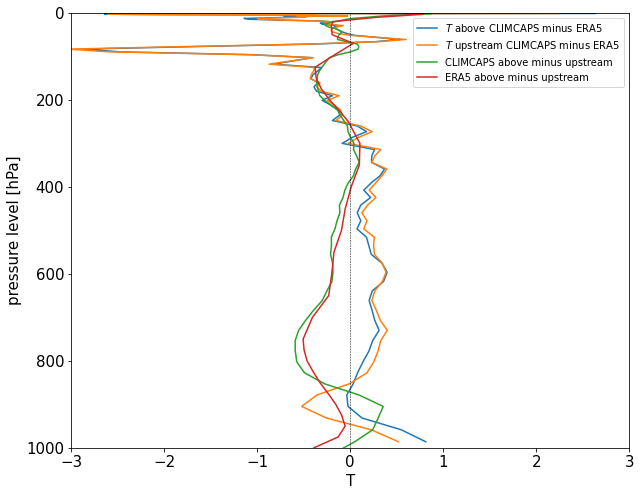

In [28]:

Tclimcaps_above = sel_box_month(Vietnam.vars['CLIMCAPS_T'],Vietnam.box_above,0).mean(['latitude','longitude'])
Tclimcaps_uupstream = sel_box_month(Vietnam.vars['CLIMCAPS_T'],Vietnam.box_upstream,0).mean(['latitude','longitude'])

Tera5_oct_climcapsrecord = Vietnam.vars['T4D'].sel(time=(Vietnam.vars['T4D']['time.month']==Vietnam.pr_month)).sel(time=slice("2002-09-01","2016-09-15")).mean('time')
Tera5_above = sel_box_month(Tera5_oct_climcapsrecord,Vietnam.box_above,0).mean(['latitude','longitude'])
Tera5_uupstream = sel_box_month(Tera5_oct_climcapsrecord,Vietnam.box_upstream,0).mean(['latitude','longitude'])

plt.figure(figsize=(10,8))
(Tclimcaps_above-Tera5_above.interp_like(Tclimcaps_above)).plot(y='level',yincrease=False,label=(r"$T$ above CLIMCAPS minus ERA5"))
(Tclimcaps_uupstream-Tera5_uupstream.interp_like(Tclimcaps_above)).plot(y='level',yincrease=False,label=(r"$T$ upstream CLIMCAPS minus ERA5"))

dTclimcaps=Tclimcaps_above-Tclimcaps_uupstream
dTclimcaps.plot(y='level',yincrease=False,label=(r"CLIMCAPS above minus upstream"))
#plt.fill_betweenx(dtemp.level,dtemp.mean('year')-2*dtemp.std('year'),dtemp.mean('year')+2*dtemp.std('year'),color='g',alpha=0.3,label=r'$\pm 2\sigma$')
 
dTera5=Tera5_above-Tera5_uupstream
dTera5.plot(y='level',yincrease=False,label=(r"ERA5 above minus upstream"))
#plt.fill_betweenx(dTera5.level,dTera5.mean('time')-2*dTera5.std('time'),dTera5.mean('time')+2*dTera5.std('time'),color='r',alpha=0.3,label=r'$\pm 2\sigma$')
 
plt.axvline(0.,color='k',linestyle='--',linewidth=0.5)
plt.xlim(-3,3)
plt.ylim(1000,0)

#plt.title(r"$T'$, vietnam, x=-100 -> 0 km average",fontsize=15)
plt.legend(fontsize=10)

## Precipitating days, windy days

In [29]:
def intersect_frac(ls1,ls2):
    return len([e for e in ls1 if e in ls2])/len(ls1)
pctile=50
print("Intersection between >50th pctile precipitating and windy days: %.1f %%"%(100*intersect_frac(extreme_days(pr_timeseries,pctile),extreme_days(upslopeflow_timeseries,pctile))))
pctile=90
print("Intersection between >90th pctile precipitating and windy days: %.1f %%"%(100*intersect_frac(extreme_days(pr_timeseries,pctile),extreme_days(upslopeflow_timeseries,pctile))))

Intersection between >50th pctile precipitating and windy days: 59.5 %
Intersection between >90th pctile precipitating and windy days: 40.4 %


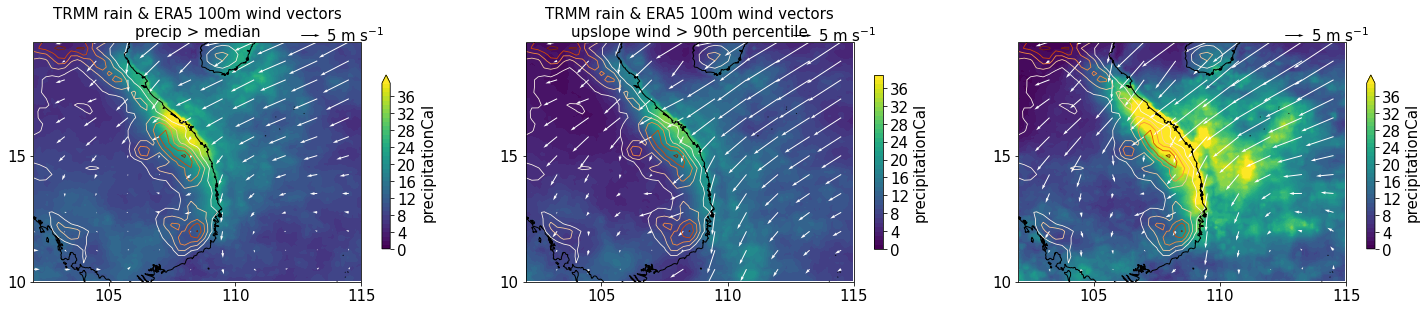

In [30]:
fig,ax = plt.subplots(1,3,figsize=(25,8),subplot_kw={"projection":ccrs.PlateCarree()})
topography_pr_wind_plot(ax[0],Vietnam.box,Vietnam.vars['Z'],Vietnam.vars['GPM_PR_PR50'],Vietnam.vars['VAR_100U_PR50'],Vietnam.vars['VAR_100V_PR50'],np.arange(0,40,1),cbar_kwargs={'shrink':0.4})
topography_pr_wind_plot(ax[1],Vietnam.box,Vietnam.vars['Z'],Vietnam.vars['GPM_PR_U50'], Vietnam.vars['VAR_100U_U50'], Vietnam.vars['VAR_100V_U50'], np.arange(0,40,1),cbar_kwargs={'shrink':0.4})
topography_pr_wind_plot(ax[2],Vietnam.box,Vietnam.vars['Z'],Vietnam.vars['GPM_PR_U90'], Vietnam.vars['VAR_100U_U90'], Vietnam.vars['VAR_100V_U90'], np.arange(0,40,1),cbar_kwargs={'shrink':0.4})
ax[0].set_title("TRMM rain & ERA5 100m wind vectors\nprecip > median",fontsize=15)
ax[1].set_title("TRMM rain & ERA5 100m wind vectors\nupslope wind > median",fontsize=15)
ax[1].set_title("TRMM rain & ERA5 100m wind vectors\nupslope wind > 90th percentile",fontsize=15);None

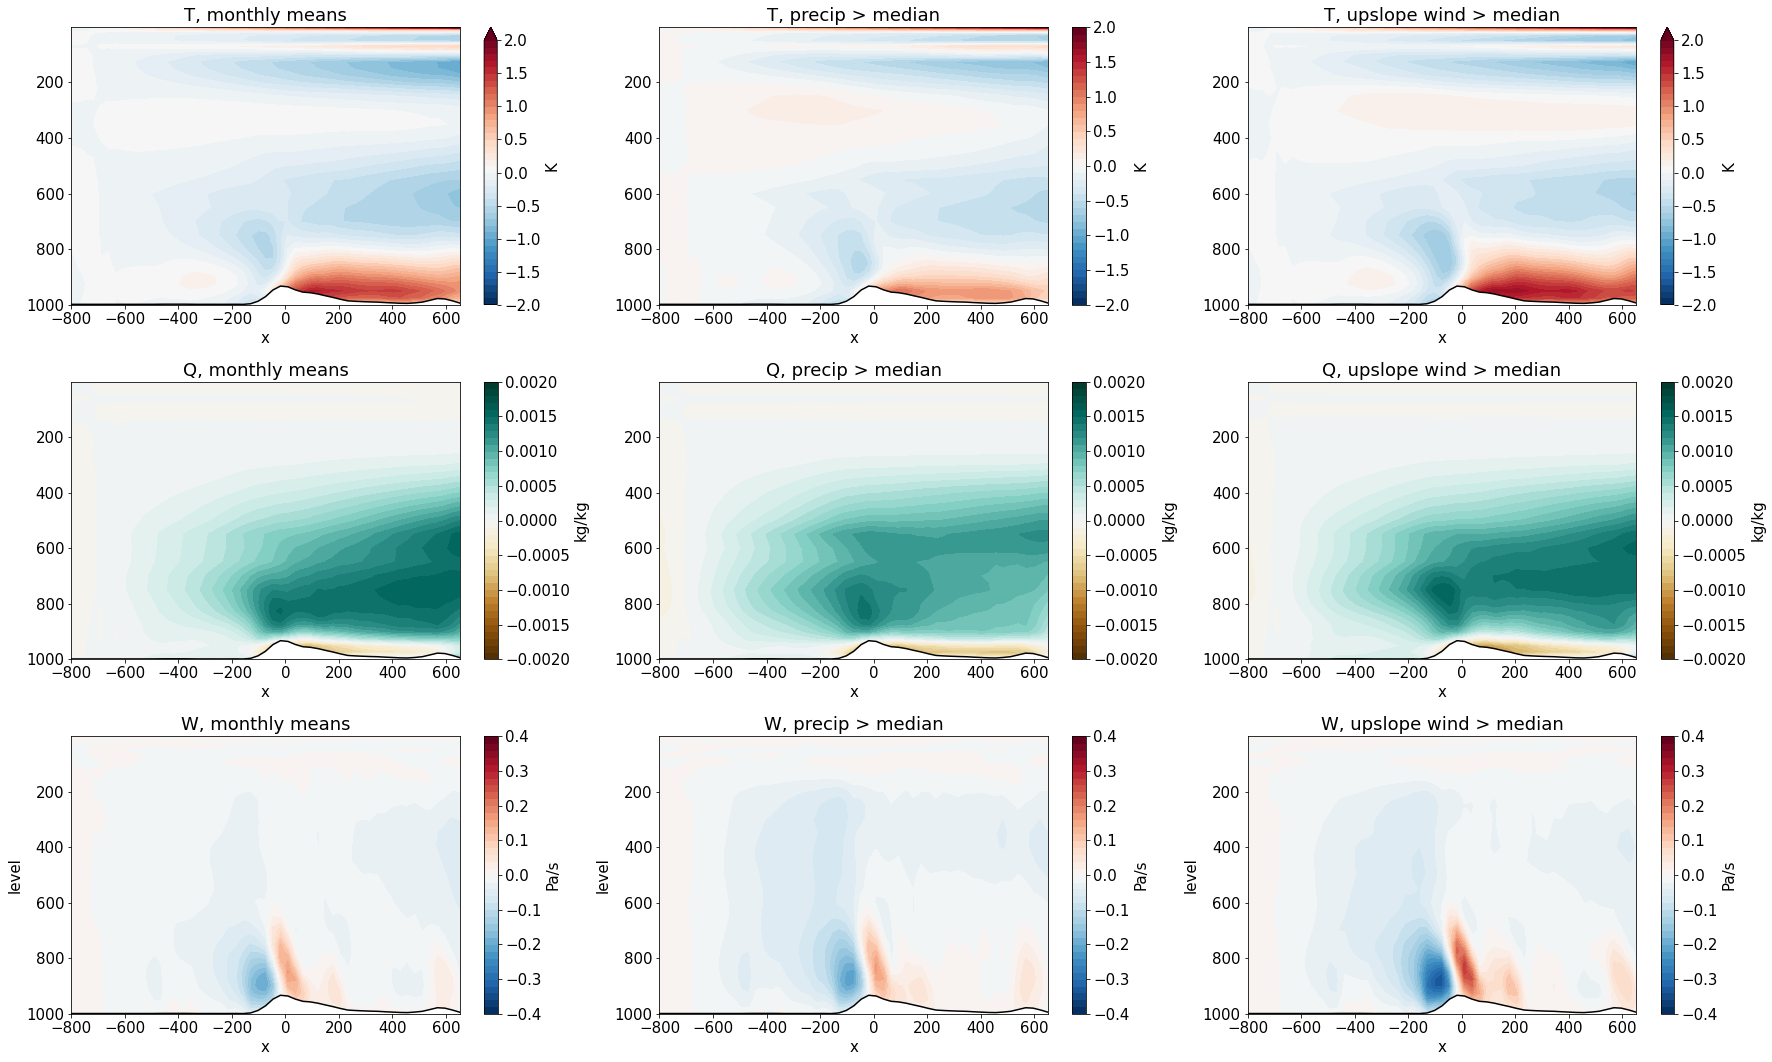

In [31]:
varnames=['T','Q','W']
plunits=['K','kg/kg','Pa/s']
cmaps = [plt.cm.RdBu_r,plt.cm.BrBG,plt.cm.RdBu_r]
scales=[2.,0.002,0.4]
fig,ax=plt.subplots(len(varnames),3,figsize=(25,5*len(varnames)))
for i,(varname,unit,scale,cm) in enumerate(zip(varnames,plunits,scales,cmaps)):
    plot_xz(ax[i,0],Vietnam,varname        ,pert=True,levels=np.linspace(-scale,scale,41),cmap=cm,cbar_kwargs={'label':unit}); ax[i,0].set_title(varname+', monthly means')
    plot_xz(ax[i,1],Vietnam,varname+'_PR50',pert=True,levels=np.linspace(-scale,scale,41),cmap=cm,cbar_kwargs={'label':unit}); ax[i,1].set_title(varname+', precip > median')
    plot_xz(ax[i,2],Vietnam,varname+'_U50' ,pert=True,levels=np.linspace(-scale,scale,41),cmap=cm,cbar_kwargs={'label':unit}); ax[i,2].set_title(varname+', upslope wind > median')
for a in ax[i]:
    a.set_ylabel('level')
    
fig.tight_layout()

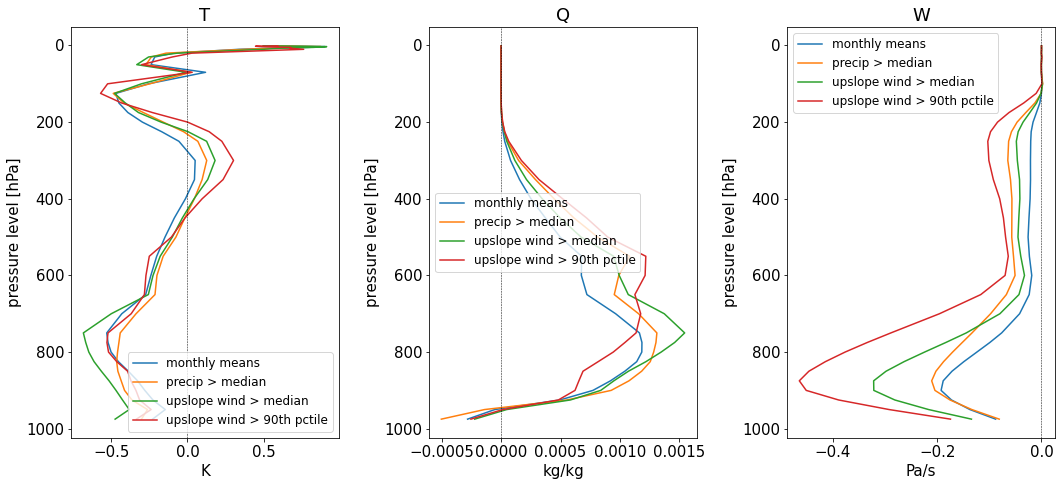

In [32]:
varnames=['T','Q','W']
plunits=['K','kg/kg','Pa/s']
fig,ax=plt.subplots(1,3,figsize=(15,7))
for i,(varname,unit) in enumerate(zip(varnames,plunits)):
    plot_z(ax[i],Vietnam,varname        ,-100,pert=True,label='monthly means')
    plot_z(ax[i],Vietnam,varname+'_PR50',-100,pert=True,label='precip > median')
    plot_z(ax[i],Vietnam,varname+'_U50' ,-100,pert=True,label='upslope wind > median')
    plot_z(ax[i],Vietnam,varname+'_U90' ,-100,pert=True,label='upslope wind > 90th pctile')
    ax[i].set_title(varname)
    ax[i].legend(fontsize=12)
    ax[i].set_xlabel(unit)
    ax[i].axvline(0.,color='k',linestyle='--',linewidth=0.5)
fig.tight_layout()

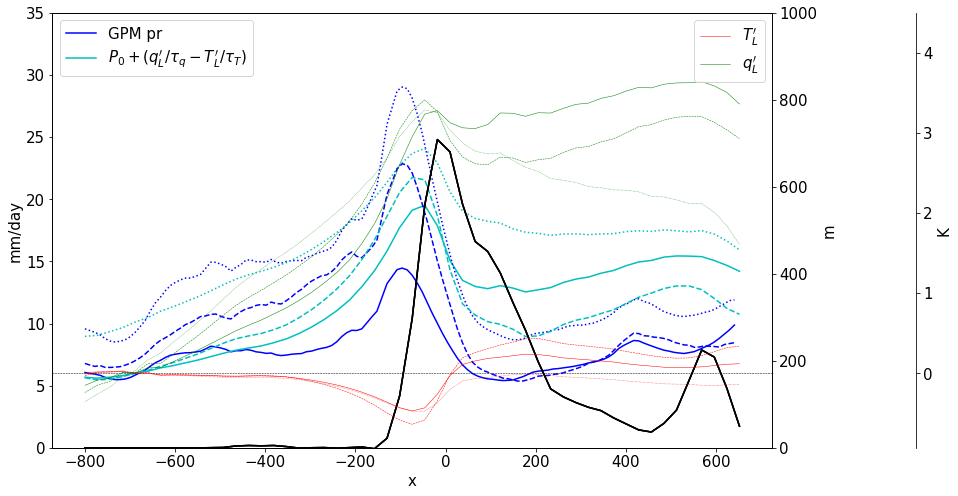

In [16]:
fig,ax = plt.subplots(1,1,figsize=(16,8))
fig.subplots_adjust(right=0.75)
axm=ax.twinx()
axT=ax.twinx()
axT.spines['right'].set_position(("axes", 1.2))

plot_pr_t_q(ax,axm,axT,Vietnam.vars_rot['Z'],Vietnam.vars_rot['GPM_PR'],Vietnam.vars_rot['T'],Vietnam.vars_rot['Q'],lns='-',legend=True)
plot_pr_t_q(ax,axm,axT,Vietnam.vars_rot['Z'],Vietnam.vars_rot['GPM_PR_PR50'],Vietnam.vars_rot['T_PR50'],Vietnam.vars_rot['Q_PR50'],P0=10.,lns=':')
plot_pr_t_q(ax,axm,axT,Vietnam.vars_rot['Z'],Vietnam.vars_rot['GPM_PR_U50' ],Vietnam.vars_rot['T_U50' ],Vietnam.vars_rot['Q_U50' ],P0=6.,lns='--')

ax.axhline(6.,color='k',linewidth=0.5,linestyle='--')

ax.set_ylim(0,35)
axm.set_ylim(0,1000)
axT.set_ylim(-4.5*6/(35-6),4.5)
ax.legend(loc=2)
axT.legend(loc=1)

### CLIMCAPS data

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


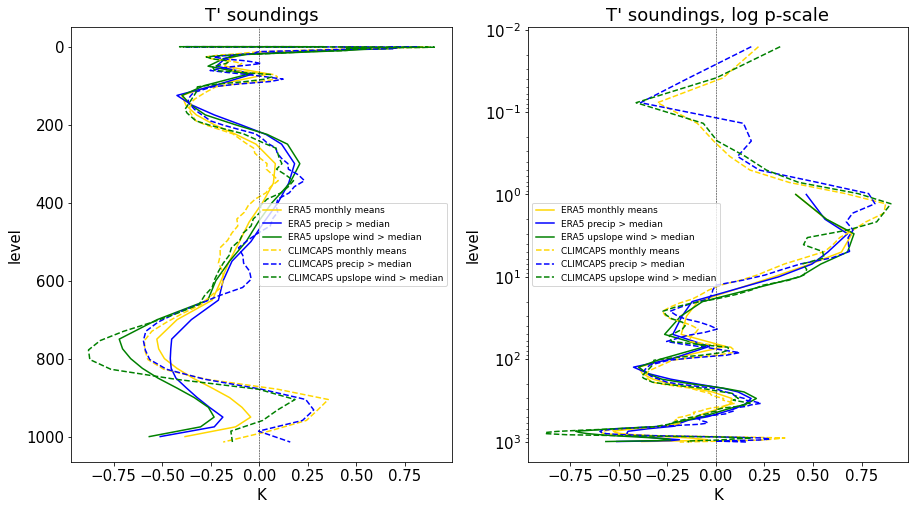

In [35]:
unit = 'K'
fig,axs=plt.subplots(1,2,figsize=(15,8))
for ax in axs:
    plot_z_diff(ax,Vietnam.vars['T']     ,Vietnam.box_upstream,Vietnam.box_above,color='gold' ,label='ERA5 monthly means')
    plot_z_diff(ax,Vietnam.vars['T_PR50'],Vietnam.box_upstream,Vietnam.box_above,color='blue' ,label='ERA5 precip > median')
    plot_z_diff(ax,Vietnam.vars['T_U50'] ,Vietnam.box_upstream,Vietnam.box_above,color='green',label='ERA5 upslope wind > median')
    plot_z_diff(ax,Vietnam.vars['CLIMCAPS_T']     ,Vietnam.box_upstream,Vietnam.box_above,color='gold' ,linestyle='--',label='CLIMCAPS monthly means')
    plot_z_diff(ax,Vietnam.vars['CLIMCAPS_T_PR50'],Vietnam.box_upstream,Vietnam.box_above,color='blue' ,linestyle='--',label='CLIMCAPS precip > median')
    plot_z_diff(ax,Vietnam.vars['CLIMCAPS_T_U50'] ,Vietnam.box_upstream,Vietnam.box_above,color='green',linestyle='--',label='CLIMCAPS upslope wind > median')
    ax.set_title("T' soundings")
    ax.legend(fontsize=9)
    ax.set_xlabel(unit)
    ax.axvline(0.,color='k',linestyle='--',linewidth=0.5)
ax.set_title("T' soundings, log p-scale")
ax.set_yscale('log')

Text(0.5, 1.0, 'U soundings')

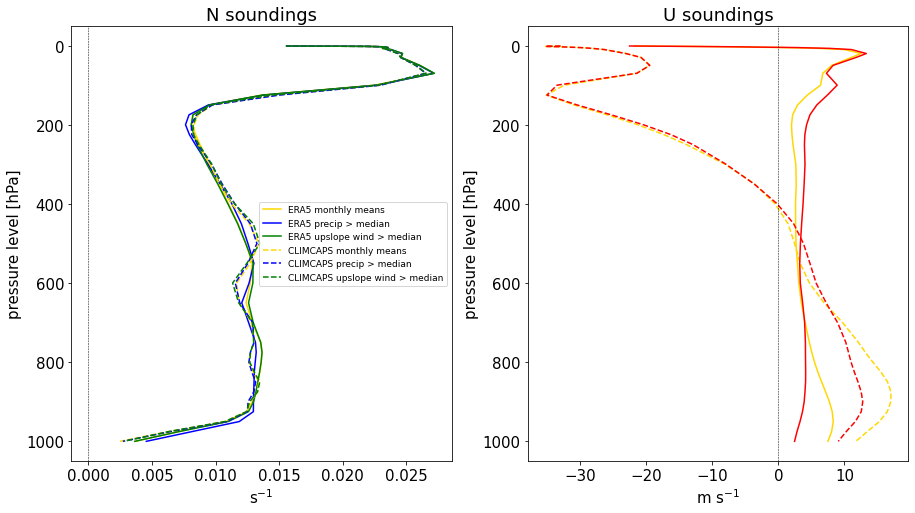

In [46]:

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,8))

compute_N(sel_box_month(Vietnam.vars['T']     ,Vietnam.box_upstream,0).mean(['latitude','longitude']),100,pname='level').plot(ax=ax1,y='level',yincrease=False,color='gold' ,label='ERA5 monthly means')
compute_N(sel_box_month(Vietnam.vars['T_PR50'],Vietnam.box_upstream,0).mean(['latitude','longitude']),100,pname='level').plot(ax=ax1,y='level',yincrease=False,color='blue' ,label='ERA5 precip > median')
compute_N(sel_box_month(Vietnam.vars['T_U50'] ,Vietnam.box_upstream,0).mean(['latitude','longitude']),100,pname='level').plot(ax=ax1,y='level',yincrease=False,color='green',label='ERA5 upslope wind > median')

compute_N(sel_box_month(Ghats.vars['T']     ,Ghats.box_upstream,0).mean(['latitude','longitude']),100,pname='level').plot(ax=ax1,y='level',yincrease=False,color='gold' ,linestyle='--',label='CLIMCAPS monthly means')
compute_N(sel_box_month(Ghats.vars['T_PR50'],Ghats.box_upstream,0).mean(['latitude','longitude']),100,pname='level').plot(ax=ax1,y='level',yincrease=False,color='blue' ,linestyle='--',label='CLIMCAPS precip > median')
compute_N(sel_box_month(Ghats.vars['T_U50'] ,Ghats.box_upstream,0).mean(['latitude','longitude']),100,pname='level').plot(ax=ax1,y='level',yincrease=False,color='green',linestyle='--',label='CLIMCAPS upslope wind > median')

sel_box_month(Vietnam.vars['U_PERP']     ,Vietnam.box_upstream,0).mean(['latitude','longitude']).plot(ax=ax2,y='level',yincrease=False,color='gold' ,label='ERA5 monthly means')
sel_box_month(Ghats.vars['U_PERP']     ,Ghats.box_upstream,0).mean(['latitude','longitude']).plot(ax=ax2,y='level',yincrease=False,color='gold',linestyle='--' ,label='ERA5 monthly means')

sel_box_month(Vietnam.vars['U_PERP']     ,Vietnam.box_above,0).mean(['latitude','longitude']).plot(ax=ax2,y='level',yincrease=False,color='r' ,label='ERA5 monthly means')
sel_box_month(Ghats.vars['U_PERP']     ,Ghats.box_above,0).mean(['latitude','longitude']).plot(ax=ax2,y='level',yincrease=False,color='r',linestyle='--' ,label='ERA5 monthly means')


ax1.legend(fontsize=9)  
ax1.set_xlabel(r's$^{-1}$')
ax1.axvline(0.,color='k',linestyle='--',linewidth=0.5)
ax1.set_title("N soundings")

ax2.set_xlabel(r'm s$^{-1}$')
ax2.axvline(0.,color='k',linestyle='--',linewidth=0.5)
ax2.set_title("U soundings")
#ax2.set_xlim(0,10)


In [36]:
from scipy.integrate import cumtrapz
def linear_Tprime_N(xx,hx,U,N,vert_coord='z'):
    top=15e3
    Nz=100
    
    z=np.linspace(0,top,Nz)
    k=k_vector(len(xx),xx[1]-xx[0])
    h_hat = np.fft.fft(hx)
    
    cp = 1004.;g=9.81
    ds0dz = cp*300/g*N**2

    Tdhat = -ds0dz*h_hat[:,None]*np.exp( m_exponent(k[:,None],N,U)  *  z[None,:]) 
    if vert_coord=='z':
        Td=xr.DataArray(np.real(np.fft.ifft(Tdhat,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':z/1000},dims=['distance_from_mtn','altitude'])
    elif vert_coord=='p':
        p = 1000*np.exp(-9.81/287.*cumtrapz(1/(300-6.5e-3*z),z,initial=0.))
        Td=xr.DataArray(np.real(np.fft.ifft(Tdhat,axis=0)),coords={'distance_from_mtn':xx/1000,'pressure':p},dims=['distance_from_mtn','pressure'])
    return Td/1004.

xx,hx = topographic_profile(kind='cos',a=100e3,A=500)
linear_Td_10  = linear_Tprime_N(xx,hx,10 ,0.010,vert_coord='p').sel(distance_from_mtn=-100)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


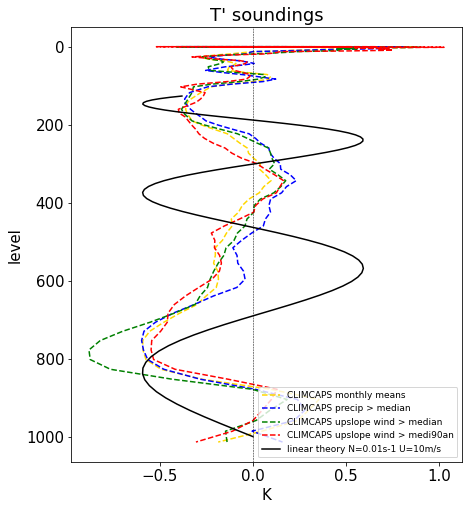

In [37]:
unit = 'K'
fig,ax=plt.subplots(1,1,figsize=(7,8))
plot_z_diff(ax,Vietnam.vars['CLIMCAPS_T']     ,Vietnam.box_upstream,Vietnam.box_above,color='gold' ,linestyle='--',label='CLIMCAPS monthly means')
plot_z_diff(ax,Vietnam.vars['CLIMCAPS_T_PR50'],Vietnam.box_upstream,Vietnam.box_above,color='blue' ,linestyle='--',label='CLIMCAPS precip > median')
plot_z_diff(ax,Vietnam.vars['CLIMCAPS_T_U50'] ,Vietnam.box_upstream,Vietnam.box_above,color='green',linestyle='--',label='CLIMCAPS upslope wind > median')
plot_z_diff(ax,Vietnam.vars['CLIMCAPS_T_U90'] ,Vietnam.box_upstream,Vietnam.box_above,color='r',linestyle='--',label='CLIMCAPS upslope wind > 90th percentile')
ax.plot(linear_Td_10,linear_Td_10.pressure,color='k',label = 'linear theory N=0.01s-1 U=10m/s' )

ax.set_title("T' soundings")
ax.legend(fontsize=9)
ax.set_xlabel(unit)
ax.axvline(0.,color='k',linestyle='--',linewidth=0.5)

# Western ghats

## Data loading

### Monthly

In [11]:
box = [68,80,7.5,17]  
angle = 80
precipitating_month = 7
mountaintop=900. # abscissa of mountain top within rotated frame

box_tilted = [ 75  ,   9  ,  72.5, 16   ,2  ]
box_ref_rce = [68, 69, 11, 14]#[68,69,12,17]            # Small, integer boxes to better assess mtn wave
box_ref_closeupstream = [72,74,11,15]  # Small, integer boxes to better assess mtn wave

Ghats = MountainRange('ghats',box,"Western Ghats",angle,precipitating_month,mountaintop)
Ghats.set_boxes(box_ref_rce,box_ref_closeupstream,box_tilted)

Ghats.set_2dvar('GPM_PR',gpm_pr_seasmean)
Ghats.set_2dvar('E5_PR',era5pr_seasmean)
Ghats.set_2dvar('VAR_100U',era5100u_seasmean)
Ghats.set_2dvar('VAR_100V',era5100v_seasmean)
Ghats.set_2dvar('Z',orogm)
Ghats.set_uperp()

Ghats.set_3dvar('T',"128_130_t")
Ghats.set_3dvar('U',"128_131_u")
Ghats.set_3dvar('V',"128_132_v")
Ghats.set_3dvar('W',"128_135_w")
Ghats.set_3dvar('Q',"128_133_q")
Ghats.set_uperp3d()

Ghats.set_4dvar('T4D',"128_130_t")
Ghats.set_4dvar('Q4D',"128_133_q")
Ghats.set_othervar('GPM_PR_3D',sel_box_month(gpm_pr,Ghats.box,0))

Ghats.set_othervar('E5_PR_3D',sel_box_month(era5pr_monthly,Ghats.box,0))
Ghats.set_othervar('VAR_100U_3D',sel_box_month(era5100u_monthly,Ghats.box,0))
Ghats.set_othervar('VAR_100V_3D',sel_box_month(era5100v_monthly,Ghats.box,0))
Ghats.vars['VAR_100U_3D_PERP'] = crossslopeflow(Ghats.vars['VAR_100U_3D'], Ghats.vars['VAR_100V_3D'],Ghats.angle)
Ghats.vars_rot['VAR_100U_3D_PERP'] = crossslopeflow(Ghats.vars_rot['VAR_100U_3D'], Ghats.vars_rot['VAR_100V_3D'],Ghats.angle)

Ghats.set_othervar('CLIMCAPS_T',sel_box_month(climcapst_climatology,Ghats.box,Ghats.pr_month).assign_coords(level=climcapst_climatology.air_pres/100).swap_dims({'air_pres':'level'}))

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### Daily

In [12]:
era5t_ghats_julhourly = xr.concat((xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.pl.128_130_t.ll025sc.%i07.ghats.zarr"%year) for year in range(2001,2016)),dim='time').T
era5q_ghats_julhourly = xr.concat((xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.pl.128_133_q.ll025sc.%i07.ghats.zarr"%year) for year in range(2001,2016)),dim='time').Q
era5w_ghats_julhourly = xr.concat((xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.pl.128_135_w.ll025sc.%i07.ghats.zarr"%year) for year in range(2001,2016)),dim='time').W
era5100u_ghats_julhourly = xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.sfc.228_246_100u.ll025sc.2001-2015.07.ghats.zarr").VAR_100U
era5100v_ghats_julhourly = xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.sfc.228_247_100v.ll025sc.2001-2015.07.ghats.zarr").VAR_100V
gpmpr_ghats_juldaily = xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/gpm_imerg_v06.2001-2015.07.ghats.zarr").precipitationCal.transpose('time','latitude','longitude')
climcapst_ghats_juldaily = xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/L3_CLIMCAPS_QCC.air_temp.2002-2015.07.ghats.zarr").air_temp
climcapst_ghats_juldaily = climcapst_ghats_juldaily.assign_coords(level=climcapst_ghats_juldaily.air_pres/100).swap_dims({'air_pres':'level'})


In [16]:
precipmask = tilted_rect(gpmpr_ghats_juldaily,*Ghats.box_tilted)*landmask.interp_like(gpmpr_ghats_juldaily)
precipmask_ocean = tilted_rect(gpmpr_ghats_juldaily,*Ghats.box_tilted)*(1-landmask.interp_like(gpmpr_ghats_juldaily))

In [13]:
## PRECIP THRESHOLD
pr_timeseries = spatial_mean(gpmpr_ghats_juldaily,mask=precipmask).load()

## UPSLOPE THRESHOLD

upslopeflow_3d = rotate_var(crossslopeflow(era5100u_ghats_julhourly,era5100v_ghats_julhourly,Ghats.angle),Ghats.angle,Ghats.x_mountaintop,two_dim=False)
upslopeflow_timeseries = crossslope_avg(upslopeflow_3d).sel(x=slice(-400,-200)).mean('x').resample(time='1d').mean()
#upslopeflow_timeseries = upslopeflow_3d.sel(x=slice(-800,-200),y=slice(250,350)).mean(['x','y']).resample(time='1d').mean()
upslopeflow_timeseries = upslopeflow_timeseries.where(upslopeflow_timeseries['time.month']==Ghats.pr_month,drop=True).load()


In [14]:
allvars=[era5t_ghats_julhourly,era5q_ghats_julhourly,era5w_ghats_julhourly,era5100u_ghats_julhourly,era5100v_ghats_julhourly,gpmpr_ghats_juldaily,climcapst_ghats_juldaily]
varnames = ['T','Q','W','VAR_100U','VAR_100V','GPM_PR','CLIMCAPS_T']

In [15]:
## UPSLOPE THRESHOLD

for var,varname in zip(allvars,varnames):
    pctile=50
    Ghats.set_othervar(varname+'_PR%i'%pctile,var.sel(time = timesel(var.time,extreme_days(pr_timeseries,pctile))).mean('time').load())
    Ghats.set_othervar(varname+'_U%i'%pctile,var.sel(time = timesel(var.time,extreme_days(upslopeflow_timeseries,pctile))).mean('time').load())
    pctile=90
    Ghats.set_othervar(varname+'_U%i'%pctile,var.sel(time = timesel(var.time,extreme_days(upslopeflow_timeseries,pctile))).mean('time').load())

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [16]:
climcapst_ghats_juldaily_1pm=climcapst_ghats_juldaily.sel(time=(climcapst_ghats_juldaily['time.hour']==13))
climcapst_ghats_juldaily_1am=climcapst_ghats_juldaily.sel(time=(climcapst_ghats_juldaily['time.hour']==1))

Ghats.set_othervar('CLIMCAPS_T_1AM',sel_box_month(climcapst_climatology_night,Ghats.box,Ghats.pr_month).assign_coords(level=climcapst_climatology.air_pres/100).swap_dims({'air_pres':'level'}))
Ghats.set_othervar('CLIMCAPS_T_1PM',sel_box_month(climcapst_climatology_aft,Ghats.box,Ghats.pr_month).assign_coords(level=climcapst_climatology.air_pres/100).swap_dims({'air_pres':'level'}))

allvars=[climcapst_ghats_juldaily_1am,climcapst_ghats_juldaily_1pm]
varnames = ['CLIMCAPS_T_1AM','CLIMCAPS_T_1PM']

## UPSLOPE THRESHOLD
for var,varname in zip(allvars,varnames):
    pctile=50
    Ghats.set_othervar(varname+'_PR%i'%pctile,var.sel(time = timesel(var.time,extreme_days(pr_timeseries,pctile))).mean('time').load())
    Ghats.set_othervar(varname+'_U%i'%pctile,var.sel(time = timesel(var.time,extreme_days(upslopeflow_timeseries,pctile))).mean('time').load())
    pctile=90
    Ghats.set_othervar(varname+'_U%i'%pctile,var.sel(time = timesel(var.time,extreme_days(upslopeflow_timeseries,pctile))).mean('time').load())

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-pack

## Monthly means

### Maps

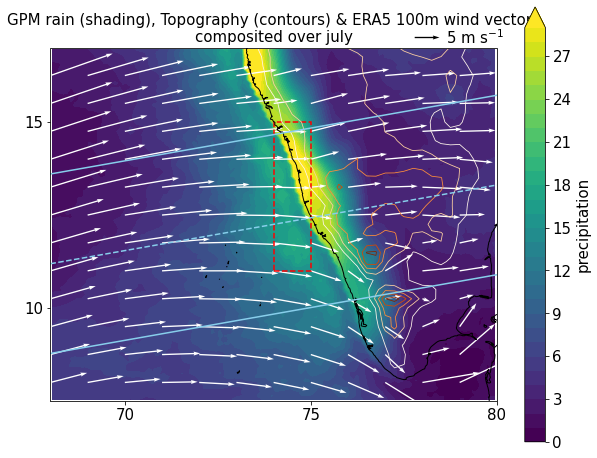

In [192]:
fig,ax = plt.subplots(1,1,figsize=(10,8),subplot_kw={"projection":ccrs.PlateCarree()})
topography_pr_wind_plot(ax,Ghats.box,Ghats.vars['Z'],Ghats.vars['GPM_PR'],Ghats.vars['VAR_100U'],Ghats.vars['VAR_100V'],np.arange(0,30,1))

#Boxes
for smallbox,clr in (([74,75,11,15],'r'),):
    ax.add_patch(mpatches.Rectangle(xy=[smallbox[0], smallbox[2]], width=smallbox[1]-smallbox[0], height=smallbox[3]-smallbox[2],
                                       edgecolor=clr,
                                       fill = False,
                                       lw=1.5,
                                       linestyle='--',
                                       transform=ccrs.PlateCarree())
                    )
#precipmask.plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['w'])
#
#precipmask_ocean.plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['r'])
#
#box_tilted2 = [ 71  ,   9  ,  69.5, 14   ,2  ]
#tilted_rect(gpmpr_ghats_juldaily,*box_tilted2,reverse=True).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['y'])
#tilted_rect(gpmpr_ghats_juldaily,*Ghats.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['r'])

alpha = np.tan(np.pi/2-np.pi*Ghats.angle/180)
x0,x1=box[0],box[1]; xm=(x0+x1)/2
y0,y1=box[2],box[3]; ym=(y0+y1)/2
fx = np.array([ym + alpha*(x0-xm),ym + alpha*(x1-xm)])
ax.plot([x0,x1],fx,color='skyblue',linestyle='--')
ax.plot([x0,x1],fx-(y1-y0)/4/np.cos(alpha),color='skyblue',linestyle='-')
ax.plot([x0,x1],fx+(y1-y0)/4/np.cos(alpha),color='skyblue',linestyle='-')

#dx = alpha*(y1-y0)/4
#xu1 = xm + 700/111 * np.cos(np.arctan(alpha))
#xu2 = xm + 500/111 * np.cos(np.arctan(alpha))
#for xa in xm,xu1,xu2:
#    ax.plot([xa-dx,xa+dx],[ym + alpha*(xa-xm)+dx/alpha,ym + alpha*(xa-xm)-dx/alpha],color='skyblue',linestyle='-')


ax.set_title("GPM rain (shading), Topography (contours) & ERA5 100m wind vectors\ncomposited over july",fontsize=15);None



Text(0.5, 1.0, 'Perturbation q climatology (nondim)')

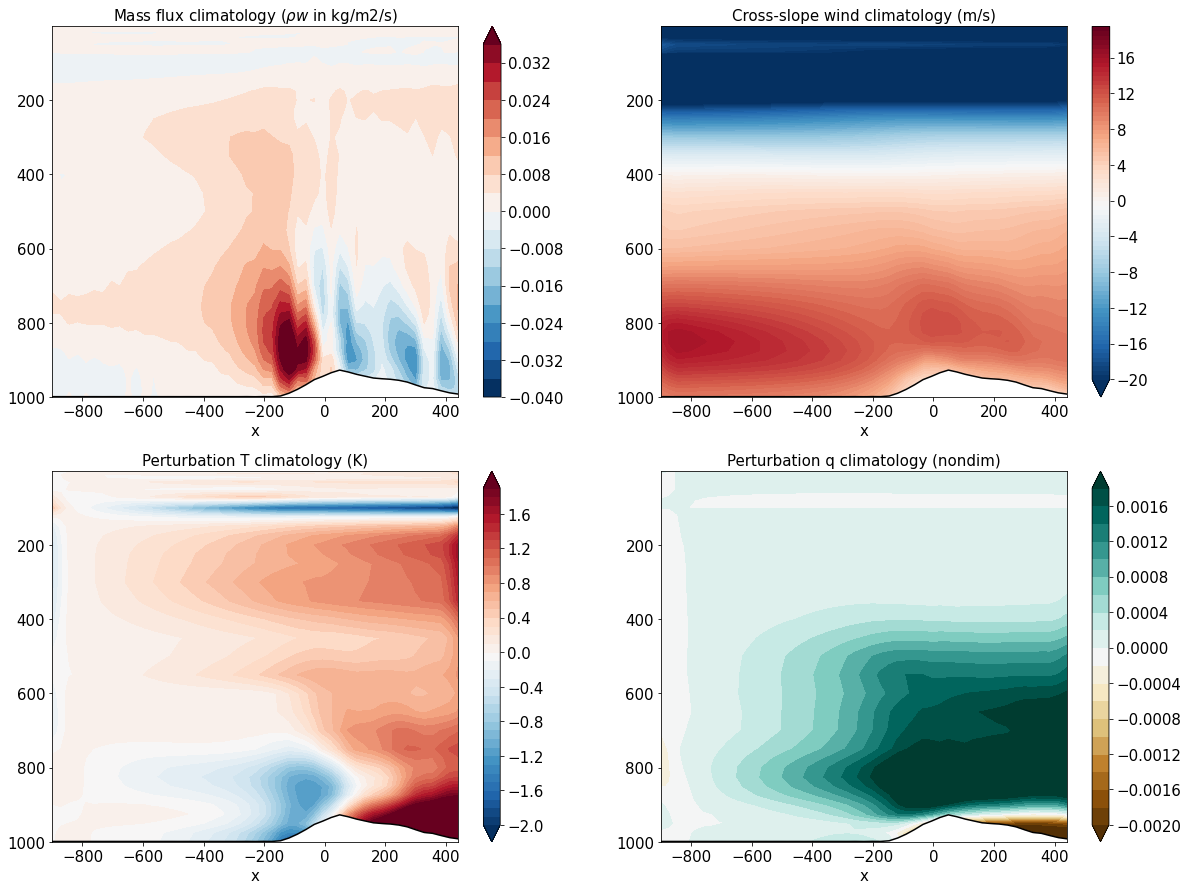

In [41]:
fig,ax = plt.subplots(2,2,figsize=(20,15))
ax=ax.reshape(-1)
plot_xz(ax[0],Ghats,'W',levels=np.arange(-0.04,0.04,0.004),fact=-1/9.81)
plot_xz(ax[1],Ghats,'U_PERP',levels=np.arange(-20,20,0.5))
plot_xz(ax[2],Ghats,'T',pert=True,levels=np.arange(-2,2,0.1))
plot_xz(ax[3],Ghats,'Q',pert=True,levels=np.arange(-0.002,0.002,0.0002),cmap=plt.cm.BrBG)

ax[0].set_title(r'Mass flux climatology ($\rho w$ in kg/m2/s)',fontsize=15)
ax[1].set_title(r'Cross-slope wind climatology (m/s)',fontsize=15)
ax[2].set_title(r'Perturbation T climatology (K)',fontsize=15)
ax[3].set_title(r'Perturbation q climatology (nondim)',fontsize=15)

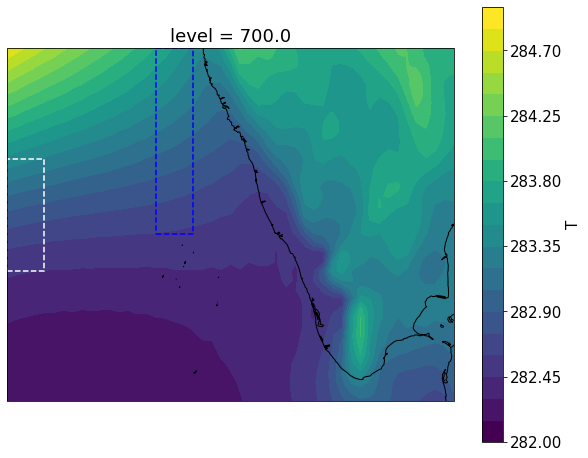

In [12]:
fig,ax = plt.subplots(1,1,figsize=(10,8),subplot_kw={"projection":ccrs.PlateCarree()})
Ghats.vars['T'].sel(level=700).plot.contourf(ax=ax,levels=np.linspace(282,285,21),transform=ccrs.PlateCarree())
ax.coastlines()
Ghats.box_upstream = [68, 69, 11, 14]
for smallbox,clr in ((Ghats.box_upstream,'w'),(Ghats.box_above,'b')):
    ax.add_patch(mpatches.Rectangle(xy=[smallbox[0], smallbox[2]], width=smallbox[1]-smallbox[0], height=smallbox[3]-smallbox[2],
                                       edgecolor=clr,
                                       fill = False,
                                       lw=1.5,
                                       linestyle='--',
                                       transform=ccrs.PlateCarree())
                    )

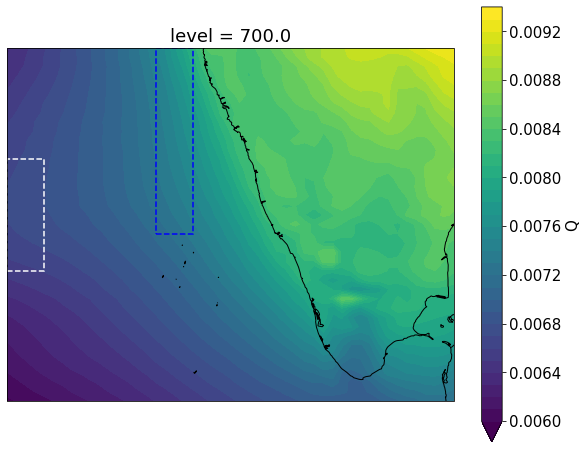

In [18]:
fig,ax = plt.subplots(1,1,figsize=(10,8),subplot_kw={"projection":ccrs.PlateCarree()})
Ghats.vars['Q'].sel(level=700).plot.contourf(ax=ax,levels=np.arange(6e-3,9.5e-3,1e-4),transform=ccrs.PlateCarree())
ax.coastlines()
Ghats.box_upstream = [68, 69, 11, 14]
for smallbox,clr in ((Ghats.box_upstream,'w'),(Ghats.box_above,'b')):
    ax.add_patch(mpatches.Rectangle(xy=[smallbox[0], smallbox[2]], width=smallbox[1]-smallbox[0], height=smallbox[3]-smallbox[2],
                                       edgecolor=clr,
                                       fill = False,
                                       lw=1.5,
                                       linestyle='--',
                                       transform=ccrs.PlateCarree())
                    )

### Nonlinear theory

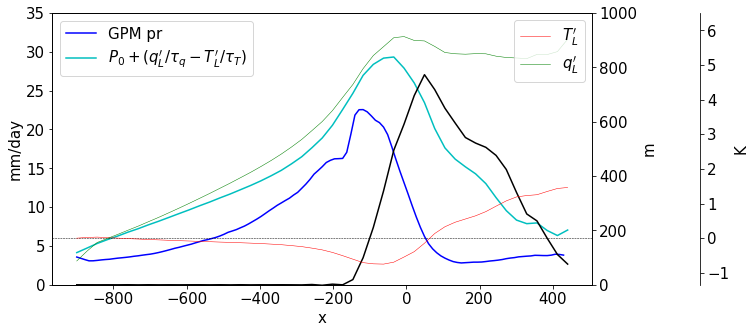

In [42]:
fig,ax = plt.subplots(1,1,figsize=(12,5))
fig.subplots_adjust(right=0.75)
axm=ax.twinx()
axT=ax.twinx()
axT.spines['right'].set_position(("axes", 1.2))

plot_pr_t_q(ax,axm,axT,Ghats.vars_rot['Z'],Ghats.vars_rot['GPM_PR'],Ghats.vars_rot['T'],Ghats.vars_rot['Q'],lns='-',legend=True)

ax.axhline(6.,color='k',linewidth=0.5,linestyle='--')

ax.set_ylim(0,35)
axm.set_ylim(0,1000)
axT.set_ylim(-6.5*6/(35-6),6.5)
ax.legend(loc=2)
axT.legend(loc=1)

In [110]:
TLprimes = compute_primes(Ghats,'T4D')
qLprimes = compute_primes(Ghats,'Q4D')
nonlin_pr_allmonths = pT_ov_g * (-TLprimes/tauT + qLprimes/tauq)*cp/ Lc * 86400
gpm_pprime_allmonths    = compute_primes(Ghats,'GPM_PR_3D')
e5_pprime_allmonths     = compute_primes(Ghats,'E5_PR_3D' )
gpm_pr_allmonths    = Ghats.vars_rot['GPM_PR_3D'].sel(x=slice(-200,-50)).mean(['x','y'])
e5_pr_allmonths     = Ghats.vars_rot['E5_PR_3D' ].sel(x=slice(-200,-50)).mean(['x','y'])
uperp100_allmonths    = Ghats.vars_rot['VAR_100U_3D_PERP'].sel(x=slice(-200,-50)).mean(['x','y'])


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0.98, "P' vs $(q_L'/\\tau_q - T_L'/\\tau_T)$")

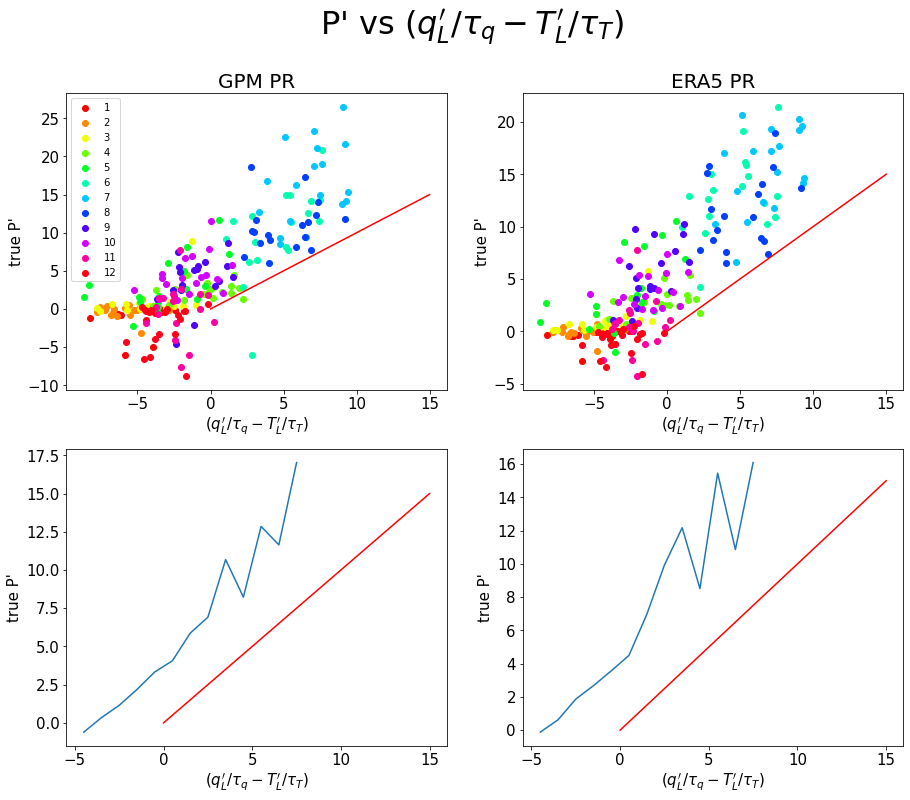

In [114]:
fig,ax = plt.subplots(2,2,figsize=(15,12))
colors=plt.cm.hsv(np.linspace(0,1,12))
for m in range(12):
    ax[0,0].scatter(sel_month(nonlin_pr_allmonths,m+1),sel_month(gpm_pprime_allmonths,m+1),color=colors[m],label=m+1)
    ax[0,1].scatter(sel_month(nonlin_pr_allmonths,m+1),sel_month(e5_pprime_allmonths ,m+1),color=colors[m],label=m+1)

ax[1,0].plot(*get_binned(nonlin_pr_allmonths,gpm_pprime_allmonths,np.arange(-5,15,1)))
ax[1,1].plot(*get_binned(nonlin_pr_allmonths,e5_pprime_allmonths,np.arange(-5,15,1)))

ax[0,0].set_title('GPM PR' ,fontsize=20)
ax[0,1].set_title('ERA5 PR',fontsize=20)
for a in ax.reshape(-1):
    a.set_ylabel("true P'")
    a.set_xlabel(r"$(q_L'/\tau_q - T_L'/\tau_T)$")
    a.plot([0,15],[0,15],color='r')
ax[0,0].legend(loc=2,fontsize=10)
fig.suptitle(r"P' vs $(q_L'/\tau_q - T_L'/\tau_T)$",fontsize=32)

In [22]:
BL_allmonths=BL_plevs(Ghats.vars_rot['T4D'],Ghats.vars_rot['Q4D'],700.).sel(x=slice(-200,-50)).mean(['x','y'])

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/numpy_func.py:289: RuntimeWarning: invalid value encountered in log
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/quantity.py:1393: RuntimeWarning: invalid value encountered in power
  return other ** new_self._magnitude
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:1067: RuntimeWarning: overflow encountered in exp
  th_es = th_l * np.exp((3036. / t - 1.78) * r * (1 + 0.448 * r))
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:1067: RuntimeWarning: overflow encountered in multiply
  th_es = th_l * np.exp((3036. / t - 1.78) * r * (1 + 0.448 * r))


Text(0.5, 0.98, "Ahmed's $B_L$, fixed $\\theta_{eb}$ vs U")

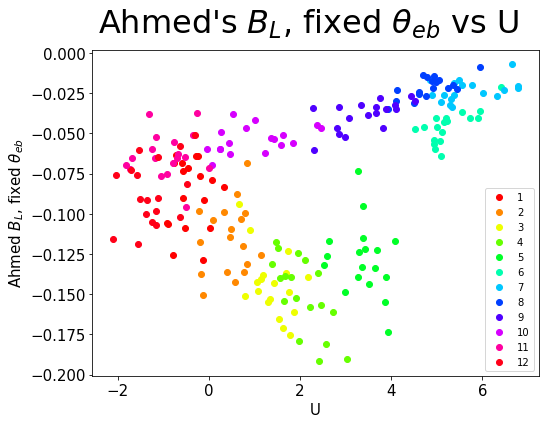

In [118]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
colors=plt.cm.hsv(np.linspace(0,1,12))
for m in range(12):
    ax.scatter(sel_month(uperp100_allmonths,m+1),sel_month(BL_allmonths_fixedthetaeb,m+1),color=colors[m],label=m+1)

ax.set_xlabel("U")
ax.set_ylabel(r"Ahmed $B_L$, fixed $\theta_{eb}$")
ax.legend(loc=4,fontsize=10)
fig.suptitle(r"Ahmed's $B_L$, fixed $\theta_{eb}$ vs U",fontsize=32)

Text(0.5, 0.98, "P' vs Ahmed's $B_L$")

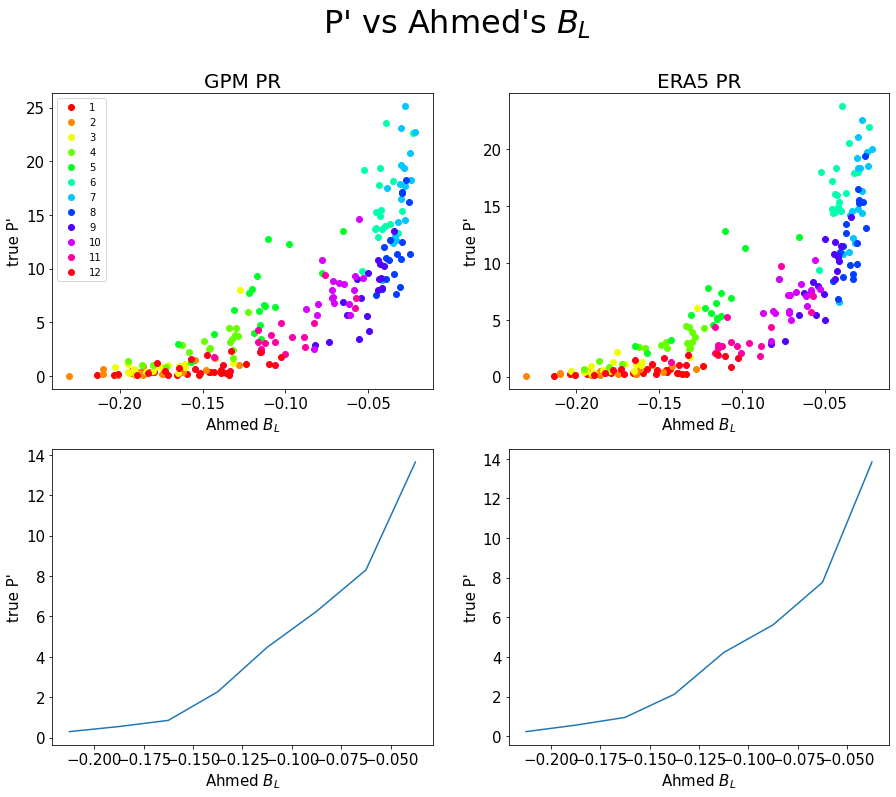

In [115]:
fig,ax = plt.subplots(2,2,figsize=(15,12))
colors=plt.cm.hsv(np.linspace(0,1,12))
for m in range(12):
    ax[0,0].scatter(sel_month(BL_allmonths,m+1),sel_month(gpm_pr_allmonths,m+1),color=colors[m],label=m+1)
    ax[0,1].scatter(sel_month(BL_allmonths,m+1),sel_month( e5_pr_allmonths ,m+1),color=colors[m],label=m+1)

ax[1,0].plot(*get_binned(BL_allmonths,gpm_pr_allmonths,np.arange(-0.3,0.1,0.025)))
ax[1,1].plot(*get_binned(BL_allmonths, e5_pr_allmonths,np.arange(-0.3,0.1,0.025)))

ax[0,0].set_title('GPM PR' ,fontsize=20)
ax[0,1].set_title('ERA5 PR',fontsize=20)
for a in ax.reshape(-1):
    a.set_ylabel("true P'")
    a.set_xlabel(r"Ahmed $B_L$")
    #a.plot([0,15],[0,15],color='r')
ax[0,0].legend(loc=2,fontsize=10)
fig.suptitle(r"P' vs Ahmed's $B_L$",fontsize=32)

Text(0.5, 1.0, "Pr vs Ahmed's $B_L$")

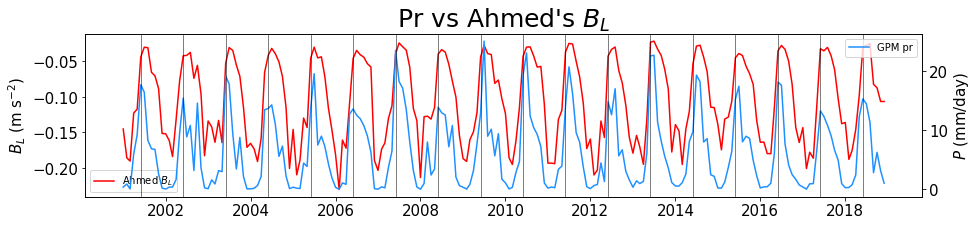

In [199]:
plt.figure(figsize=(15,3))
plt.plot(BL_allmonths.time,BL_allmonths,color='r',label=r'Ahmed $B_L$')
plt.legend(fontsize=10)
plt.ylabel(r"$B_L$ (m s$^{-2}$)")
plt.twinx()
plt.plot(BL_allmonths.time,gpm_pr_allmonths,color='dodgerblue',label='GPM pr')
plt.ylabel(r"$P$ (mm/day)")
plt.legend(fontsize=10)
for i in range(5,220,12):
    plt.axvline(BL_allmonths.time[i].values,color='k',linewidth=0.5)
plt.legend(fontsize=10)
plt.title(r"Pr vs Ahmed's $B_L$",fontsize=25)


Text(0, 0.5, 'mm/day')

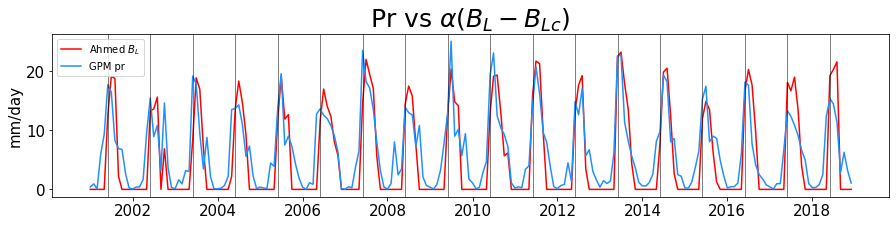

In [201]:
plt.figure(figsize=(15,3))
plt.plot(BL_allmonths.time,np.maximum((BL_allmonths+0.07)*480,0.),color='r',label=r'Ahmed $B_L$')
plt.plot(BL_allmonths.time,gpm_pr_allmonths,color='dodgerblue',label='GPM pr')
for i in range(5,220,12):
    plt.axvline(BL_allmonths.time[i].values,color='k',linewidth=0.5)
plt.legend(fontsize=10)
plt.title(r"Pr vs $\alpha(B_L-B_{Lc})$",fontsize=25)
plt.ylabel('mm/day')

Text(0.5, 1.0, "P' vs $(q_L'/\\tau_q - T_L'/\\tau_T)$")

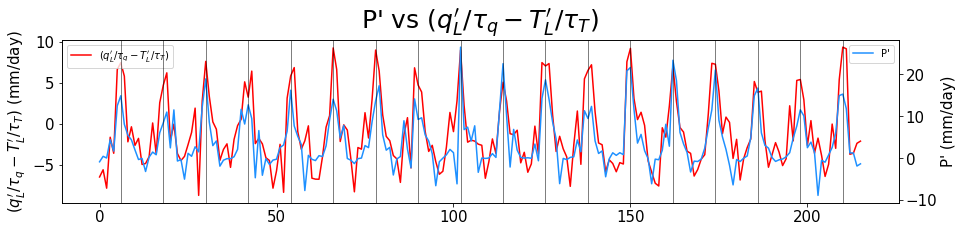

In [208]:
plt.figure(figsize=(15,3))
plt.plot(nonlin_pr_allmonths,color='r',label=r"$(q_L'/\tau_q - T_L'/\tau_T)$")
plt.ylabel(r"$(q_L'/\tau_q - T_L'/\tau_T)$ (mm/day)")
plt.legend(fontsize=10,loc=2)
plt.twinx()

plt.plot(gpm_pprime_allmonths,color='dodgerblue',label="P'")
plt.ylabel("P' (mm/day)")
plt.legend(fontsize=10)
for i in range(6,220,12):
    plt.axvline(i,color='k',linewidth=0.5)
    
plt.title(r"P' vs $(q_L'/\tau_q - T_L'/\tau_T)$",fontsize=25)

Text(0.5, 0.98, "Pr vs Ahmed's $B_L$, fixed $\\theta_{eb}$")

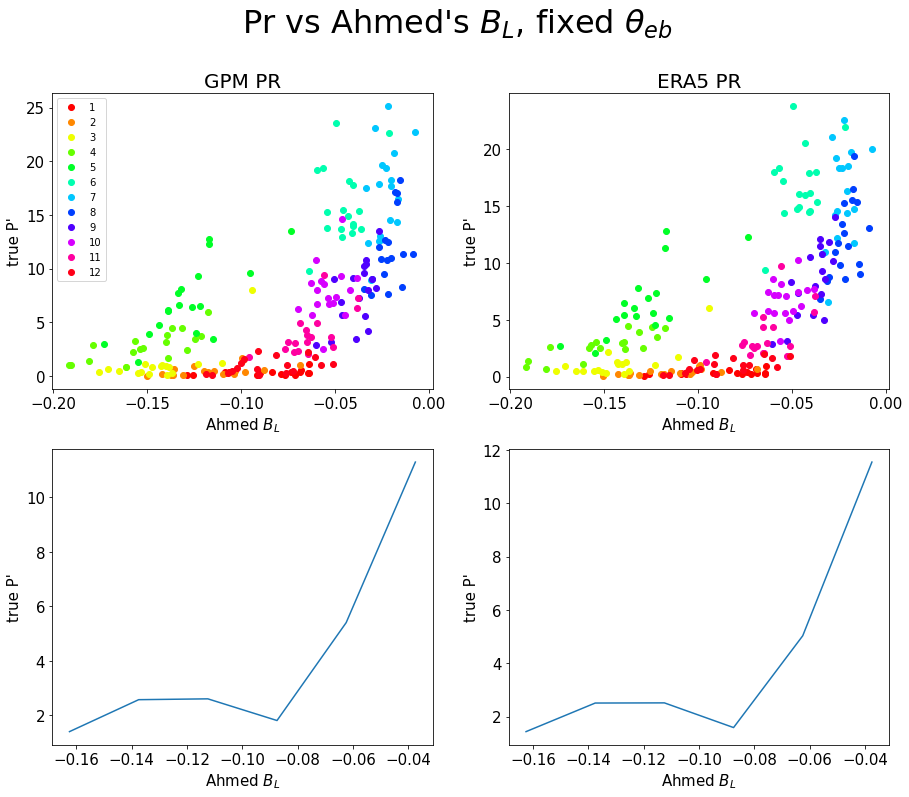

In [117]:
fig,ax = plt.subplots(2,2,figsize=(15,12))
colors=plt.cm.hsv(np.linspace(0,1,12))
for m in range(12):
    ax[0,0].scatter(sel_month(BL_allmonths_fixedthetaeb,m+1),sel_month(gpm_pr_allmonths,m+1),color=colors[m],label=m+1)
    ax[0,1].scatter(sel_month(BL_allmonths_fixedthetaeb,m+1),sel_month( e5_pr_allmonths ,m+1),color=colors[m],label=m+1)

ax[1,0].plot(*get_binned(BL_allmonths_fixedthetaeb,gpm_pr_allmonths,np.arange(-0.3,0.1,0.025)))
ax[1,1].plot(*get_binned(BL_allmonths_fixedthetaeb, e5_pr_allmonths,np.arange(-0.3,0.1,0.025)))

ax[0,0].set_title('GPM PR' ,fontsize=20)
ax[0,1].set_title('ERA5 PR',fontsize=20)
for a in ax.reshape(-1):
    a.set_ylabel("true P'")
    a.set_xlabel(r"Ahmed $B_L$")
    #a.plot([0,15],[0,15],color='r')
ax[0,0].legend(loc=2,fontsize=10)
fig.suptitle(r"Pr vs Ahmed's $B_L$, fixed $\theta_{eb}$",fontsize=32)

Text(0.5, 0.98, "P' vs $U_{100}^\\perp$")

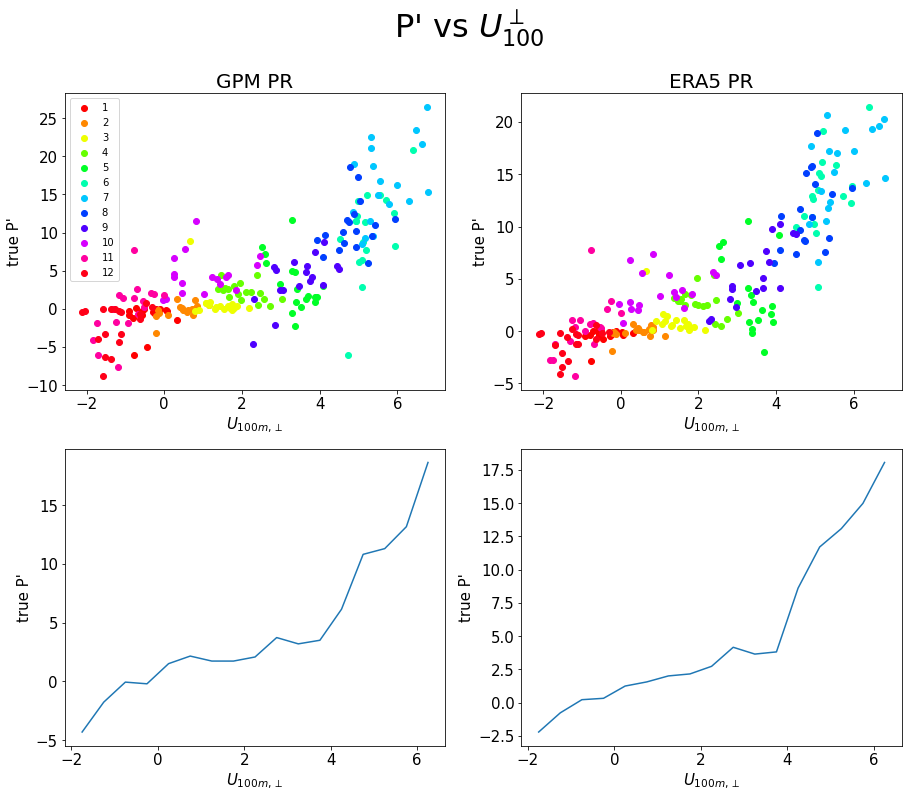

In [80]:
fig,ax = plt.subplots(2,2,figsize=(15,12))
colors=plt.cm.hsv(np.linspace(0,1,12))
for m in range(12):
    ax[0,0].scatter(sel_month(uperp100_allmonths,m+1),sel_month(gpm_pr_allmonths,m+1),color=colors[m],label=m+1)
    ax[0,1].scatter(sel_month(uperp100_allmonths,m+1),sel_month(e5_pr_allmonths ,m+1),color=colors[m],label=m+1)

ax[1,0].plot(*get_binned(uperp100_allmonths,gpm_pr_allmonths,np.arange(-3,7,0.5)))
ax[1,1].plot(*get_binned(uperp100_allmonths,e5_pr_allmonths,np.arange(-3,7,0.5)))

ax[0,0].set_title('GPM PR' ,fontsize=20)
ax[0,1].set_title('ERA5 PR',fontsize=20)
for a in ax.reshape(-1):
    a.set_ylabel("true P'")
    a.set_xlabel(r"$U_{100m,\perp}$")
    #a.plot([0,15],[0,15],color='r')
ax[0,0].legend(loc=2,fontsize=10)
fig.suptitle(r"P' vs $U_{100}^\perp$",fontsize=32)

### scatterplots with boxes

In [147]:
%%time
boxtest = [74,75,11,15]
mask = 1.*tilted_rect(gpmpr_ghats_juldaily,*Ghats.box_tilted)
mask_era5 = mask.interp_like(Ghats.vars['E5_PR_3D'][0])

BL_allmonths_box       = BL_plevs(Ghats.vars['T4D'],Ghats.vars['Q4D'],700.).where(mask_era5).mean(['latitude','longitude'])
gpm_pr_allmonths_box   = Ghats.vars['GPM_PR_3D'].where(mask).mean(['latitude','longitude']).load()
e5_pr_allmonths_box    = Ghats.vars['E5_PR_3D'].where(mask_era5).mean(['latitude','longitude']).load()
uperp100_allmonths_box = Ghats.vars['VAR_100U_3D_PERP'].where(mask_era5).mean(['latitude','longitude']).load()

#BL_allmonths_box       = sel_box_month(BL_plevs(Ghats.vars['T4D'],Ghats.vars['Q4D'],700.),boxtest,0).mean(['latitude','longitude'])
#gpm_pr_allmonths_box   = sel_box_month(Ghats.vars['GPM_PR_3D']                           ,boxtest,0).mean(['latitude','longitude']).load()
#e5_pr_allmonths_box    = sel_box_month(Ghats.vars['E5_PR_3D']                            ,boxtest,0).mean(['latitude','longitude']).load()
#uperp100_allmonths_box = sel_box_month(Ghats.vars['VAR_100U_3D_PERP']                    ,boxtest,0).mean(['latitude','longitude']).load()



/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/numpy_func.py:289: RuntimeWarning: invalid value encountered in log
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/quantity.py:1393: RuntimeWarning: invalid value encountered in power
  return other ** new_self._magnitude
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:1067: RuntimeWarning: overflow encountered in exp
  th_es = th_l * np.exp((3036. / t - 1.78) * r * (1 + 0.448 * r))
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:1067: RuntimeWarning: overflow encountered in multiply
  th_es = th_l * np.exp((3036. / t - 1.78) * r * (1 + 0.448 * r))


CPU times: user 10.6 s, sys: 5.94 s, total: 16.6 s
Wall time: 21.6 s


In [163]:
BL_fixedtb_allmonths_box       = BL_plevs(Ghats.vars['T4D'],Ghats.vars['Q4D'],700.,fixed_thetaeb=True).where(mask_era5).mean(['latitude','longitude'])


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/numpy_func.py:289: RuntimeWarning: invalid value encountered in log
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/quantity.py:1393: RuntimeWarning: invalid value encountered in power
  return other ** new_self._magnitude
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:1067: RuntimeWarning: overflow encountered in exp
  th_es = th_l * np.exp((3036. / t - 1.78) * r * (1 + 0.448 * r))
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:1067: RuntimeWarning: overflow encountered in multiply
  th_es = th_l * np.exp((3036. / t - 1.78) * r * (1 + 0.448 * r))


In [169]:
box_tilted2 = [ 71  ,   9  ,  69.5, 14   ,2  ]
mask = 1.*tilted_rect(gpmpr_ghats_juldaily,*box_tilted2)
mask_era5 = mask.interp_like(Ghats.vars['E5_PR_3D'][0])
BL_allmonths_boxups         = BL_plevs(Ghats.vars['T4D'],Ghats.vars['Q4D'],700.).where(mask_era5).mean(['latitude','longitude'])
BL_fixedtb_allmonths_boxups = BL_plevs(Ghats.vars['T4D'],Ghats.vars['Q4D'],700.,fixed_thetaeb=True).where(mask_era5).mean(['latitude','longitude'])


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/numpy_func.py:289: RuntimeWarning: invalid value encountered in log
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/quantity.py:1393: RuntimeWarning: invalid value encountered in power
  return other ** new_self._magnitude
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:1067: RuntimeWarning: overflow encountered in exp
  th_es = th_l * np.exp((3036. / t - 1.78) * r * (1 + 0.448 * r))
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:1067: RuntimeWarning: overflow encountered in multiply
  th_es = th_l * np.exp((3036. / t - 1.78) * r * (1 + 0.448 * r))
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/numpy_func.py:289: RuntimeWarning: invalid value encountered in log
  result_magnitude = func(*stripped_args, **stripped

In [62]:
%%time 
BL_allmonths=BL_plevs(Ghats.vars_rot['T4D'],Ghats.vars_rot['Q4D'],700.).sel(x=slice(-200,-50)).mean(['x','y'])
gpm_pprime_allmonths    = compute_primes(Ghats,'GPM_PR_3D')
e5_pprime_allmonths     = compute_primes(Ghats,'E5_PR_3D' )
gpm_pr_allmonths    = Ghats.vars_rot['GPM_PR_3D'].sel(x=slice(-200,-50)).mean(['x','y'])
e5_pr_allmonths     = Ghats.vars_rot['E5_PR_3D' ].sel(x=slice(-200,-50)).mean(['x','y'])
uperp100_allmonths    = Ghats.vars_rot['VAR_100U_3D_PERP'].sel(x=slice(-200,-50)).mean(['x','y'])


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/numpy_func.py:289: RuntimeWarning: invalid value encountered in log
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/quantity.py:1393: RuntimeWarning: invalid value encountered in power
  return other ** new_self._magnitude
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:1067: RuntimeWarning: overflow encountered in exp
  th_es = th_l * np.exp((3036. / t - 1.78) * r * (1 + 0.448 * r))
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:1067: RuntimeWarning: overflow encountered in multiply
  th_es = th_l * np.exp((3036. / t - 1.78) * r * (1 + 0.448 * r))


CPU times: user 11.8 s, sys: 7.03 s, total: 18.8 s
Wall time: 17.2 s


Text(0.5, 0.98, "GPM Pr vs Ahmed's $B_L$ and $U_{100m,\\perp}$")

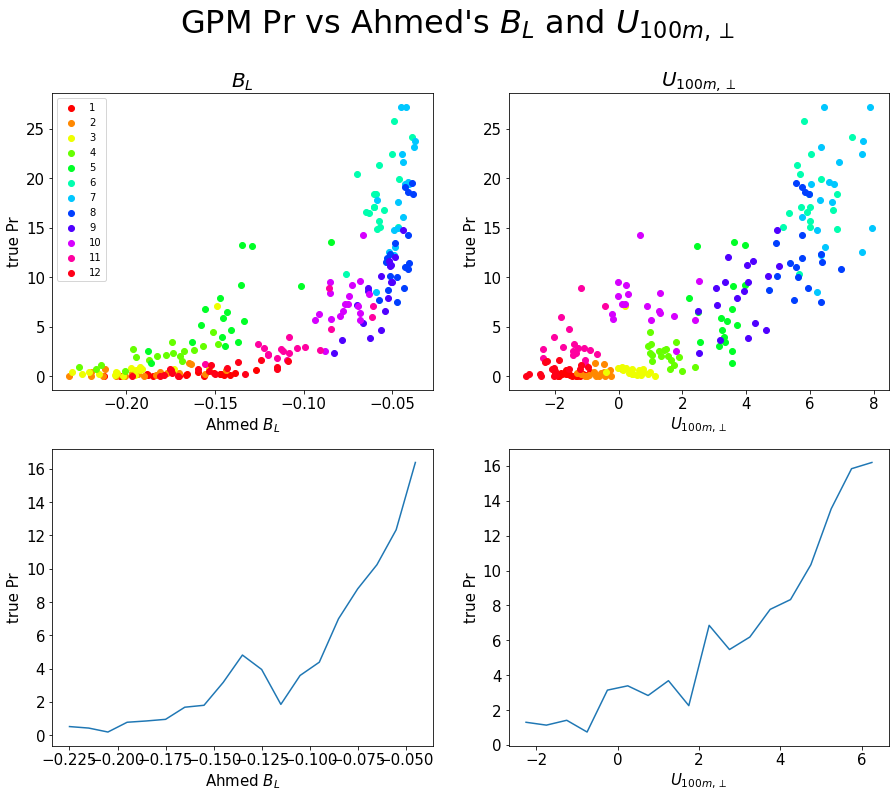

In [148]:
fig,ax = plt.subplots(2,2,figsize=(15,12))
colors=plt.cm.hsv(np.linspace(0,1,12))
for m in range(12):
    ax[0,0].scatter(sel_month(BL_allmonths_box,m+1),sel_month(gpm_pr_allmonths_box,m+1),color=colors[m],label=m+1)
    ax[0,1].scatter(sel_month(uperp100_allmonths_box,m+1),sel_month(gpm_pr_allmonths_box,m+1),color=colors[m],label=m+1)

ax[1,0].plot(*get_binned(BL_allmonths_box,gpm_pr_allmonths_box,np.arange(-0.3,0.1,0.01)))
ax[1,1].plot(*get_binned(uperp100_allmonths_box,gpm_pr_allmonths_box,np.arange(-3,7,0.5)))


ax[0,0].set_title(r'$B_L$' ,fontsize=20)
ax[0,1].set_title(r'$U_{100m,\perp}$',fontsize=20)
for a in ax[:,0]:
    a.set_xlabel(r"Ahmed $B_L$")
    a.set_ylabel("true Pr")
for a in ax[:,1]:
    a.set_xlabel(r"$U_{100m,\perp}$")
    a.set_ylabel("true Pr")
ax[0,0]
ax[0,0].legend(loc=2,fontsize=10)
fig.suptitle(r"GPM Pr vs Ahmed's $B_L$ and $U_{100m,\perp}$",fontsize=32)

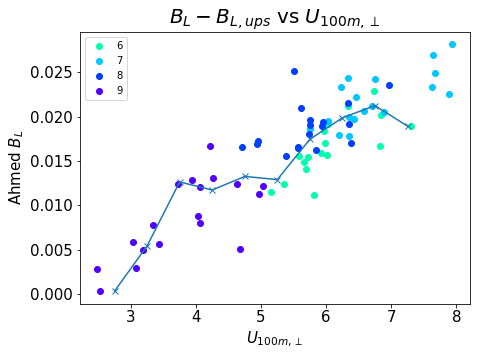

In [175]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
colors=plt.cm.hsv(np.linspace(0,1,12))
for m in range(5,9):
    ax.scatter(sel_month(uperp100_allmonths_box,m+1),sel_month(BL_allmonths_box-BL_allmonths_boxups,m+1),color=colors[m],label=m+1)
summer_u = uperp100_allmonths_box.sel(time = ((uperp100_allmonths_box['time.month'] >= 6)&(uperp100_allmonths_box['time.month'] < 10)))
summer_BL = (BL_allmonths_box-BL_allmonths_boxups).sel(time = ((BL_fixedtb_allmonths_box['time.month'] >= 6)&(BL_fixedtb_allmonths_box['time.month'] < 10)))

ax.plot(*get_binned(summer_u,summer_BL,np.arange(-3,9,0.5)),'-x')


ax.set_title(r'$B_L-B_{L,ups}$ vs $U_{100m,\perp}$' ,fontsize=20)
ax.set_xlabel(r"$U_{100m,\perp}$")
ax.set_ylabel(r"Ahmed $B_L$")
ax.legend(loc=2,fontsize=10)

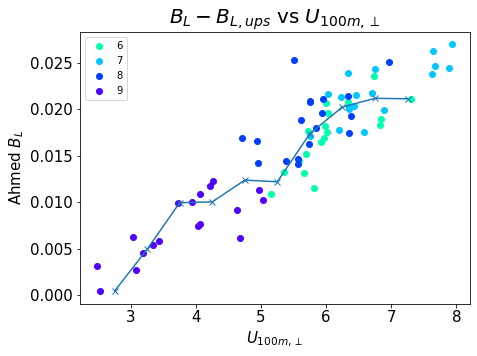

In [181]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
colors=plt.cm.hsv(np.linspace(0,1,12))
for m in range(5,9):
    ax.scatter(sel_month(uperp100_allmonths_box,m+1),sel_month(BL_fixedtb_allmonths_box-BL_fixedtb_allmonths_boxups,m+1),color=colors[m],label=m+1)
summer_u = uperp100_allmonths_box.sel(time = ((uperp100_allmonths_box['time.month'] >= 6)&(uperp100_allmonths_box['time.month'] < 10)))
summer_BL = (BL_fixedtb_allmonths_box-BL_fixedtb_allmonths_boxups).sel(time = ((BL_fixedtb_allmonths_box['time.month'] >= 6)&(BL_fixedtb_allmonths_box['time.month'] < 10)))

ax.plot(*get_binned(summer_u,summer_BL,np.arange(-3,9,0.5)),'-x')


ax.set_title(r'$B_L-B_{L,ups}$ vs $U_{100m,\perp}$' ,fontsize=20)
ax.set_xlabel(r"$U_{100m,\perp}$")
ax.set_ylabel(r"Ahmed $B_L$")
ax.legend(loc=2,fontsize=10)

In [105]:
umeanday = sel_box_month(era5100u_ghats_julhourly,boxtest,0).resample(time='1D').mean().mean(['latitude','longitude']).load()
vmeanday = sel_box_month(era5100v_ghats_julhourly,boxtest,0).resample(time='1D').mean().mean(['latitude','longitude']).load()
gpmprday = sel_box_month(gpmpr_ghats_juldaily,boxtest,0).resample(time='1D').mean().mean(['latitude','longitude']).load()
tday = sel_box_month(era5t_ghats_julhourly,boxtest,0).resample(time='1D').mean().mean(['latitude','longitude']).load()
qday = sel_box_month(era5q_ghats_julhourly,boxtest,0).resample(time='1D').mean().mean(['latitude','longitude']).load()

In [109]:
uperpday = crossslopeflow(umeanday, vmeanday,Ghats.angle)

In [110]:
BL_day=BL_plevs(tday,qday,700.)


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/numpy_func.py:289: RuntimeWarning: invalid value encountered in log
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/quantity.py:1393: RuntimeWarning: invalid value encountered in power
  return other ** new_self._magnitude
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:1067: RuntimeWarning: overflow encountered in exp
  th_es = th_l * np.exp((3036. / t - 1.78) * r * (1 + 0.448 * r))


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.


Text(0.5, 0.98, "GPM Pr vs Ahmed's $B_L$")

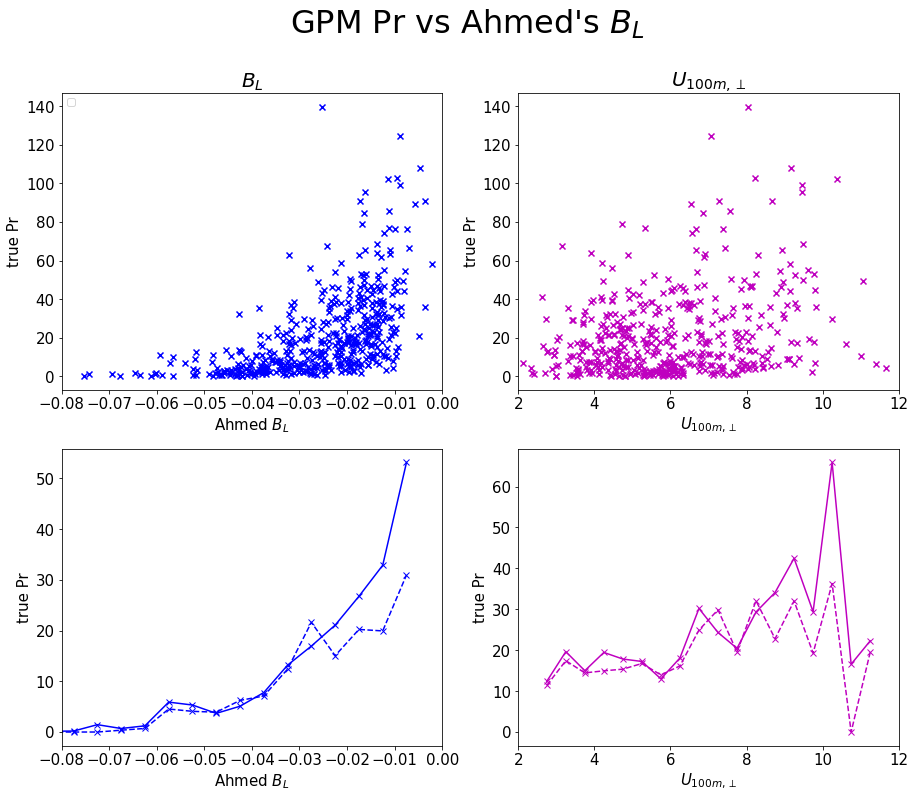

In [183]:
fig,ax = plt.subplots(2,2,figsize=(15,12))
colors=plt.cm.hsv(np.linspace(0,1,12))
ax[0,0].scatter(BL_day,gpmprday  ,color='b',marker='x')
ax[0,1].scatter(uperpday,gpmprday,color='m',marker='x')

bl_center, pr_bl_mean, pr_bl_std = get_binned(BL_day,gpmprday,np.arange(-0.1,0.001,0.005),std=True)
u_center , pr_u_mean , pr_u_std = get_binned(uperpday,gpmprday,np.arange(1.,13,0.5),std=True)        

ax[1,0].plot(bl_center, pr_bl_mean,'-xb')
ax[1,1].plot(u_center , pr_u_mean ,'-xm')
ax[1,0].plot(bl_center, pr_bl_std,'--xb')
ax[1,1].plot(u_center , pr_u_std ,'--xm')

ax[0,0].set_title(r'$B_L$' ,fontsize=20)
ax[0,1].set_title(r'$U_{100m,\perp}$',fontsize=20)
for a in ax[:,0]:
    a.set_xlabel(r"Ahmed $B_L$")
    a.set_ylabel("true Pr")
    a.set_xlim(-0.08,0.)
for a in ax[:,1]:
    a.set_xlabel(r"$U_{100m,\perp}$")
    a.set_ylabel("true Pr")
    a.set_xlim(2,12)
ax[0,0]
ax[0,0].legend(loc=2,fontsize=10)
fig.suptitle(r"GPM Pr vs Ahmed's $B_L$",fontsize=32)

### W,U,T',q',$\zeta$

In [171]:
def normalize(var):
    var = var-var.sel(x=slice(var.x[0],var.x[0]+200)).mean('x')
    var=np.sign(var.sel(x=-100,method='nearest'))*var
    return var/var.sel(x=slice(-300,100)).max()

def plot_normalized_crosssections(ax,axm,MR):
    pr = crossslope_avg(MR.vars_rot['GPM_PR'])
    TL = crossslope_avg(MR.vars_rot['T']).sel(level=slice(700.,900.)).mean('level')
    qL = crossslope_avg(MR.vars_rot['Q']).sel(level=slice(700.,900.)).mean('level')
    
    normalize(pr).plot(ax=ax,color='blue',label="GPM P'")
    normalize(TL).plot(ax=ax,color='r',label=r"$T_L'$")
    normalize(qL).plot(ax=ax,color='g',label=r"$q_L'$")
    
    w = -1/9.81*crossslope_avg(MR.vars_rot['W']).sel(level=slice(700.,900.)).mean('level')
    normalize(w).plot(ax=ax,color='orange',label=r"$W$")
    
    uperp = crossslope_avg(MR.vars_rot['U_PERP']).sel(level=slice(700.,900.)).mean('level')
    #(uperp/10).plot(ax=ax,color='m',label=r"$U_\perp$")
    
    zeta = cumtrapz(w/uperp,w.x*1e3,initial=0) * w**0
    normalize(zeta).plot(ax=ax,color='purple',label=r"$\zeta$")
    
    crossslope_avg(MR.vars_rot['Z']).plot(ax=axm,color='k')

    ax.set_ylabel('Normalized, nondimensional')
    axm.set_ylabel('m')

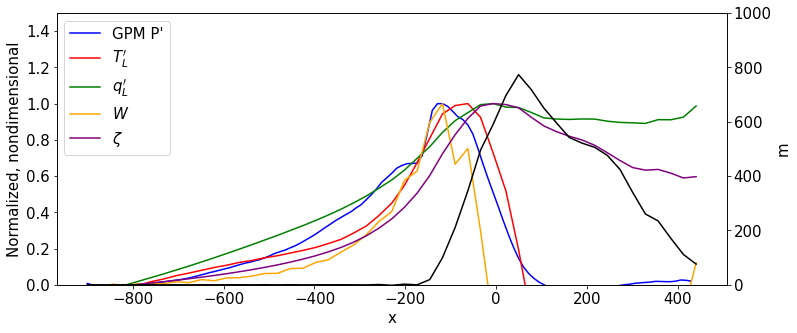

In [172]:
fig,ax = plt.subplots(1,1,figsize=(12,5))
axm=ax.twinx()

plot_normalized_crosssections(ax,axm,Ghats)

ax.set_ylim(0,1.5)
axm.set_ylim(0,1000)
ax.legend(loc=2)


In [58]:
from tools.wrfHrTools import *

In [66]:
# In wrf sims
pl = xr.open_dataset("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/wrfpout_d01_1970-01-01_00_00_00")
w_moist = change_coords_pl(pl,xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.W_PL.days100-250.nc"))
w_dry   = change_coords_sfc(xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/wrf.W_PL.days50-100.nc"))
pr = change_coords_sfc(xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.precip.days0-250.nc"))[400:].mean(('Time','south_north'))

In [106]:
zeta_moist = w_moist[0]**0 * cumtrapz((w_moist/10).sel(pressure=slice(875,700)).mean('pressure')[::-1],w_moist.distance_from_mtn[::-1],initial=0)[::-1]
zeta_dry = w_dry[0]**0 * cumtrapz((w_dry/10).sel(pressure=slice(875,700)).mean('pressure')[::-1],w_dry.distance_from_mtn[::-1],initial=0)[::-1]

(-1000.0, 600.0)

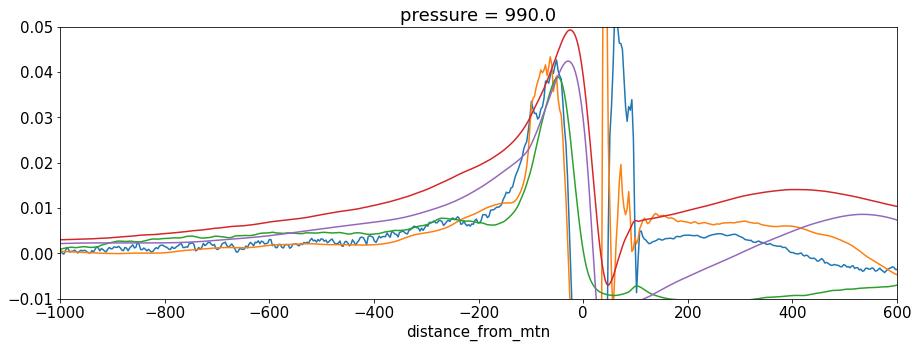

In [108]:
plt.figure(figsize=(15,5))
w_moist.sel(pressure=slice(875,700)).mean('pressure').plot()
w_dry.sel(pressure=slice(875,700)).mean('pressure').plot()
((pr-4.5)*0.05/20).plot()
( zeta_moist / 13 ).plot()
( zeta_dry / 13 ).plot()

plt.ylim(-1e-2,5e-2)
plt.xlim(-1000,600)

In [14]:
def interp_z_full(sim,var,zlevs,staggered=False,**x_kwargs):
    var_s = change_coords_eta(sim,var,staggered=staggered,**x_kwargs)
    var_z=np.zeros((len(var_s.Time),len(zlevs),len(var_s.distance_from_mtn)))
    for i in range(var_z.shape[0]):
        if i%10==0:
            print(i, end=' ')
        var_z[i] = interp_eta_to_z(sim,var_s.isel(Time=i),zlevs=zlevs,staggered=staggered)
    var_z = xr.DataArray(var_z,coords={'Time':var_s.Time,'z':zlevs,'distance_from_mtn':var_s.distance_from_mtn},dims=['Time','z','distance_from_mtn'])
    return var_z

import wrf
from scipy.interpolate import interp1d
from tools.wrfHrTools import *
ghats_ideal = xr.open_dataset("/global/cscratch1/sd/qnicolas/wrfdata/saved/gw.wrf.2D.60lev.10km/wrfout_d01_1970-01-01_00_00_00")
x_kwargs={'center':314,'flip_x':False,'dx':10}

z0 = wrf.destagger((ghats_ideal.PH[-1,:,:,0].mean('south_north') + ghats_ideal.PHB[-1,:,0,0])/9.81,0)
p0 = (ghats_ideal.P[-1,:,:,0].mean('south_north') + ghats_ideal.PB[-1,:,0,0])
orog_ghats = change_coords_sfc(ghats_ideal.HGT[0,0,:],**x_kwargs)

zlevs=np.arange(0.,20e3,200.)
ghats_ideal_w_z = interp_z_full(ghats_ideal,ghats_ideal.W[-100:].mean('south_north'),zlevs,staggered=True,**x_kwargs)
p_equiv = interp1d(z0,p0,fill_value='extrapolate')(ghats_ideal_w_z.z)
ghats_ideal_w_z = ghats_ideal_w_z.assign_coords({'level':('z',p_equiv/100.)})
w_sim = ghats_ideal_w_z[50:].sel(z=slice(1000,3000)).mean(['Time','z'])

0 10 20 30 40 50 60 70 80 90 

In [15]:
u_temp = wrf.destagger(ghats_ideal.U[-100:].mean('south_north'),2)
u_temp = u_temp * ghats_ideal.T[-100:,:,0]**0
ghats_ideal_u_z = interp_z_full(ghats_ideal,u_temp,zlevs,staggered=False,**x_kwargs)
ghats_ideal_u_z = ghats_ideal_u_z.assign_coords({'level':('z',p_equiv/100.)})
u_sim = ghats_ideal_u_z[50:].sel(z=slice(1000,3000)).mean(['Time','z'])

0 10 20 30 40 50 60 70 80 90 

In [16]:
zeta_sim = w_sim**0 * cumtrapz((w_sim/u_sim),w_sim.distance_from_mtn,initial=0)
zeta_sim=zeta_sim-zeta_sim.sel(distance_from_mtn=-1500)

In [54]:
ghats_ideal_temp_z=xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/gw.wrf.2D.60lev.10km/diags/wrf.TEMP.zinterp.days0-10.nc")
t = ghats_ideal_temp_z[-100:].sel(z=slice(1000,3000)).mean(('Time','z'))
tprime = t - t.sel(distance_from_mtn=-1500)

In [67]:
from observationsAndERA5.linearWaveModels import linear_w_1layer
xx = 1e3*np.array(orog_ghats.distance_from_mtn)
hx = np.array(orog_ghats)
w_lineargw = linear_w_1layer(xx,hx,np.linspace(0,10e3,101),13,0.012)
tprime_lineargw,_ = linear_TdL_qdL(xx,hx,13)
tprime_lineargw = tprime_lineargw*w_lineargw.distance_from_mtn**0

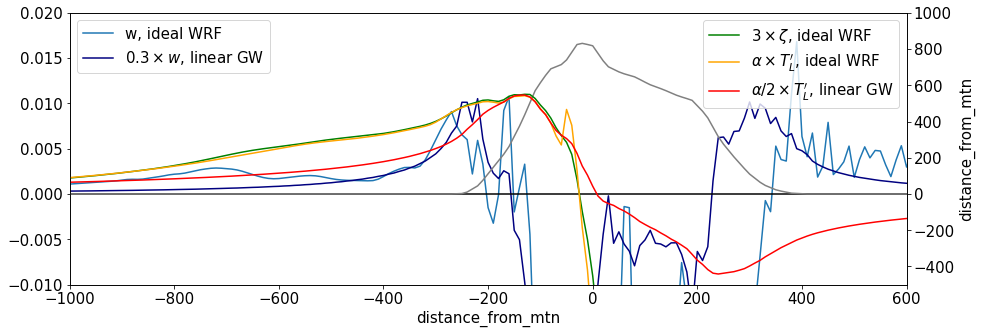

In [66]:
plt.figure(figsize=(15,5))

w_sim.plot(label="w, ideal WRF")
(w_lineargw/3).sel(altitude=slice(1,3)).mean('altitude').plot(color='navy',label=r"$0.3\times w$, linear GW")
plt.legend()

plt.ylim(-1e-2,2e-2)
plt.xlim(-1000,600)
plt.axhline(0.,color='k')

plt.twinx()
orog_ghats.plot(color='gray')
(3*zeta_sim*1e3).plot(color='g',label=r'$3\times \zeta$, ideal WRF')
(-6e2*tprime).plot(color='orange',label=r"$\alpha\times T_L'$, ideal WRF")
(-3.2e2*tprime_lineargw).plot(color='r',label=r"$\alpha/2\times T_L'$, linear GW")
plt.ylim(-500,1000)
plt.legend()

### Upwind soundings

In [116]:
Tmean = Ghats.vars_rot['T']
Tprimemean_abv=(Tmean-Tmean.sel(x=slice(Tmean.x[0],Tmean.x[0]+200)).mean('x')).mean('y')
Tprimemean_abv = Tprimemean.sel(x=slice(-100,-0),time=(Tprimemean['time.month']==7)).mean('x')


In [117]:
Tera5_above = sel_box_month(Ghats.vars['T'],Ghats.box_above,0).mean(['latitude','longitude'])
Tera5_uupstream = sel_box_month(Ghats.vars['T'],Ghats.box_upstream,0).mean(['latitude','longitude'])
Tprimemean_2 = Tera5_above-Tera5_uupstream


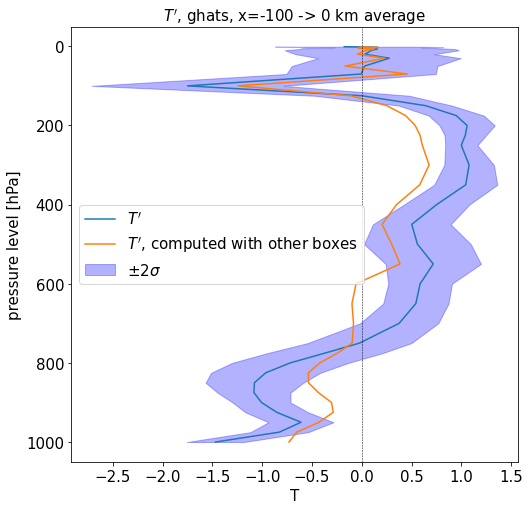

In [118]:
plt.figure(figsize=(8,8))
Tprimemean_abv.mean('time').plot(y='level',yincrease=False,label=(r"$T'$"))
plt.fill_betweenx(Tprimemean_abv.level,Tprimemean_abv.mean('time')-2*Tprimemean_abv.std('time'),Tprimemean_abv.mean('time')+2*Tprimemean_abv.std('time'),color='b',alpha=0.3,label=r'$\pm 2\sigma$')
 

Tprimemean_2.plot(y='level',yincrease=False,label=(r"$T'$, computed with other boxes"))
plt.axvline(0.,color='k',linestyle='--',linewidth=0.5)

plt.title(r"$T'$, ghats, x=-100 -> 0 km average",fontsize=15)
plt.legend()

### With AIRS soundings

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


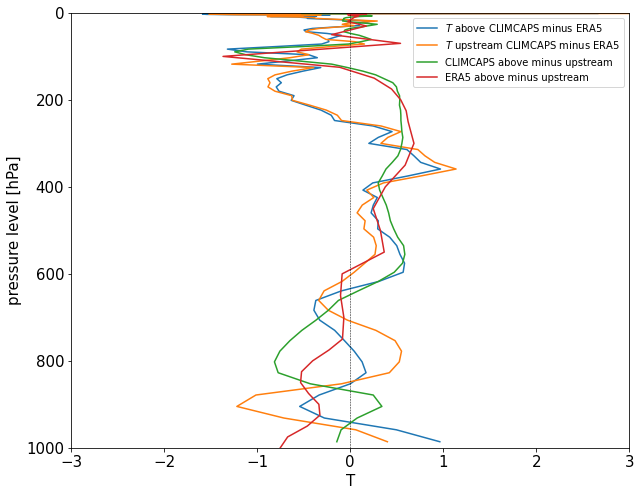

In [119]:

Tclimcaps_above = sel_box_month(Ghats.vars['CLIMCAPS_T'],Ghats.box_above,0).mean(['latitude','longitude'])
Tclimcaps_uupstream = sel_box_month(Ghats.vars['CLIMCAPS_T'],Ghats.box_upstream,0).mean(['latitude','longitude'])

Tera5_oct_climcapsrecord = Ghats.vars['T4D'].sel(time=(Ghats.vars['T4D']['time.month']==Ghats.pr_month)).sel(time=slice("2002-09-01","2016-09-15")).mean('time')
Tera5_above = sel_box_month(Tera5_oct_climcapsrecord,Ghats.box_above,0).mean(['latitude','longitude'])
Tera5_uupstream = sel_box_month(Tera5_oct_climcapsrecord,Ghats.box_upstream,0).mean(['latitude','longitude'])

plt.figure(figsize=(10,8))
(Tclimcaps_above-Tera5_above.interp_like(Tclimcaps_above)).plot(y='level',yincrease=False,label=(r"$T$ above CLIMCAPS minus ERA5"))
(Tclimcaps_uupstream-Tera5_uupstream.interp_like(Tclimcaps_above)).plot(y='level',yincrease=False,label=(r"$T$ upstream CLIMCAPS minus ERA5"))

dTclimcaps=Tclimcaps_above-Tclimcaps_uupstream
dTclimcaps.plot(y='level',yincrease=False,label=(r"CLIMCAPS above minus upstream"))
#plt.fill_betweenx(dtemp.level,dtemp.mean('year')-2*dtemp.std('year'),dtemp.mean('year')+2*dtemp.std('year'),color='g',alpha=0.3,label=r'$\pm 2\sigma$')
 
dTera5=Tera5_above-Tera5_uupstream
dTera5.plot(y='level',yincrease=False,label=(r"ERA5 above minus upstream"))
#plt.fill_betweenx(dTera5.level,dTera5.mean('time')-2*dTera5.std('time'),dTera5.mean('time')+2*dTera5.std('time'),color='r',alpha=0.3,label=r'$\pm 2\sigma$')
 
plt.axvline(0.,color='k',linestyle='--',linewidth=0.5)
plt.xlim(-3,3)
plt.ylim(1000,0)

#plt.title(r"$T'$, ghats, x=-100 -> 0 km average",fontsize=15)
plt.legend(fontsize=10)

## Precipitating days, windy days

### ERA5

In [137]:
def intersect_frac(ls1,ls2):
    return len([e for e in ls1 if e in ls2])/len(ls1)
pctile=50
print("Intersection between >50th pctile precipitating and windy days: %.1f %%"%(100*intersect_frac(extreme_days(pr_timeseries,pctile),extreme_days(upslopeflow_timeseries,pctile))))
pctile=90
print("Intersection between >90th pctile precipitating and windy days: %.1f %%"%(100*intersect_frac(extreme_days(pr_timeseries,pctile),extreme_days(upslopeflow_timeseries,pctile))))

Intersection between >50th pctile precipitating and windy days: 63.8 %
Intersection between >90th pctile precipitating and windy days: 38.3 %


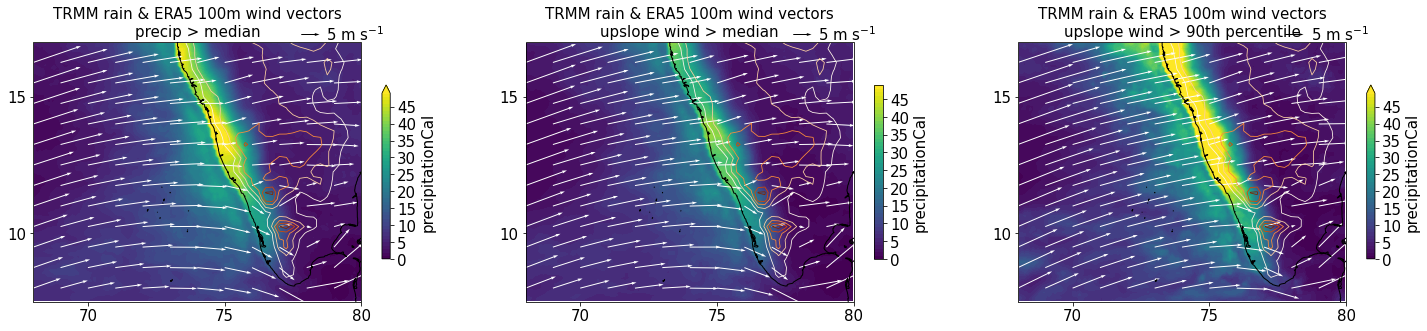

In [19]:
fig,ax = plt.subplots(1,3,figsize=(25,8),subplot_kw={"projection":ccrs.PlateCarree()})
topography_pr_wind_plot(ax[0],Ghats.box,Ghats.vars['Z'],Ghats.vars['GPM_PR_PR50'],Ghats.vars['VAR_100U_PR50'],Ghats.vars['VAR_100V_PR50'],np.arange(0,50,1),cbar_kwargs={'shrink':0.4})
topography_pr_wind_plot(ax[1],Ghats.box,Ghats.vars['Z'],Ghats.vars['GPM_PR_U50'], Ghats.vars['VAR_100U_U50'], Ghats.vars['VAR_100V_U50'], np.arange(0,50,1),cbar_kwargs={'shrink':0.4})
topography_pr_wind_plot(ax[2],Ghats.box,Ghats.vars['Z'],Ghats.vars['GPM_PR_U90'], Ghats.vars['VAR_100U_U90'], Ghats.vars['VAR_100V_U90'], np.arange(0,50,1),cbar_kwargs={'shrink':0.4})
ax[0].set_title("TRMM rain & ERA5 100m wind vectors\nprecip > median",fontsize=15)
ax[1].set_title("TRMM rain & ERA5 100m wind vectors\nupslope wind > median",fontsize=15)
ax[2].set_title("TRMM rain & ERA5 100m wind vectors\nupslope wind > 90th percentile",fontsize=15);None

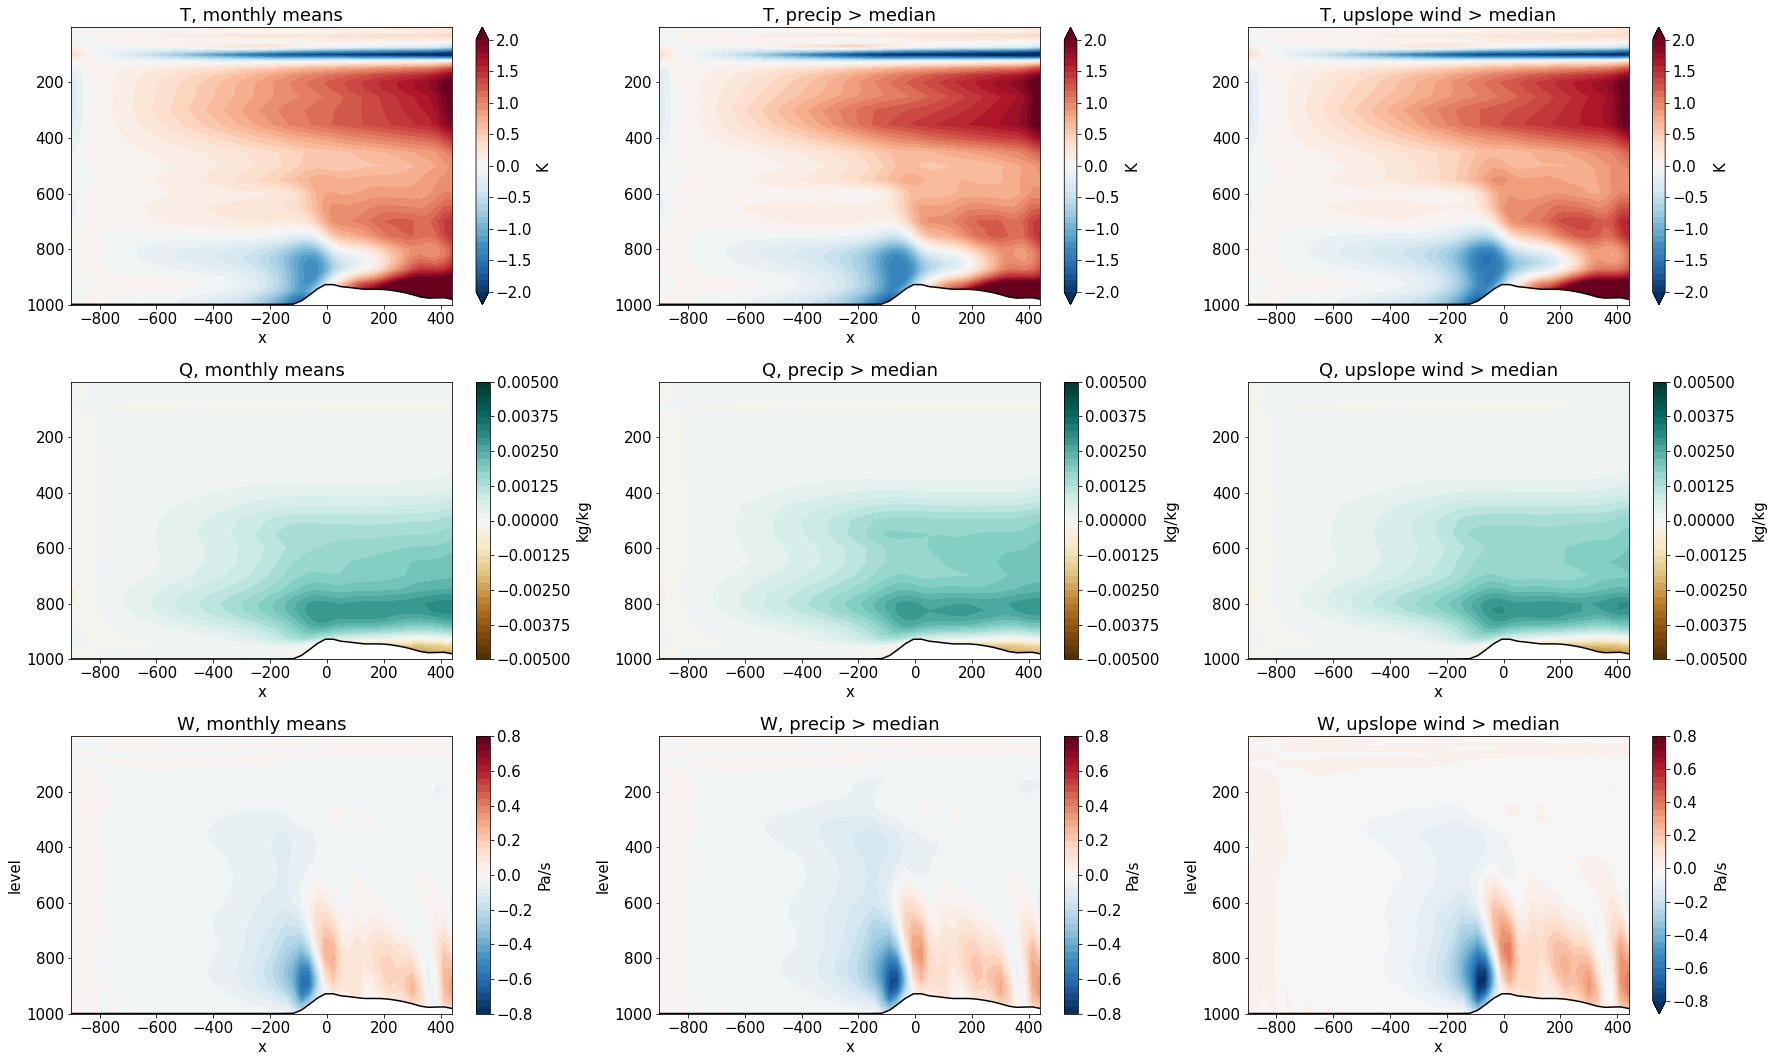

In [22]:
varnames=['T','Q','W']
plunits=['K','kg/kg','Pa/s']
cmaps = [plt.cm.RdBu_r,plt.cm.BrBG,plt.cm.RdBu_r]
scales=[2.,0.005,0.8]
fig,ax=plt.subplots(len(varnames),3,figsize=(25,5*len(varnames)))
for i,(varname,unit,scale,cm) in enumerate(zip(varnames,plunits,scales,cmaps)):
    plot_xz(ax[i,0],Ghats,varname        ,pert=True,levels=np.linspace(-scale,scale,41),cmap=cm,cbar_kwargs={'label':unit}); ax[i,0].set_title(varname+', monthly means')
    plot_xz(ax[i,1],Ghats,varname+'_PR50',pert=True,levels=np.linspace(-scale,scale,41),cmap=cm,cbar_kwargs={'label':unit}); ax[i,1].set_title(varname+', precip > median')
    plot_xz(ax[i,2],Ghats,varname+'_U50' ,pert=True,levels=np.linspace(-scale,scale,41),cmap=cm,cbar_kwargs={'label':unit}); ax[i,2].set_title(varname+', upslope wind > median')
for a in ax[i]:
    a.set_ylabel('level')
    
fig.tight_layout()

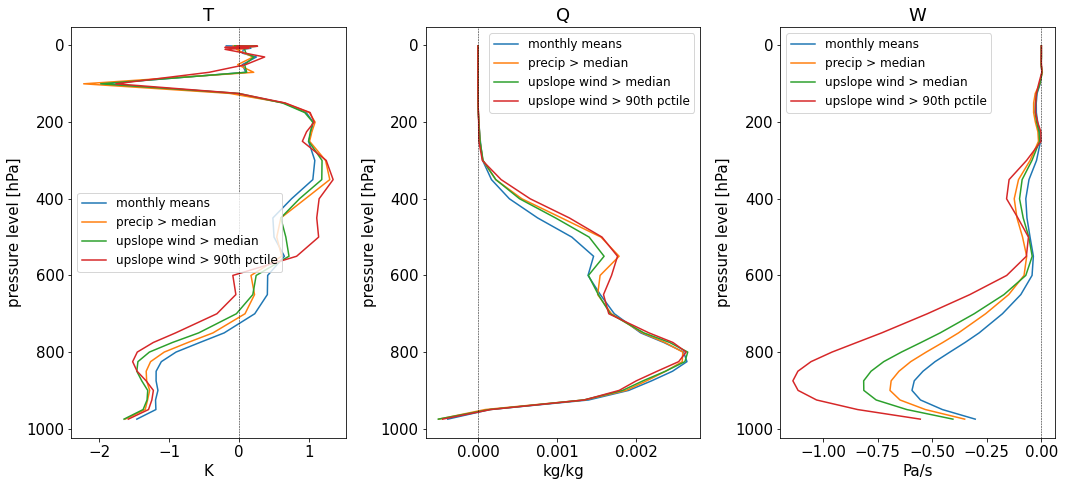

In [142]:
varnames=['T','Q','W']
plunits=['K','kg/kg','Pa/s']
fig,ax=plt.subplots(1,3,figsize=(15,7))
for i,(varname,unit) in enumerate(zip(varnames,plunits)):
    plot_z(ax[i],Ghats,varname        ,-100,pert=True,label='monthly means')
    plot_z(ax[i],Ghats,varname+'_PR50',-100,pert=True,label='precip > median')
    plot_z(ax[i],Ghats,varname+'_U50' ,-100,pert=True,label='upslope wind > median')
    plot_z(ax[i],Ghats,varname+'_U90' ,-100,pert=True,label='upslope wind > 90th pctile')
    ax[i].set_title(varname)
    ax[i].legend(fontsize=12)
    ax[i].set_xlabel(unit)
    ax[i].axvline(0.,color='k',linestyle='--',linewidth=0.5)
fig.tight_layout()

In [126]:
_,_,Plin_smith = smith_theory(xx,hx_ghats,10,5e-3,4.32e-3,P0=6.)

using dry stability, N=0.013
Hw=3319,Cw=0.036


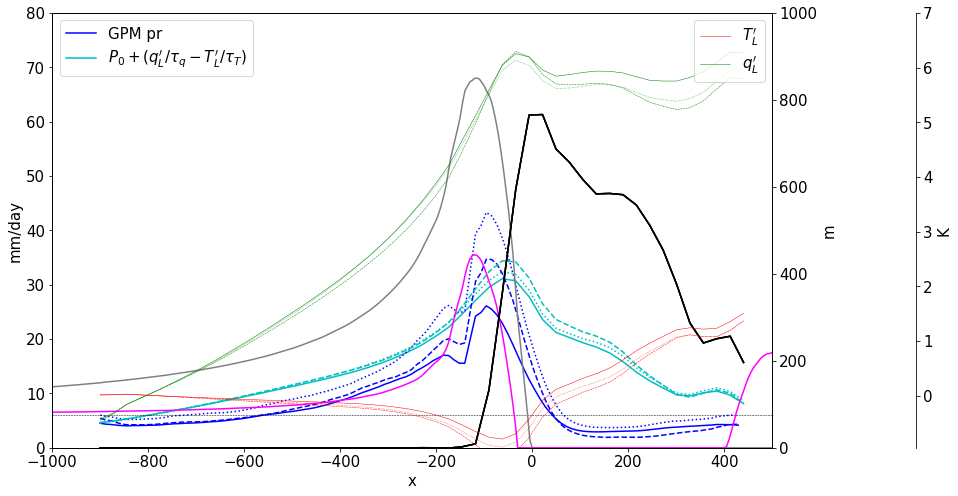

In [127]:
fig,ax = plt.subplots(1,1,figsize=(16,8))
fig.subplots_adjust(right=0.75)
axm=ax.twinx()
axT=ax.twinx()
axT.spines['right'].set_position(("axes", 1.2))

plot_pr_t_q(ax,axm,axT,Ghats.vars_rot['Z'],Ghats.vars_rot['GPM_PR'],Ghats.vars_rot['T'],Ghats.vars_rot['Q'],lns='-',legend=True)
plot_pr_t_q(ax,axm,axT,Ghats.vars_rot['Z'],Ghats.vars_rot['GPM_PR_PR50'],Ghats.vars_rot['T_PR50'],Ghats.vars_rot['Q_PR50'],P0=6.,lns=':')
plot_pr_t_q(ax,axm,axT,Ghats.vars_rot['Z'],Ghats.vars_rot['GPM_PR_U50' ],Ghats.vars_rot['T_U50' ],Ghats.vars_rot['Q_U50' ],P0=6.,lns='--')

ax.axhline(6.,color='k',linewidth=0.5,linestyle='--')

ax.plot(xx/1000,linear_precip_theory_N(xx,hx_ghats,12,0.011,P0=6.),color='grey')
ax.plot(xx/1000,Plin_smith,color='magenta')

ax.set_xlim(-1000,500)
ax.set_ylim(0,80)
axm.set_ylim(0,1000)
axT.set_ylim(-7*6/(50-6),7)
ax.legend(loc=2)
axT.legend(loc=1)

### CLIMCAPS data, comparing w/ linear theory, soundings

In [13]:
import sys; import os
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)
from tools.generalTools import qsat,humidsat

def HwCw(temp_surface,ps,gamma,gamma_m):
    """Compute water vapor scale height and coefficient Cw assuming a moist adiabatic atmosphere
     - temp_surface = surface temperature (np.array)
     - ps = surface pressure (np.array)
     - gamma = environment lapse rate
    """
    L=2.5e6
    Hw = 461.*temp_surface**2/(L*gamma)
    Cw = humidsat(temp_surface,ps/100)[0]*100/287./temp_surface*gamma_m/gamma
    return Hw,Cw
def smith_theory(u,gamma,gamma_m,ts=300.,tau=2000,kind='gaussian'):
    ps=100000.
    Hw,Cw = HwCw(ts,ps,gamma,gamma_m)
    if gamma < gamma_m:
        N=np.sqrt(9.81/ts*(gamma_m-gamma))
        print("using moist stability, N=%.3f"%N)
    else:
        N=np.sqrt(9.81/ts*(9.81/1000-gamma))
        print("using dry stability, N=%.3f"%N)
    print("Hw=%i,Cw=%.3f"%(Hw,Cw))

    tau_c=tau
    tau_f=tau
    P0=4.5 #mm/day
    
    xx=np.arange(-10000e3,10000e3,1e3)
    A = 1000
    a = 100e3
    if kind=='gaussian':
        hx = A*np.exp(-xx**2/2/(a/2)**2)
    elif kind=='cos':
        hx = A/2*(1+np.cos(np.pi*np.maximum(-1,np.minimum(1,xx/a))))
    k=k_vector(len(xx),xx[1]-xx[0])
    
    P=np.maximum(P0+86400*np.real(np.fft.ifft(Cw*np.fft.fft(hx)*1j*u*k/(1-Hw*m_exponent(k,N,u))/(1+1j*u*k*tau_c)/(1+1j*u*k*tau_f))),0.)
    return xx,hx,P

In [18]:
xx2,_,Plin_smith = smith_theory(10,5e-3,4.32e-3,kind='cos')

using dry stability, N=0.013
Hw=3319,Cw=0.036


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


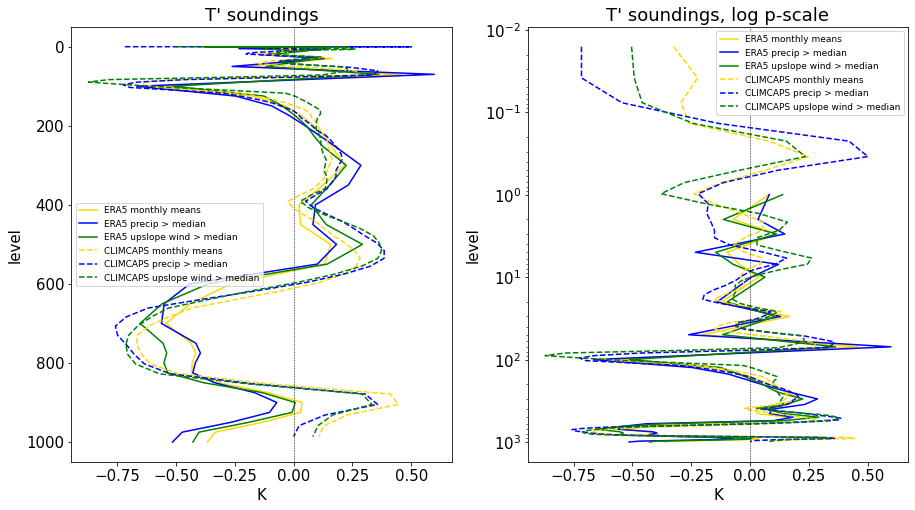

In [34]:
unit = 'K'
fig,axs=plt.subplots(1,2,figsize=(15,8))
for ax in axs:
    plot_z_diff(ax,Ghats.vars['T']     ,Ghats.box_upstream,Ghats.box_above,color='gold' ,label='ERA5 monthly means')
    plot_z_diff(ax,Ghats.vars['T_PR50'],Ghats.box_upstream,Ghats.box_above,color='blue' ,label='ERA5 precip > median')
    plot_z_diff(ax,Ghats.vars['T_U50'] ,Ghats.box_upstream,Ghats.box_above,color='green',label='ERA5 upslope wind > median')
    plot_z_diff(ax,Ghats.vars['CLIMCAPS_T']     ,Ghats.box_upstream,Ghats.box_above,color='gold' ,linestyle='--',label='CLIMCAPS monthly means')
    plot_z_diff(ax,Ghats.vars['CLIMCAPS_T_PR50'],Ghats.box_upstream,Ghats.box_above,color='blue' ,linestyle='--',label='CLIMCAPS precip > median')
    plot_z_diff(ax,Ghats.vars['CLIMCAPS_T_U50'] ,Ghats.box_upstream,Ghats.box_above,color='green',linestyle='--',label='CLIMCAPS upslope wind > median')
    ax.set_title("T' soundings")
    ax.legend(fontsize=9)
    ax.set_xlabel(unit)
    ax.axvline(0.,color='k',linestyle='--',linewidth=0.5)
ax.set_title("T' soundings, log p-scale")
ax.set_yscale('log')

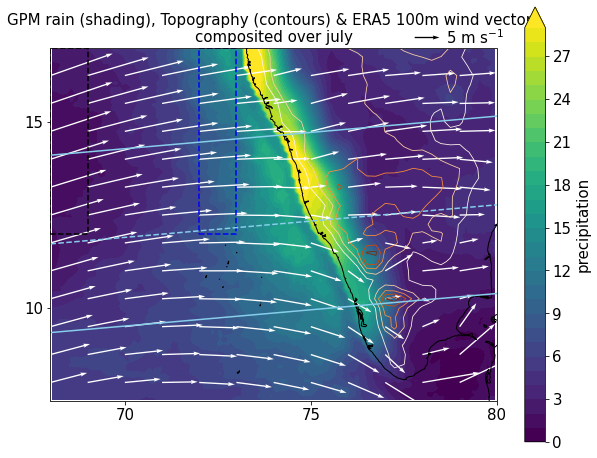

In [116]:
fig,ax = plt.subplots(1,1,figsize=(10,8),subplot_kw={"projection":ccrs.PlateCarree()})
topography_pr_wind_plot(ax,Ghats.box,Ghats.vars['Z'],Ghats.vars['GPM_PR'],Ghats.vars['VAR_100U'],Ghats.vars['VAR_100V'],np.arange(0,30,1))

#Boxes
for smallbox,clr in ((Ghats.box_upstream,'k'),(Ghats.box_above,'b')):
    ax.add_patch(mpatches.Rectangle(xy=[smallbox[0], smallbox[2]], width=smallbox[1]-smallbox[0], height=smallbox[3]-smallbox[2],edgecolor=clr,fill = False,lw=1.5,linestyle='--',transform=ccrs.PlateCarree())
                    )
angletest=85
alpha = np.tan(np.pi/2-np.pi*angletest/180)
x0,x1=Ghats.box[0],Ghats.box[1]; xm=(x0+x1)/2
y0,y1=Ghats.box[2],Ghats.box[3]; ym=(y0+y1)/2
fx = np.array([ym + alpha*(x0-xm),ym + alpha*(x1-xm)])
ax.plot([x0,x1],fx,color='skyblue',linestyle='--')
ax.plot([x0,x1],fx-(y1-y0)/4/np.cos(alpha),color='skyblue',linestyle='-')
ax.plot([x0,x1],fx+(y1-y0)/4/np.cos(alpha),color='skyblue',linestyle='-')

#dx = alpha*(y1-y0)/4
#xu1 = xm + 700/111 * np.cos(np.arctan(alpha))
#xu2 = xm + 500/111 * np.cos(np.arctan(alpha))
#for xa in xm,xu1,xu2:
#    ax.plot([xa-dx,xa+dx],[ym + alpha*(xa-xm)+dx/alpha,ym + alpha*(xa-xm)-dx/alpha],color='skyblue',linestyle='-')


ax.set_title("GPM rain (shading), Topography (contours) & ERA5 100m wind vectors\ncomposited over july",fontsize=15);None



In [105]:
testgpm=rotate_var(Ghats.vars['GPM_PR_U90'],85,mountaintop=Ghats.x_mountaintop,two_dim=False,order=0)

In [97]:
Ghats_CLIMCAPS_T_rot = rotate_var(Ghats.vars['CLIMCAPS_T'].interp_like(Ghats.vars['GPM_PR']).fillna(-1e8),85,mountaintop=Ghats.x_mountaintop,two_dim=False,order=0)
pctile=50
Ghats_CLIMCAPS_T_U50_rot = rotate_var(climcapst_ghats_juldaily.sel(time = timesel(climcapst_ghats_juldaily.time,extreme_days(upslopeflow_timeseries,pctile))).mean('time').load().interp_like(Ghats.vars['GPM_PR']).fillna(-1e8),
           85,mountaintop=Ghats.x_mountaintop,two_dim=False,order=0)
pctile=90
Ghats_CLIMCAPS_T_U90_rot = rotate_var(climcapst_ghats_juldaily.sel(time = timesel(climcapst_ghats_juldaily.time,extreme_days(upslopeflow_timeseries,pctile))).mean('time').load().interp_like(Ghats.vars['GPM_PR']).fillna(-1e8),
           85,mountaintop=Ghats.x_mountaintop,two_dim=False,order=0)

Ghats_CLIMCAPS_T_rot     = Ghats_CLIMCAPS_T_rot.where(Ghats_CLIMCAPS_T_rot>0)
Ghats_CLIMCAPS_T_U50_rot = Ghats_CLIMCAPS_T_U50_rot.where(Ghats_CLIMCAPS_T_U50_rot>0)
Ghats_CLIMCAPS_T_U90_rot = Ghats_CLIMCAPS_T_U90_rot.where(Ghats_CLIMCAPS_T_U90_rot>0)


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [98]:
climcapst_q_ghats_juldaily = xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/L3_CLIMCAPS_QCC.spec_hum.2002-2015.07.ghats.zarr").spec_hum
climcapst_q_ghats_juldaily = climcapst_q_ghats_juldaily.assign_coords(level=climcapst_q_ghats_juldaily.air_pres_h2o/100).swap_dims({'air_pres_h2o':'level'})
pctile=90
Ghats_CLIMCAPS_Q_U90_rot = rotate_var(climcapst_q_ghats_juldaily.sel(time = timesel(climcapst_ghats_juldaily.time,extreme_days(upslopeflow_timeseries,pctile))).mean('time').load().interp_like(Ghats.vars['GPM_PR']).fillna(-1e8),
           85,mountaintop=Ghats.x_mountaintop,two_dim=False,order=0)

Ghats_CLIMCAPS_Q_U90_rot = Ghats_CLIMCAPS_Q_U90_rot.where(Ghats_CLIMCAPS_Q_U90_rot>0)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [49]:
def ghats_crosssec(var):
    m=len(var.y)
    return var.isel(y=slice(m//2,3*m//4)).mean('y')

def plot_xz_ghats(ax,var,pert=False,fact=1,**plot_kwargs):
    if pert:
        cv=ghats_crosssec(fact*var)
        (cv-cv.sel(x=slice(cv.x[0],cv.x[0]+200)).mean('x')).plot.contourf(ax=ax,yincrease=False,**plot_kwargs)
    else:
        ghats_crosssec(fact*var).plot.contourf(ax=ax,yincrease=False,**plot_kwargs)
    p_sfc = crossslope_avg(999-Ghats.vars_rot['Z']/(1.1*9.81))
    p_sfc.plot(ax=ax,color='k')
    ax.fill_between(p_sfc.x,0*p_sfc+1000.,p_sfc,color='w')
    

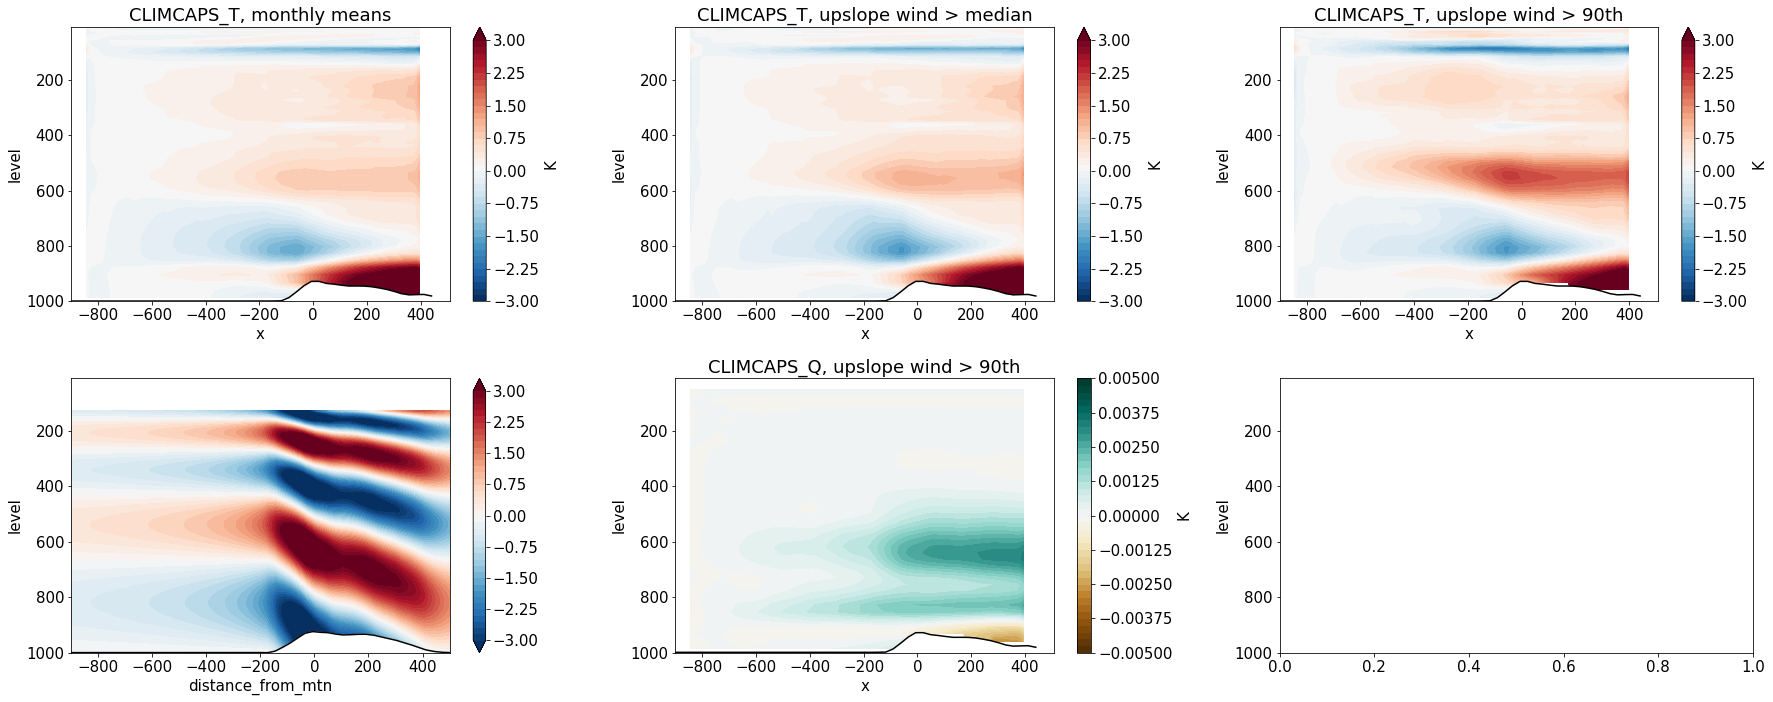

In [99]:
fig,ax=plt.subplots(2,3,figsize=(25,10))
ax=ax.reshape(-1)
varname,unit,scale,cm = 'CLIMCAPS_T','K',3,plt.cm.RdBu_r
plot_xz_ghats(ax[0],Ghats_CLIMCAPS_T_rot     ,pert=True,levels=np.linspace(-scale,scale,41),cmap=cm,cbar_kwargs={'label':unit}); ax[0].set_title(varname+', monthly means')
plot_xz_ghats(ax[1],Ghats_CLIMCAPS_T_U50_rot,pert=True,levels=np.linspace(-scale,scale,41),cmap=cm,cbar_kwargs={'label':unit}); ax[1].set_title(varname+', upslope wind > median')
plot_xz_ghats(ax[2],Ghats_CLIMCAPS_T_U90_rot,pert=True,levels=np.linspace(-scale,scale,41),cmap=cm,cbar_kwargs={'label':unit}); ax[2].set_title(varname+', upslope wind > 90th')
plot_xz_ghats(ax[4],Ghats_CLIMCAPS_Q_U90_rot,pert=True,levels=np.linspace(-0.005,0.005,41),cmap=plt.cm.BrBG,cbar_kwargs={'label':unit}); ax[4].set_title('CLIMCAPS_Q, upslope wind > 90th')

Tprime_ghats_linear_simple.plot.contourf(ax=ax[3],y='pressure',yincrease=False,levels=np.linspace(-scale,scale,41));ax[3].set_xlim(-900,500)
p_sfc = crossslope_avg(999-Ghats.vars_rot['Z']/(1.1*9.81))
ax[3].plot(xx/1000,1000-hx_ghats/(9.8*1.1),color='k')
ax[3].fill_between(xx/1000,0*xx+1000.,1000-hx_ghats/(9.8*1.1),color='w')
    
    
for a in ax:
    a.set_ylabel('level')
    a.set_ylim(1000,10)
    
fig.tight_layout()

### CLIMCAPS data, without compositing

In [67]:
climcapst_ghats_sub = climcapst_ghats_juldaily[:,50:]
climcaps_tprime = (sel_box_month(climcapst_ghats_sub,Ghats.box_above,0).mean(['latitude','longitude'])-
                   sel_box_month(climcapst_ghats_sub,Ghats.box_upstream,0).mean(['latitude','longitude'])
                  )
climcaps_tprime_norm = climcaps_tprime/climcaps_tprime.max('level')
climcaps_std=climcaps_tprime_norm.std('level').load()

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/utils.py:30: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


In [68]:
np.argsort(climcaps_std.fillna(-1))

<xarray.DataArray 'air_temp' (time: 868)>
array([867, 386, 385, 382, 381, 379, 378, 377, 374, 373, 719, 720, 367,
       387, 364, 360, 359, 358, 357, 356, 355, 350, 349, 723, 724, 346,
       345, 363, 716, 715, 391, 695, 432, 431, 697, 428, 427, 698, 424,
       423, 701, 702, 418, 417, 414, 413, 410, 409, 705, 403, 400, 399,
       706, 709, 396, 395, 710, 392, 342, 341, 729, 335, 290, 289, 755,
       756, 284, 283, 280, 279, 759, 760, 276, 275, 765, 766, 269, 266,
       265, 769, 262, 261, 770, 258, 257, 773, 252, 251, 774, 752, 435,
       293, 751, 730, 332, 331, 733, 328, 327, 734, 324, 323, 737, 738,
       741, 742, 318, 317, 314, 313, 624, 310, 309, 308, 307, 745, 305,
       301, 298, 297, 294, 248, 436, 692, 573, 651, 570, 569, 566, 565,
       652, 562, 561, 559, 655, 554, 648, 553, 549, 548, 547, 546, 545,
       656, 661, 539, 662, 536, 535, 532, 550, 647, 579, 580, 620, 619,
       616, 615, 629, 630, 612, 611, 633, 605, 602, 601, 634, 598, 597,
       637, 638, 594, 593, 592, 591, 641, 588, 587, 642, 584, 583, 531,
       529, 528, 527, 477, 476, 475, 474, 473, 472, 471, 470, 468, 467,
       465, 464, 463, 684, 460, 459, 687, 688, 454, 453, 450, 449, 691,
       446, 445, 443, 442, 478, 439, 683, 481, 525, 665, 666, 522, 521,
       518, 517, 516, 514, 513, 669, 508, 507, 504, 503, 500, 499, 670,
       496, 495, 492, 491, 673, 486, 485, 679, 482, 680, 247, 623,  52,
       165, 805, 162, 840, 839, 161, 807,  59,  60, 158, 157, 154, 153,
...
       380, 120, 141, 501,  29, 260, 816, 600, 383, 340,  74, 530,   0,
       645,  87, 512,  32, 213, 398, 420, 577, 581, 823, 540, 199, 224,
       209, 793, 131, 717, 585, 689, 675, 837, 434, 174, 160, 599, 609,
       657, 166,  64,  30, 167, 681, 136, 586, 295, 663, 362, 151,  50,
        43, 571, 278, 828, 686, 253, 750, 575, 306, 339,  40, 235, 771,
       187, 393, 457, 614, 820, 852, 855, 844, 488, 833, 315, 347, 799,
       524, 682,   8,  83, 776,  15, 747, 329, 110, 109, 649, 851, 711,
       264, 333, 114, 164,  84, 639, 303, 259, 718, 249, 842, 238, 721,
       725, 101, 458, 772, 578, 636, 804, 119, 785, 537, 440, 138, 827,
       713, 617, 846, 348, 563, 739, 635, 277, 589, 287, 626, 707, 228,
       483, 731,  44, 421, 490, 690,  58, 433, 746, 268, 106, 735,  69,
       806, 497, 809, 749, 800, 288, 461, 712, 494, 557, 511, 613, 320,
        61, 489, 480, 271, 388, 115, 631, 761, 845, 653, 523, 640, 685,
       319, 372, 740, 479, 267, 696, 708,  16, 234, 425, 866,  54, 732,
        88, 214, 595, 541, 448, 764, 703, 795, 627, 325, 865, 847, 219,
       618, 390, 218, 274,   7, 622, 102,  53, 316, 754, 242,  17, 758,
       422, 660, 343, 664, 810, 292, 829, 830, 700, 610,  57, 437, 169,
       848, 273, 429,  49, 484,  63, 803, 596, 250, 659, 654, 322, 862,
       237, 753, 621, 726, 757, 241, 677, 426, 509, 321, 397, 408, 389,
       727, 658, 205, 763, 678, 326, 137, 170, 643, 371])
Coordinates:
  * time     (time) datetime64[ns] 2003-06-30T13:30:05 ... 2016-07-31T01:30:09

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


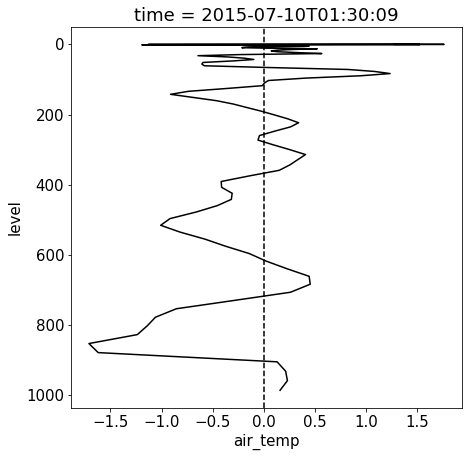

In [77]:
fig,ax=plt.subplots(1,1,figsize=(7,7))
plot_z_diff(ax,climcapst_ghats_juldaily[763]     ,Ghats.box_upstream,Ghats.box_above,color='k' ,linestyle='-')
#plot_z_diff(ax,climcapst_ghats_juldaily.mean('time')   ,Ghats.box_upstream,Ghats.box_above,color='gold' ,linestyle='-',label='CLIMCAPS monthly means')

ax.axvline(0.,color='k',linestyle='--')

# Other regions

## Data loading

In [12]:
mountains=         {"vietnam"    :([102,115,10,19.5],"Annamite range (Vietnam)",240,10,800.),
                    "ghats"      :([68,80,7.5,17]   ,"Western Ghats"           ,70 ,6 ,900.),
                    "madagascar" :([40,60,-25,-12]  ,"Madagascar"              ,280,3 ,1350.),
                    "myanmar"    :([80,102,7,27]    ,"Myanmar"                 ,60 ,7 ,1700.),
                    "newbritain" :([148,155,-12,0]  ,"New Britain"             ,320,7 ,450.),
                    "philippines":([118,130,10,22]  ,"Philippines"             ,225,12,850.),
                    "sumatra"    :([90,110,-6,6]    ,"Bukit Barisan (Sumatra)" ,70 ,11,1100.),
                    "malaysia"   :([97,107,1,10]    ,"Malaysia"                ,225,11,600.),
                   }

precip_boxes = {"vietnam"    :[107  ,  19  , 110.5, 14   ,2  ],
                "ghats"      :[ 75  ,   9  ,  72.5, 16   ,2  ],
                "madagascar" :[ 52  , -14.5,  49  , -24.5,2.5],
                "myanmar"    :[ 98  ,  11  ,  90  , 21   ,4  ],
                "newbritain" :[154  , - 6  , 150  , -8   ,2  ],
                "philippines":[123.5,  19  , 127  , 11   ,3  ],
                "sumatra"    :[ 98.5, - 2  ,  96  , 2    ,2.5],
                "malaysia"   :[100.5,  10  , 105  , 4    ,2  ],
               }

mountains_ref_rce={ "vietnam"    :[112, 114, 17, 19],
                    "ghats"      :[68, 69, 11, 14]  ,
                    "madagascar" :[55,57,-20,-17]   ,
                    "myanmar"    :[86,89,12,15]     ,
                    "newbritain" :[153,155,-12,-10] ,
                    "philippines":[128,130,16,18]   ,
                    "sumatra"    :[90,94,-2,2]      ,
                    "malaysia"   :[106,107,8,9]     ,
                   }

mountains_ref_above=   {"vietnam"    :[108, 109, 15, 17],
                        "ghats"      :[72,74,11,15]     ,
                        "madagascar" :[50,51,-19,-16]   ,
                        "myanmar"    :[92,94,18,20]     ,
                        "newbritain" :[150,152,-7,-6]   ,
                        "philippines":[123,125,14,15]   ,
                        "sumatra"    :[98,99,-1,1]      ,
                        "malaysia"   :[102,103,5,6]     ,
                       }


In [13]:
import time
time0=time.time()

Vietnam     = MountainRange("vietnam"    ,*mountains["vietnam" ])
Ghats       = MountainRange("ghats"      ,*mountains["ghats" ])
Madagascar  = MountainRange("madagascar" ,*mountains["madagascar" ])
Myanmar     = MountainRange("myanmar"    ,*mountains["myanmar"    ])
Newbritain  = MountainRange("newbritain" ,*mountains["newbritain" ])
Philippines = MountainRange("philippines",*mountains["philippines"])
Sumatra     = MountainRange("sumatra"    ,*mountains["sumatra"    ])
Malaysia    = MountainRange("malaysia"   ,*mountains["malaysia"   ])

for MR in (Vietnam,Ghats,Madagascar,Myanmar,Newbritain,Philippines,Sumatra,Malaysia):
    print(MR.name)
    MR.set_boxes(mountains_ref_rce[MR.name],mountains_ref_above[MR.name],precip_boxes[MR.name])
    
    MR.set_2dvar('GPM_PR',gpm_pr_seasmean)
    MR.set_2dvar('VAR_100U',era5100u_seasmean)
    MR.set_2dvar('VAR_100V',era5100v_seasmean)
    MR.set_2dvar('Z',orogm)
    MR.set_uperp()
    
    MR.set_3dvar('T',"128_130_t")
    MR.set_3dvar('Q',"128_133_q")
    MR.set_3dvar('U',"128_131_u")
    MR.set_3dvar('V',"128_132_v")
    MR.set_uperp3d()
 
    MR.set_4dvar('T4D',"128_130_t")
    MR.set_4dvar('Q4D',"128_133_q")
    MR.set_othervar('GPM_PR_3D',sel_box_month(gpm_pr,MR.box,0))
    MR.set_othervar('E5_PR_3D',sel_box_month(era5pr_monthly,MR.box,0))
    MR.set_othervar('VAR_100U_3D',sel_box_month(era5100u_monthly,MR.box,0))
    MR.set_othervar('VAR_100V_3D',sel_box_month(era5100v_monthly,MR.box,0))
    MR.vars['VAR_100U_3D_PERP'] = crossslopeflow(MR.vars['VAR_100U_3D'], MR.vars['VAR_100V_3D'],MR.angle)
    MR.vars_rot['VAR_100U_3D_PERP'] = crossslopeflow(MR.vars_rot['VAR_100U_3D'], MR.vars_rot['VAR_100V_3D'],MR.angle)

#    MR.set_othervar('CLIMCAPS_T',sel_box_month(climcapst_climatology,MR.box,MR.pr_month).assign_coords(level=climcapst_climatology.air_pres/100).swap_dims({'air_pres':'level'}))
#    
#    era5100u_daily = xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.sfc.228_246_100u.ll025sc.2001-2015.{:02}.{}.zarr".format(MR.pr_month,MR.name)).VAR_100U
#    era5100v_daily = xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.sfc.228_247_100v.ll025sc.2001-2015.{:02}.{}.zarr".format(MR.pr_month,MR.name)).VAR_100V
#    gpmpr_daily = xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/gpm_imerg_v06.2001-2015.{:02}.{}.zarr".format(MR.pr_month,MR.name)).precipitationCal.transpose('time','latitude','longitude')
#    climcapst_daily = xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/L3_CLIMCAPS_QCC.air_temp.2002-2015.{:02}.{}.zarr".format(MR.pr_month,MR.name)).air_temp
#    climcapst_daily = climcapst_daily.assign_coords(level=climcapst_daily.air_pres/100).swap_dims({'air_pres':'level'})
#    
#    precipmask = tilted_rect(gpmpr_daily,*MR.box_tilted)*landmask.interp_like(gpmpr_daily)
#    
#    ## PRECIP THRESHOLD
#    pr_timeseries = spatial_mean(gpmpr_daily,mask=precipmask).load()
#    
#    ## UPSLOPE THRESHOLD
#    upslopeflow_3d = rotate_var(crossslopeflow(era5100u_daily,era5100v_daily,MR.angle),MR.angle,MR.x_mountaintop,two_dim=False)
#    upslopeflow_timeseries = crossslope_avg(upslopeflow_3d).sel(x=slice(-400,-200)).mean('x').resample(time='1d').mean()
#    #upslopeflow_timeseries = upslopeflow_3d.sel(x=slice(-800,-200),y=slice(250,350)).mean(['x','y']).resample(time='1d').mean()
#    upslopeflow_timeseries = upslopeflow_timeseries.where(upslopeflow_timeseries['time.month']==MR.pr_month,drop=True).load()
#    
#    allvars  = [era5100u_daily,era5100v_daily,gpmpr_daily,climcapst_daily]
#    varnames = ['VAR_100U','VAR_100V','GPM_PR','CLIMCAPS_T']
#    
#    ## UPSLOPE THRESHOLD
#    for var,varname in zip(allvars,varnames):
#        pctile=50
#        MR.set_othervar(varname+'_PR%i'%pctile,var.sel(time = timesel(var.time,extreme_days(pr_timeseries,pctile))).mean('time').load())
#        MR.set_othervar(varname+'_U%i'%pctile,var.sel(time = timesel(var.time,extreme_days(upslopeflow_timeseries,pctile))).mean('time').load())
#        pctile=90
#        MR.set_othervar(varname+'_U%i'%pctile,var.sel(time = timesel(var.time,extreme_days(upslopeflow_timeseries,pctile))).mean('time').load())
    
print("%i s"%(time.time()-time0))

vietnam
ghats
madagascar
myanmar
newbritain
philippines
sumatra
malaysia
110 s


## Maps

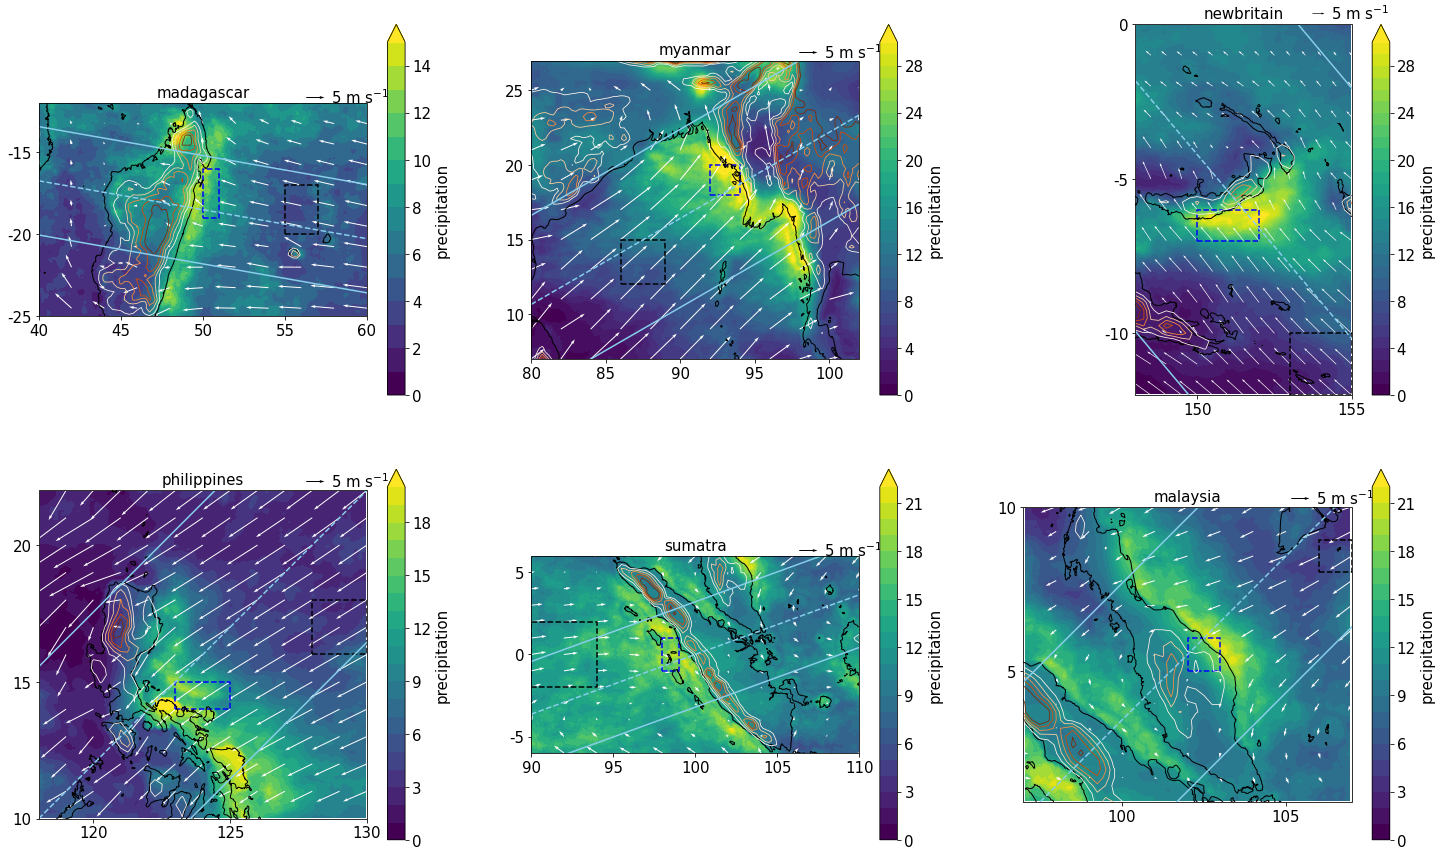

In [61]:
fig,axs = plt.subplots(2,3,figsize=(25,15),subplot_kw={"projection":ccrs.PlateCarree()})
for ax,MR,lev in zip(axs.reshape(-1),(Madagascar, Myanmar, Newbritain, Philippines, Sumatra, Malaysia,),(15,30,30,20,22,22)):
    topography_pr_wind_plot(ax,MR.box,MR.vars['Z'],MR.vars['GPM_PR'],MR.vars['VAR_100U'],MR.vars['VAR_100V'],np.arange(0,lev+1,1))

    #Boxes
    for smallbox,clr in ((MR.box_upstream,'k'),(MR.box_above,'b')):
        ax.add_patch(mpatches.Rectangle(xy=[smallbox[0], smallbox[2]], width=smallbox[1]-smallbox[0], height=smallbox[3]-smallbox[2],
                                           edgecolor=clr,
                                           fill = False,
                                           lw=1.5,
                                           linestyle='--',
                                           transform=ccrs.PlateCarree())
                        )
    #precipmask.plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['w'])

    alpha = np.tan(np.pi/2-np.pi*MR.angle/180)
    x0,x1=MR.box[0],MR.box[1]; xm=(x0+x1)/2
    y0,y1=MR.box[2],MR.box[3]; ym=(y0+y1)/2
    fx = np.array([ym + alpha*(x0-xm),ym + alpha*(x1-xm)])
    ax.plot([x0,x1],fx,color='skyblue',linestyle='--')
    ax.plot([x0,x1],fx-(y1-y0)/4/np.cos(alpha),color='skyblue',linestyle='-')
    ax.plot([x0,x1],fx+(y1-y0)/4/np.cos(alpha),color='skyblue',linestyle='-')

    ax.set_title(MR.name,fontsize=15);None



## Soundings

(-1.8, 1.8)

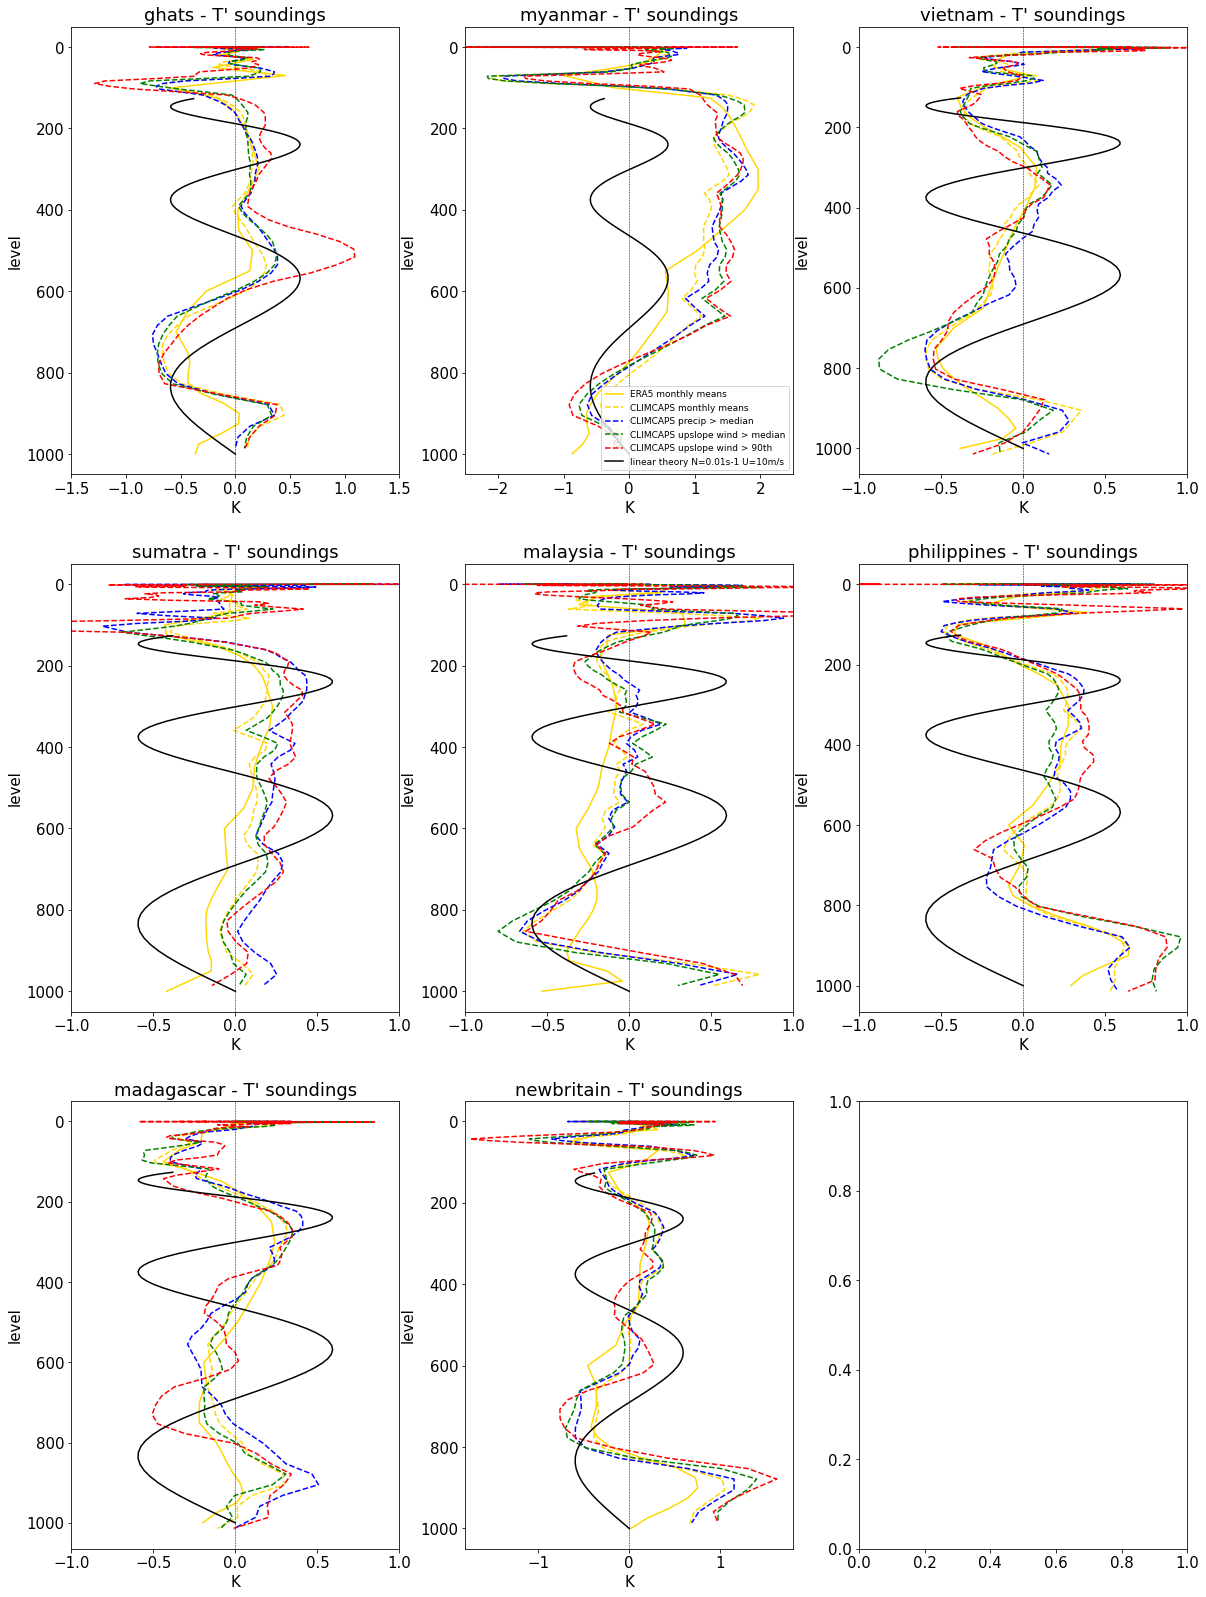

In [63]:
unit = 'K'
fig,axs = plt.subplots(3,3,figsize=(20,28))

with warnings.catch_warnings():
    warnings.simplefilter("ignore",RuntimeWarning)
    for ax,MR in zip(axs.reshape(-1)[:-1],(Ghats,Myanmar,Vietnam,Sumatra,Malaysia,Philippines,Madagascar, Newbritain)):
        plot_z_diff(ax,MR.vars['T']              ,MR.box_upstream,MR.box_above,color='gold' ,label='ERA5 monthly means')
        plot_z_diff(ax,MR.vars['CLIMCAPS_T']     ,MR.box_upstream,MR.box_above,color='gold' ,linestyle='--',label='CLIMCAPS monthly means')
        plot_z_diff(ax,MR.vars['CLIMCAPS_T_PR50'],MR.box_upstream,MR.box_above,color='blue' ,linestyle='--',label='CLIMCAPS precip > median')
        plot_z_diff(ax,MR.vars['CLIMCAPS_T_U50'] ,MR.box_upstream,MR.box_above,color='green',linestyle='--',label='CLIMCAPS upslope wind > median')
        plot_z_diff(ax,MR.vars['CLIMCAPS_T_U90'] ,MR.box_upstream,MR.box_above,color='r',linestyle='--',label='CLIMCAPS upslope wind > 90th')
        ax.plot(linear_Td_10,linear_Td_10.pressure,color='k',label = 'linear theory N=0.01s-1 U=10m/s' )
        ax.set_title("%s - T' soundings"%MR.name)
        ax.set_xlabel(unit)
        ax.axvline(0.,color='k',linestyle='--',linewidth=0.5)
        ax.set_xlim(-1,1)
axs[0,1].legend(fontsize=9,loc=4)
axs[0,0].set_xlim(-1.5,1.5)
axs[0,1].set_xlim(-2.5,2.5)
axs[2,1].set_xlim(-1.8,1.8)



Text(0.5, 1.0, 'U soundings')

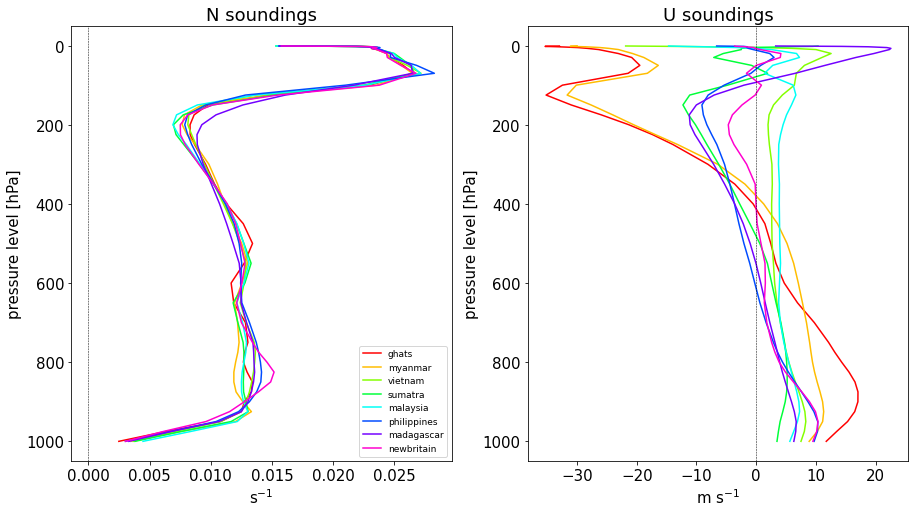

In [26]:

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,8))

colors = plt.cm.hsv(np.linspace(0,1,9))

for c,MR in zip(colors,(Ghats,Myanmar,Vietnam,Sumatra,Malaysia,Philippines,Madagascar, Newbritain,)):
    compute_N(sel_box_month(MR.vars['T'],MR.box_upstream,0).mean(['latitude','longitude']),100,pname='level').plot(ax=ax1,y='level',yincrease=False,color=c ,label=MR.name)
    sel_box_month(MR.vars['U_PERP']     ,MR.box_upstream,0).mean(['latitude','longitude']).plot(ax=ax2,y='level',yincrease=False,color=c ,label=MR.name)


ax1.legend(fontsize=9)  
ax1.set_xlabel(r's$^{-1}$')
ax1.axvline(0.,color='k',linestyle='--',linewidth=0.5)
ax1.set_title("N soundings")

ax2.set_xlabel(r'm s$^{-1}$')
ax2.axvline(0.,color='k',linestyle='--',linewidth=0.5)
ax2.set_title("U soundings")
#ax2.set_xlim(0,10)


## Seasonal scatterplots

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/numpy_func.py:289: RuntimeWarning: invalid value encountered in log
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/quantity.py:1393: RuntimeWarning: invalid value encountered in power
  return other ** new_self._magnitude
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:1067: RuntimeWarning: overflow encountered in exp
  th_es = th_l * np.exp((3036. / t - 1.78) * r * (1 + 0.448 * r))
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:1067: RuntimeWarning: overflow encountered in multiply
  th_es = th_l * np.exp((3036. / t - 1.78) * r * (1 + 0.448 * r))
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/numpy_func.py:289: RuntimeWarning: invalid value encountered in log
  result_magnitude = func(*stripped_args, **stripped

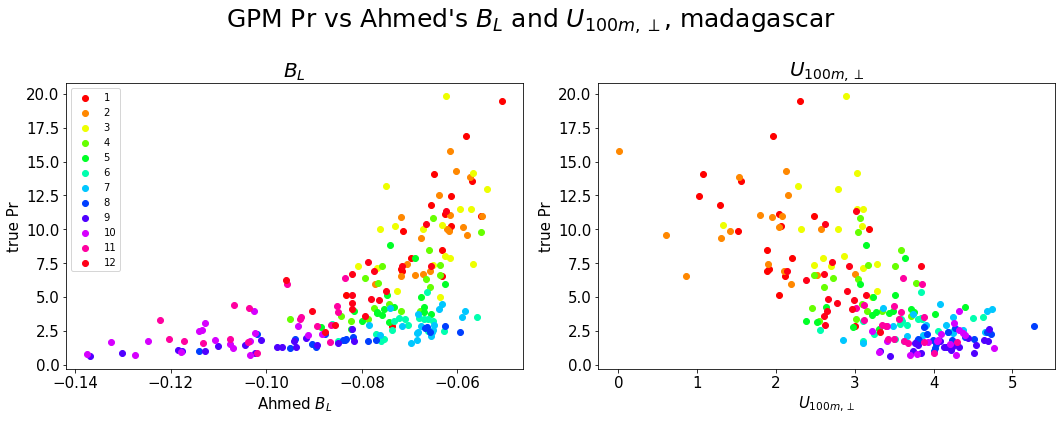

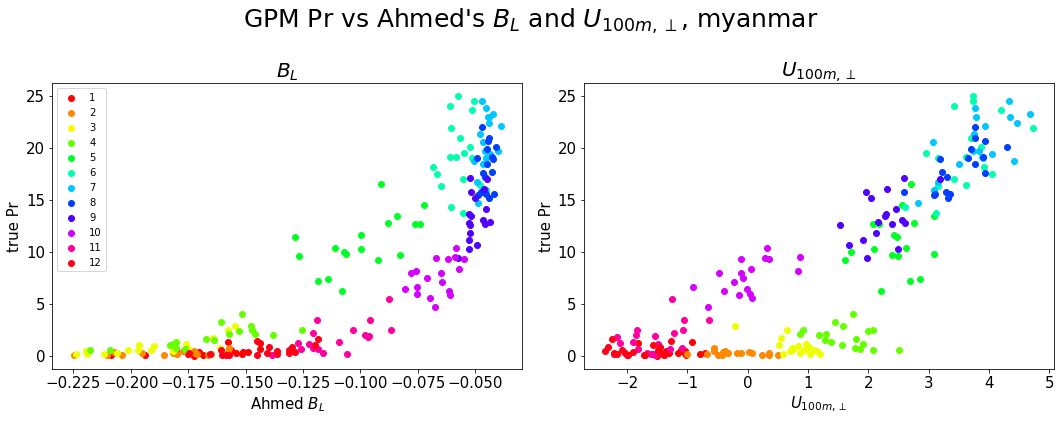

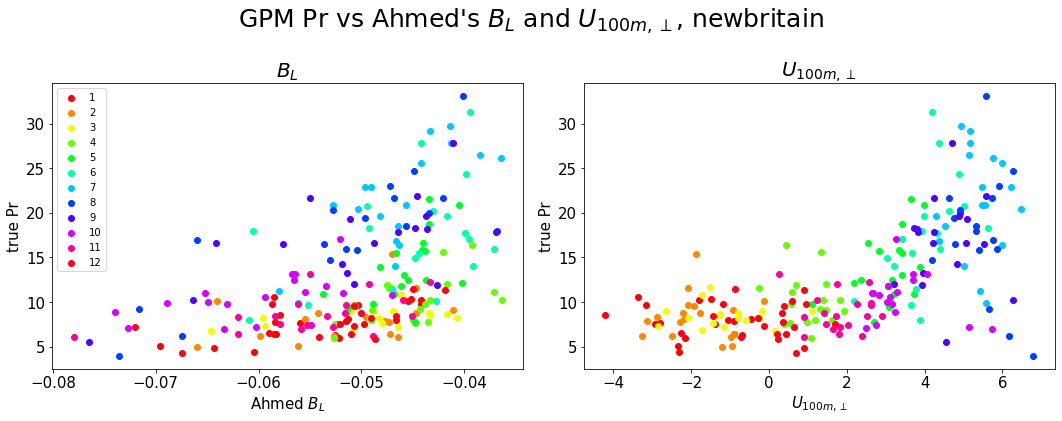

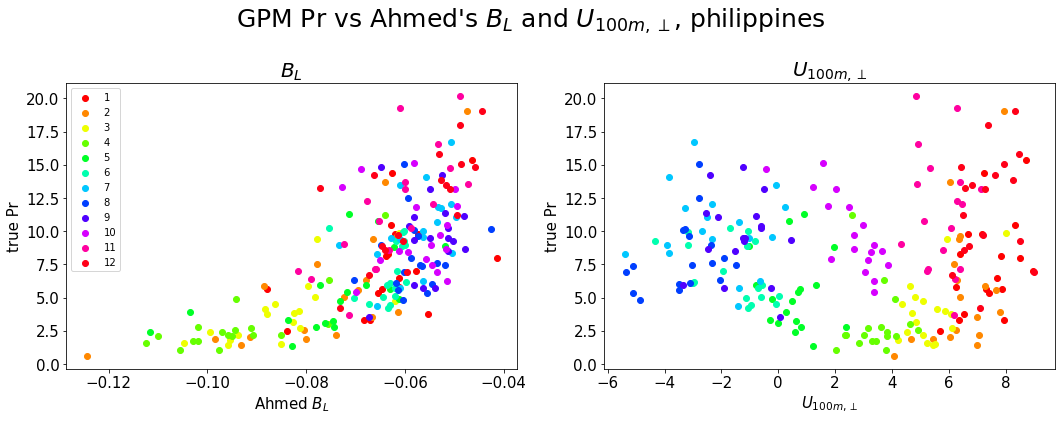

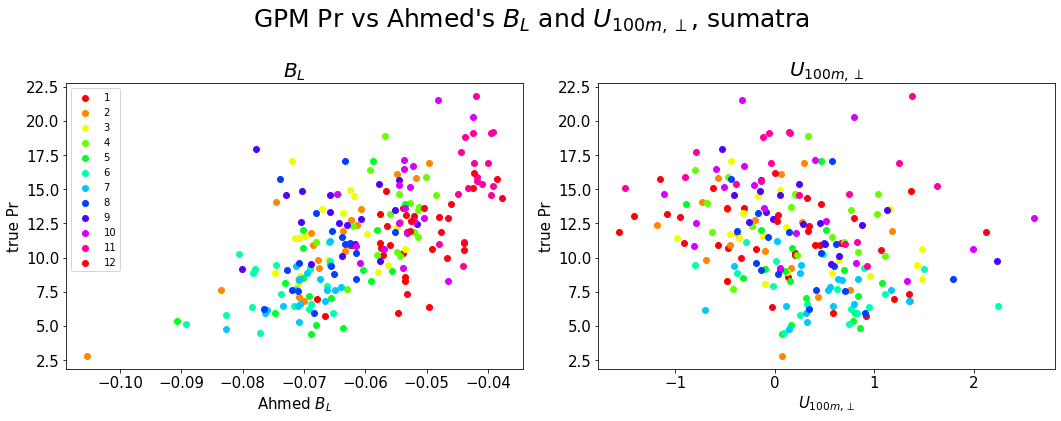

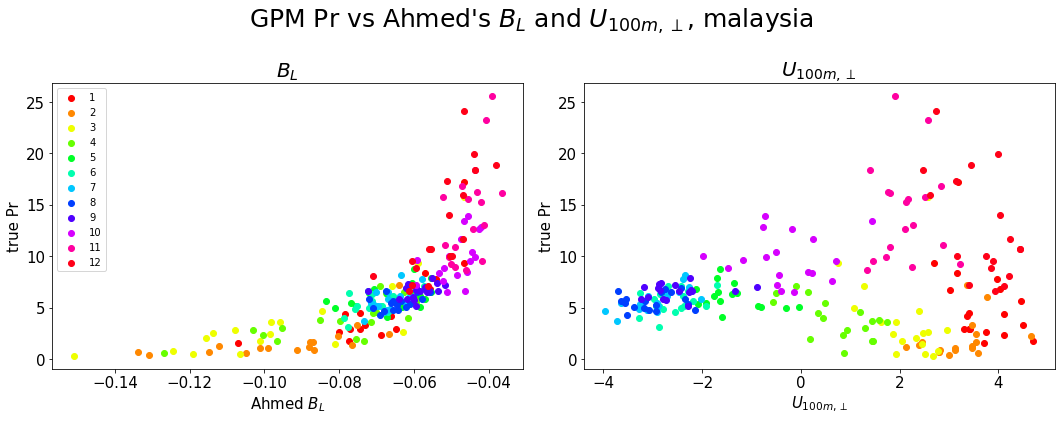

In [47]:
colors=plt.cm.hsv(np.linspace(0,1,12))

for MR in (Madagascar,Myanmar,Newbritain,Philippines,Sumatra,Malaysia):#Vietnam,Ghats,
    mask = 1.*tilted_rect(MR.vars['GPM_PR_3D'][0],*MR.box_tilted)
    mask_era5 = mask.interp_like(MR.vars['E5_PR_3D'][0])
    
    BL_allmonths_box       = BL_plevs(MR.vars['T4D'],MR.vars['Q4D'],700.).where(mask_era5).mean(['latitude','longitude'])
    gpm_pr_allmonths_box   = MR.vars['GPM_PR_3D'].where(mask).mean(['latitude','longitude']).load()
    e5_pr_allmonths_box    = MR.vars['E5_PR_3D'].where(mask_era5).mean(['latitude','longitude']).load()
    uperp100_allmonths_box = MR.vars['VAR_100U_3D_PERP'].where(mask_era5).mean(['latitude','longitude']).load()
    
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
    
    for m in range(12):
        ax1.scatter(sel_month(BL_allmonths_box,m+1),sel_month(gpm_pr_allmonths_box,m+1),color=colors[m],label=m+1)
        ax2.scatter(sel_month(uperp100_allmonths_box,m+1),sel_month(gpm_pr_allmonths_box,m+1),color=colors[m],label=m+1)
    
    ax1.set_title(r'$B_L$' ,fontsize=20)
    ax2.set_title(r'$U_{100m,\perp}$',fontsize=20)
    ax1.set_xlabel(r"Ahmed $B_L$")
    ax1.set_ylabel("true Pr")
    ax2.set_xlabel(r"$U_{100m,\perp}$")
    ax2.set_ylabel("true Pr")

    ax1.legend(loc=2,fontsize=10)
    fig.suptitle(r"GPM Pr vs Ahmed's $B_L$ and $U_{100m,\perp}$, %s"%MR.name,fontsize=25)
    fig.tight_layout()

## Maps of $B_L$ & precip

In [15]:
def sel_months(ds,months):
    return ds.sel(month = np.in1d( ds['month'], months))

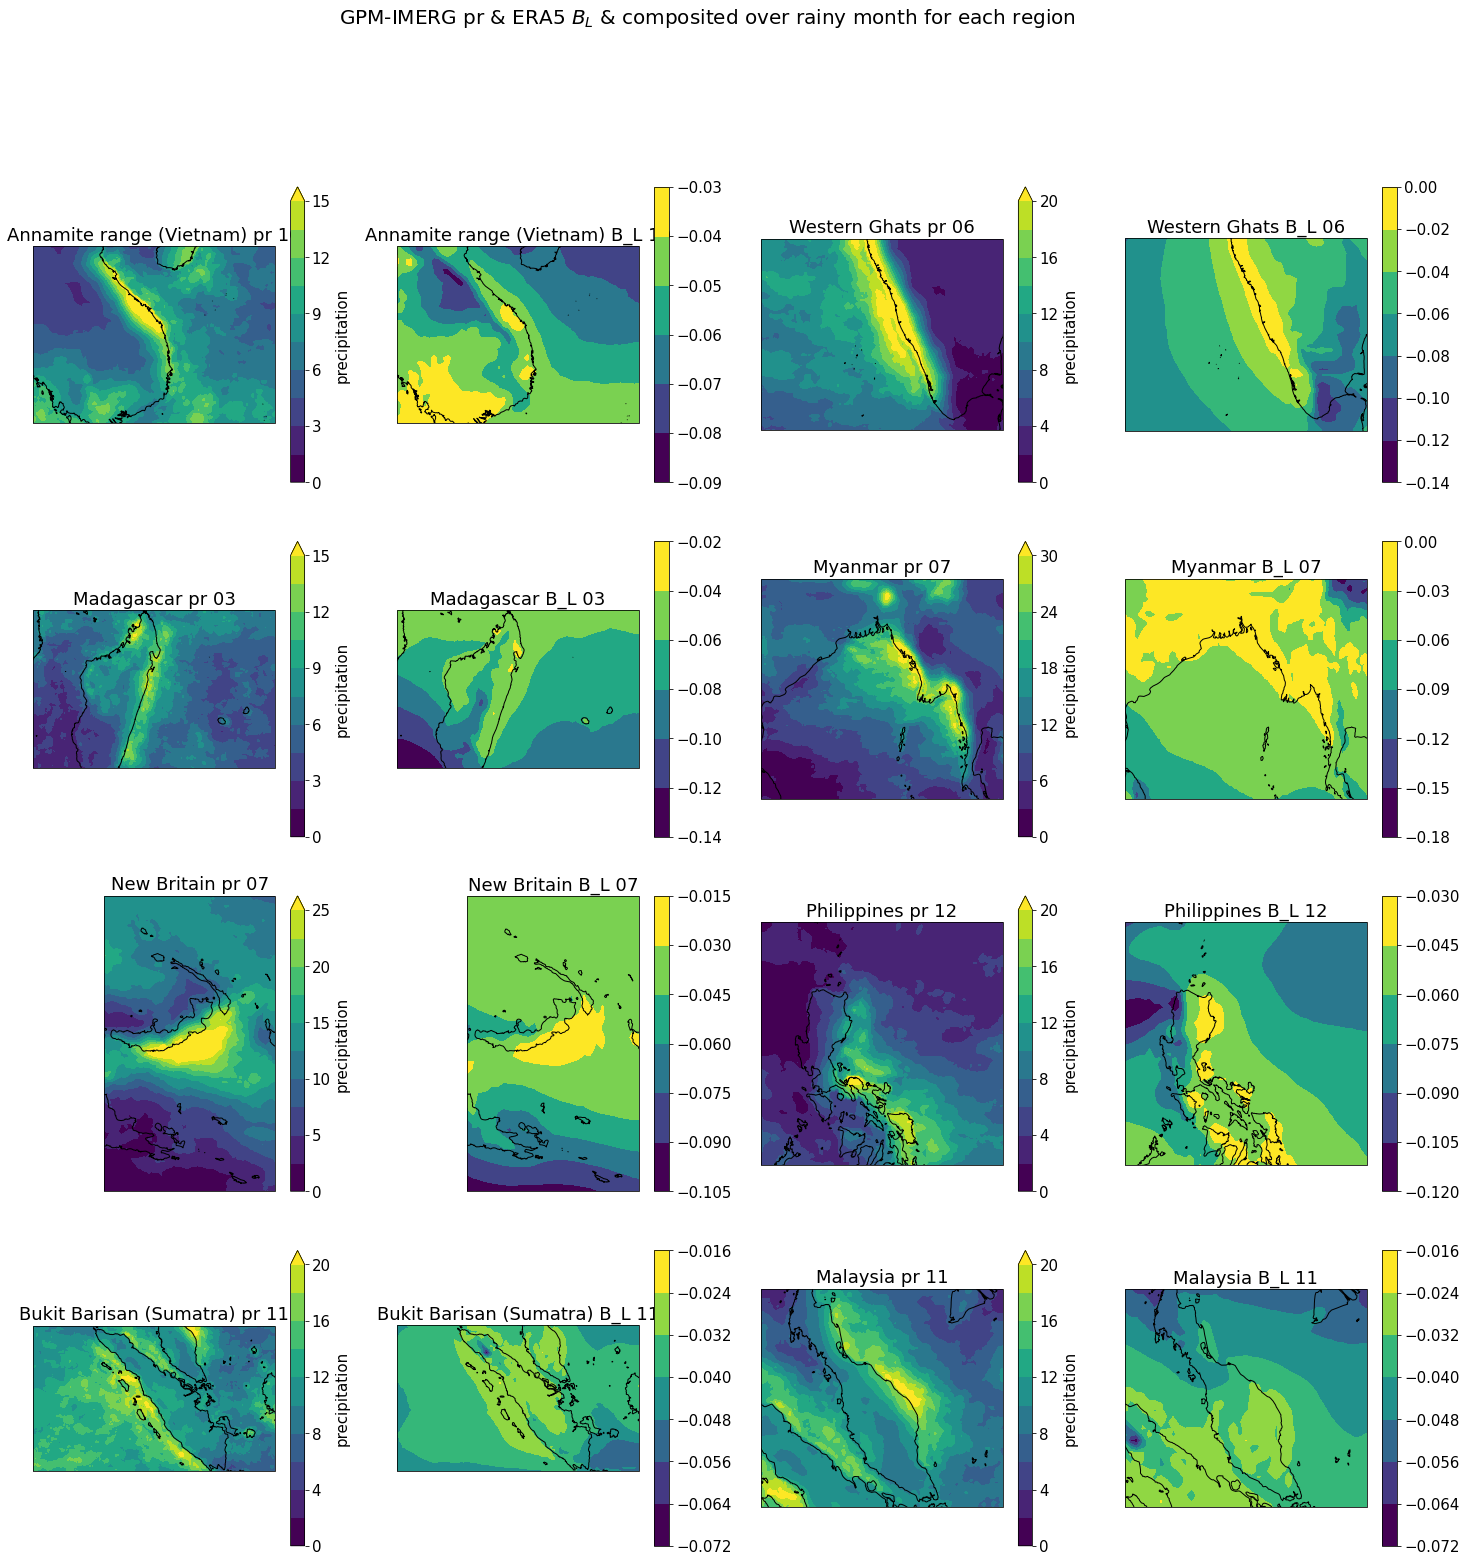

In [29]:
fig,ax = plt.subplots(4,4,figsize=(25,25),subplot_kw={"projection":ccrs.PlateCarree()})
ax = ax.reshape((8,2))
vmaxs=[15,20,15,30,25,20,20,20]
MRs=(Vietnam,Ghats,Madagascar,Myanmar,Newbritain,Philippines,Sumatra,Malaysia)
for i,MR in enumerate(MRs):
    ax[i,0].coastlines();ax[i,1].coastlines()
    MR.vars['GPM_PR'].plot.contourf(ax=ax[i,0],transform=ccrs.PlateCarree(),levels=np.linspace(0.,vmaxs[i],11))
    ax[i,0].set_title(MR.Lname +' pr '+ "{:02}".format(MR.pr_month))
    BL = BL_plevs_vectorized(MR.vars['T'],MR.vars['Q'],700.)
    BL.plot.contourf(ax=ax[i,1],transform=ccrs.PlateCarree())
    ax[i,1].set_title(MR.Lname +r' B_L '+ "{:02}".format(MR.pr_month))

fig.suptitle(r"GPM-IMERG pr & ERA5 $B_L$ & composited over rainy month for each region",fontsize=20);None

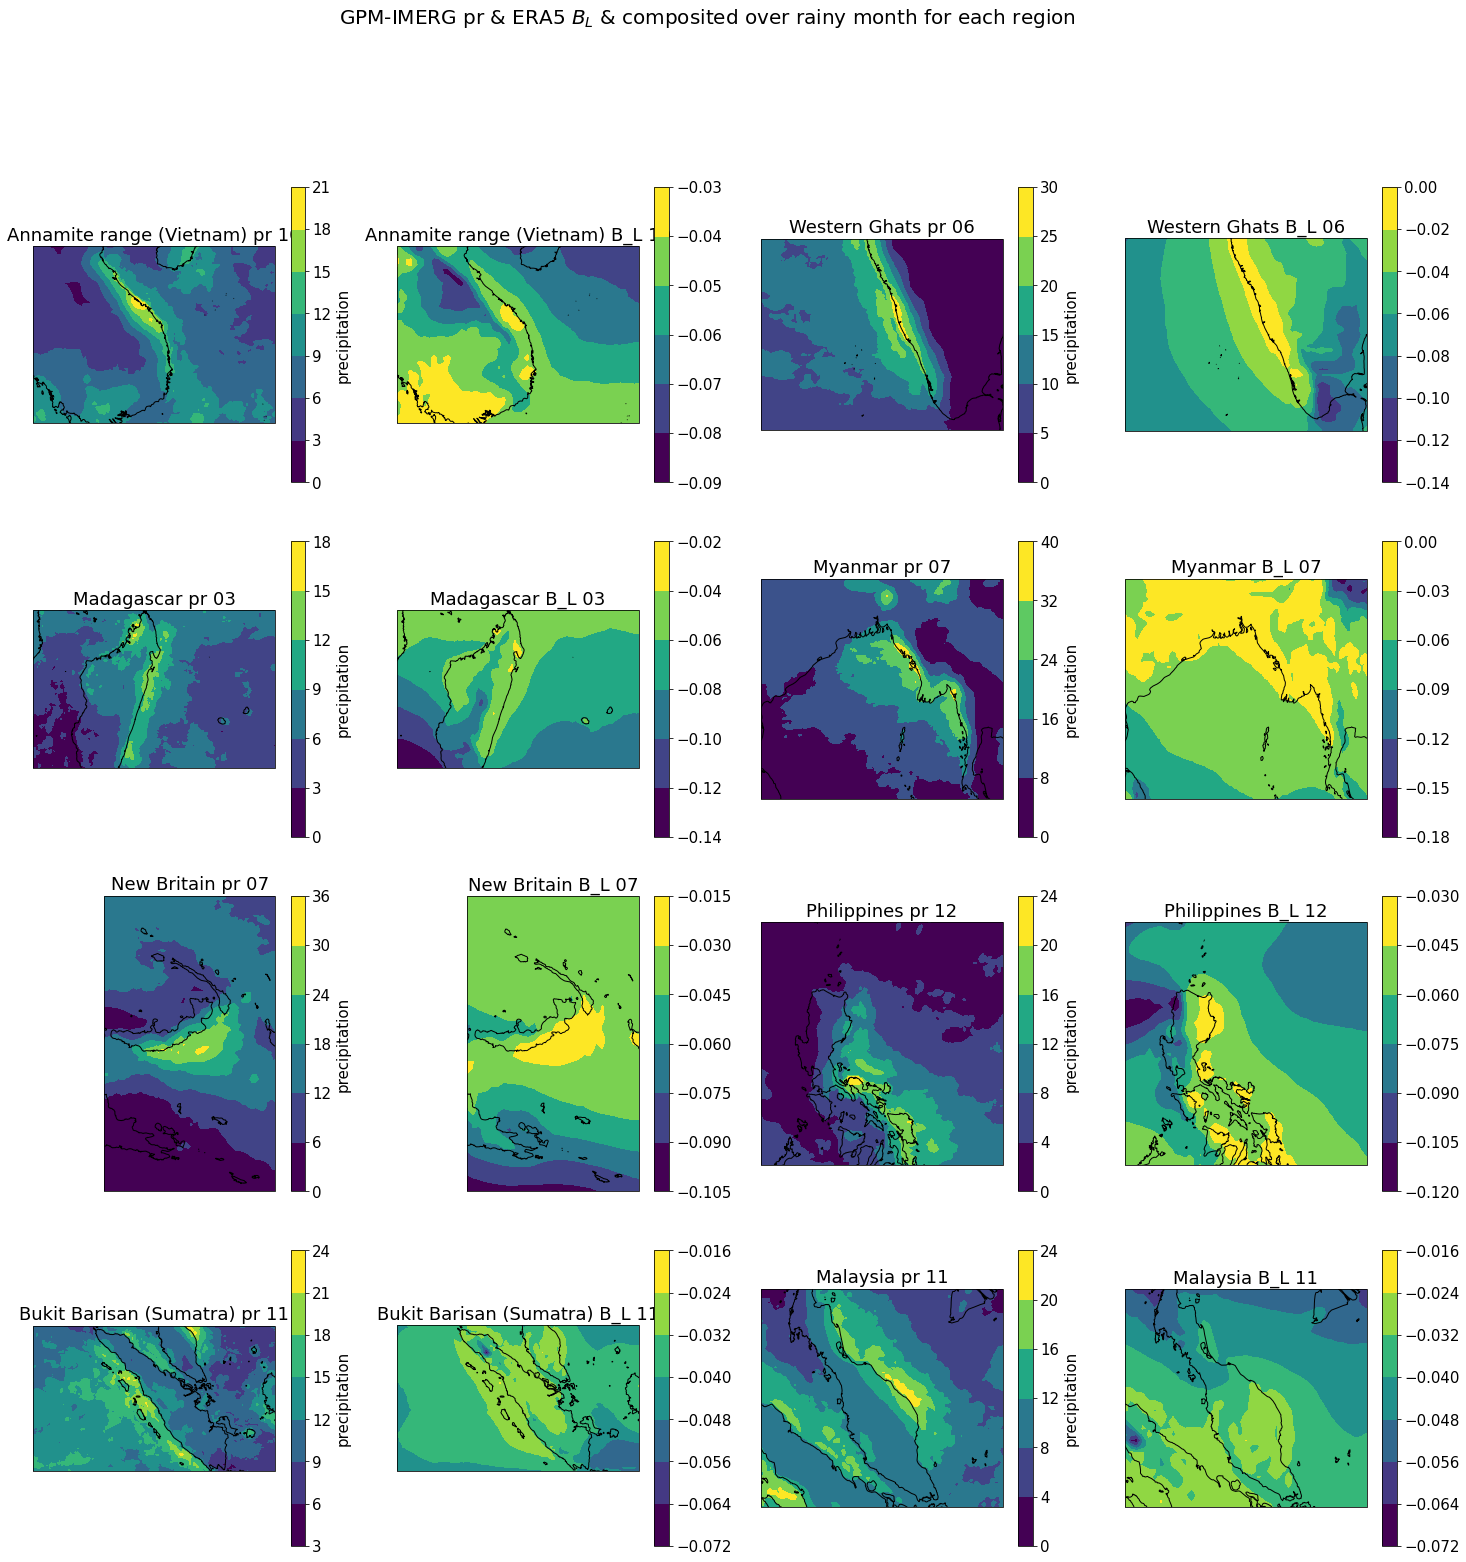

In [30]:
fig,ax = plt.subplots(4,4,figsize=(25,25),subplot_kw={"projection":ccrs.PlateCarree()})
ax = ax.reshape((8,2))
vmaxs=[15,20,15,30,25,20,20,20]
MRs=(Vietnam,Ghats,Madagascar,Myanmar,Newbritain,Philippines,Sumatra,Malaysia)
for i,MR in enumerate(MRs):
    ax[i,0].coastlines();ax[i,1].coastlines()
    MR.vars['GPM_PR'].plot.contourf(ax=ax[i,0],transform=ccrs.PlateCarree())
    ax[i,0].set_title(MR.Lname +' pr '+ "{:02}".format(MR.pr_month))
    BL = BL_plevs_vectorized(MR.vars['T'],MR.vars['Q'],700.)
    BL.plot.contourf(ax=ax[i,1],transform=ccrs.PlateCarree())
    ax[i,1].set_title(MR.Lname +r' B_L '+ "{:02}".format(MR.pr_month))

fig.suptitle(r"GPM-IMERG pr & ERA5 $B_L$ & composited over rainy month for each region",fontsize=20);None

In [14]:
import time
time0=time.time()

Vietnam     = MountainRange("vietnam"    ,*mountains["vietnam" ])
Ghats       = MountainRange("ghats"      ,*mountains["ghats" ])
Madagascar  = MountainRange("madagascar" ,*mountains["madagascar" ])
Myanmar     = MountainRange("myanmar"    ,*mountains["myanmar"    ])
Newbritain  = MountainRange("newbritain" ,*mountains["newbritain" ])
Philippines = MountainRange("philippines",*mountains["philippines"])
Sumatra     = MountainRange("sumatra"    ,*mountains["sumatra"    ])
Malaysia    = MountainRange("malaysia"   ,*mountains["malaysia"   ])

for MR in (Ghats,):
    print(MR.name)
    MR.set_boxes(mountains_ref_rce[MR.name],mountains_ref_above[MR.name],precip_boxes[MR.name])
    
    MR.set_2dvar('GPM_PR',gpm_pr_seasmean)
    MR.set_2dvar('VAR_100U',era5100u_seasmean)
    MR.set_2dvar('VAR_100V',era5100v_seasmean)
    MR.set_2dvar('Z',orogm)
    MR.set_uperp()
    
    MR.set_3dvar('T',"128_130_t")
    MR.set_3dvar('Q',"128_133_q")
    MR.set_3dvar('U',"128_131_u")
    MR.set_3dvar('V',"128_132_v")
    MR.set_uperp3d()
 
    MR.set_4dvar('T4D',"128_130_t")
    MR.set_4dvar('Q4D',"128_133_q")
    MR.set_othervar('GPM_PR_3D',sel_box_month(gpm_pr,MR.box,0))
    MR.set_othervar('E5_PR_3D',sel_box_month(era5pr_monthly,MR.box,0))
    MR.set_othervar('VAR_100U_3D',sel_box_month(era5100u_monthly,MR.box,0))
    MR.set_othervar('VAR_100V_3D',sel_box_month(era5100v_monthly,MR.box,0))
    MR.vars['VAR_100U_3D_PERP'] = crossslopeflow(MR.vars['VAR_100U_3D'], MR.vars['VAR_100V_3D'],MR.angle)
    MR.vars_rot['VAR_100U_3D_PERP'] = crossslopeflow(MR.vars_rot['VAR_100U_3D'], MR.vars_rot['VAR_100V_3D'],MR.angle)

ghats


# CLIMCAPS sdev retrieval

The CLIMCAPS data directly downloaded from sounder.gesdisc.eosdis.nasa.gov do not contain standard dev info, unlike the data accessed thru openDAP. Herafter we download sdevs thru openDAP to quantify the temporal variablility of sdevs.

In [155]:
# paths=[]
# with open("/global/cscratch1/sd/qnicolas/CLIMCAPS_V2/url_daily.txt",'r') as f:
#     lines = f.readlines()
#     for f in lines:
#         if f[-58:-52] == "200310":
#             paths.append(f[-81:-1])
# 
# username = 'qnicolas'
# password = 'Surf@b3rkeley!'
# 
# urls = ["https://sounder.gesdisc.eosdis.nasa.gov/opendap/Aqua_Sounder_Level3/SNDRAQIML3CDCCP.2/"+ path for path in paths]
# url_ex = urls[0]
# 
# session = setup_session(username, password, check_url=url_ex)
# store = xr.backends.PydapDataStore.open(url_ex, session=session)
# ds = xr.open_dataset(store)
# 
# climcaps_sdevs_200310 = 0.+0.*ds.sdev_air_temp_sdev.expand_dims({'time':pd.date_range("20031001","20031027")})
# 
# for i,url in enumerate(urls[:3]):
#     t=time.time()
#     session = setup_session(username, password, check_url=url)
#     store = xr.backends.PydapDataStore.open(url, session=session)
#     ds = xr.open_dataset(store)
#     climcaps_sdevs_200310[i]=ds.sdev_air_temp_sdev
#     print(time.time()-t)
# 
# climcaps_sdevs_200310[:10].to_netcdf("/global/cscratch1/sd/qnicolas/temp/L3_CLIMCAPS_QCC.std.v02_38.air_temp_sdev.20031001-20031010.nc")

In [18]:
climcaps_sdevs_200310=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/L3_CLIMCAPS_QCC.std.v02_38.air_temp_sdev.20031001-20031010.nc")
climcaps_sdevs_201310=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/L3_CLIMCAPS_QCC.std.v02_38.air_temp_sdev.20131001-20131010.nc")

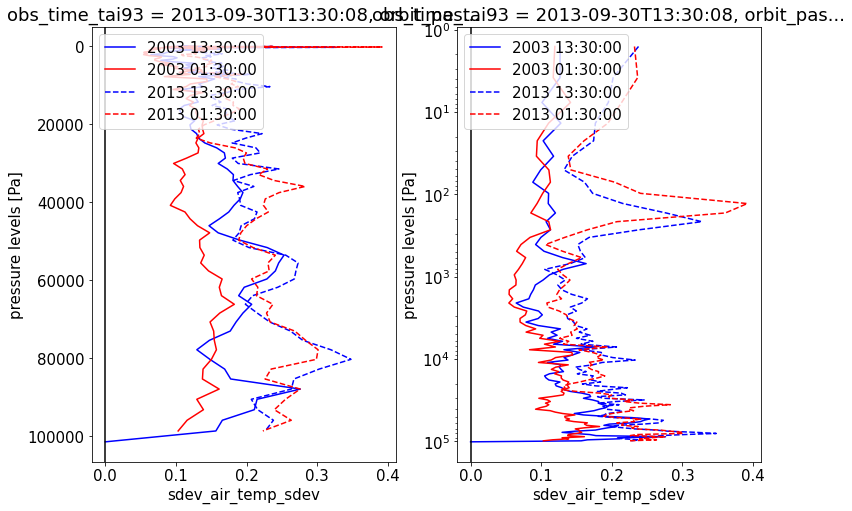

In [20]:
def seltest(ds,box):
    return ds.sel(lon=slice(box[0],box[1]),lat=slice(box[2],box[3])).mean(['lat','lon'])
_,axs=plt.subplots(1,2,figsize=(12,8))
for ax in axs:
    for ds,y,lns in ((climcaps_sdevs_200310,'2003','-'),(climcaps_sdevs_201310,'2013','--')):
        sdevv = seltest(ds.mean('time'),Ghats.box_upstream)
        sdev_of_sdevv = seltest(ds,Ghats.box_upstream).std('time')
    
        sdevv.isel(orbit_pass=0).plot(ax=ax,y='air_pres',yincrease=False , label=y+" "+pd.to_datetime(int(sdevv.orbit_pass[0])).strftime("%H:%M:%S"),color='b',linestyle=lns)
        #ax.fill_betweenx(sdevv.air_pres,sdevv.isel(orbit_pass=0)-2*sdev_of_sdevv.isel(orbit_pass=0),sdevv.isel(orbit_pass=0)+2*sdev_of_sdevv.isel(orbit_pass=0),color='b',alpha=0.3)
        sdevv.isel(orbit_pass=1).plot(ax=ax,y='air_pres',yincrease=False , label=y+" "+pd.to_datetime(int(sdevv.orbit_pass[1])).strftime("%H:%M:%S"),color='r',linestyle=lns)
        #ax.fill_betweenx(sdevv.air_pres,sdevv.isel(orbit_pass=1)-2*sdev_of_sdevv.isel(orbit_pass=1),sdevv.isel(orbit_pass=1)+2*sdev_of_sdevv.isel(orbit_pass=1),color='r',alpha=0.3)
    ax.axvline(0.,color='k')
    ax.legend(loc=2)
ax.set_yscale('log')


In [35]:
!jupyter nbconvert --no-input --to html vietnamAnalysis.ipynb

/bin/bash: jupyter: command not found
